In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import time
from torch.nn import init
from thop import profile

In [2]:
# Remember to install CUDA and cuDNN
# Determine if your system supports CUDA.
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
#%% Read FallAllD data
data=pd.read_hdf("D:/conda/FallAllD.h5") #
data = data.drop(columns = ['Gyr','Mag','Bar'])

#%% Read SisFull
data_Sis_pash="D:/conda/111_1117/SisFall_DL-master/SisFall_dataset/"
df=pd.read_csv(data_Sis_pash+"SisFall_DataNameList.csv",header=0)
df_r=df[1:]

df_v=df['DataName'].values[:]


PATH = "D:/conda/111_1117/SisFull_3LayerModel.pt"
#%% Label
testmin=[]
test_waist = []
data_waist = []
label_waist = []
subject_waist = []
# for i in range(len(data)):
for i in range (len(df_r)):

#     if(data['Device'][i] == 'Waist'):
#         a = data['Acc'][i]*0.000244        
        C_df = pd.read_csv(data_Sis_pash+df['DataName'][i])
        testmin.append(len(C_df))
        C_df = C_df[:].values[:2393].astype('float64')
        a= C_df
        # Normalize each data between 0 and 1
        b = b = (a-np.amin(a))/(np.amax(a)-np.amin(a))
        data_waist.append(b)        
        subject_waist.append(df['Subject'][i])
        # Class: fall = 0 ,ADL = 1 
        if (df['FALL(1)_ADL(0)'][i]): 
                label_waist.append(1)
        else:
                label_waist.append(0)

#extend

# Change list to array
data_waist = np.array(data_waist, dtype=object)            
label_waist = np.array(label_waist, dtype=object)
subject_waist = np.array(subject_waist, dtype=object)
print(data_waist.shape)
# Downsampling 1/128
down_data = []
# (start:size:step)
# def down_data_SisADD(data_waist):
#down_data = data_waist[::1,::128,::1]
# data_waist = data_waist.reshape((len(data_waist), 1, 1))
down_data = data_waist[::1, ::62, ::1]
down_data = np.array(down_data, dtype=object)
print(down_data.shape)
#%% Sliding_window
sliding_waist_data =[]
sliding_waist_label =[]
sliding_waist_subject =[]  
# The signal of each second 
per_sec = 38/20
sec = 7

(3233, 2393, 3)
(3233, 39, 3)


In [3]:
# for num in range(len(down_data)):

#     if label_waist[num] ==1:
#         # Data[index][start:end,axis]
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
#         # Label each window with class and subject
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#         sliding_waist_data = np.append(sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
#         sliding_waist_label = np.append(sliding_waist_label, 1)
#         sliding_waist_subject = np.append(sliding_waist_subject, subject_waist[num])
        
#     else:
#         #print(down_data[num])
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:]])
#         #print(sliding_waist_data)
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])
        
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:]])
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])
        
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:]])
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])
        
#         sliding_waist_data = np.concatenate([sliding_waist_data, down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:]])
#         sliding_waist_label = np.concatenate([sliding_waist_label, 0])
#         sliding_waist_subject = np.concatenate([sliding_waist_subject, subject_waist[num]])


for num in range(len(down_data)):
    if label_waist[num] ==1:
        # Data[index][start:end,axis]
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5)+1),:])
        # Label each window with class and subject
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        
    else:
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])

sliding_waist_data = np.array(sliding_waist_data)
sliding_waist_label = np.array(sliding_waist_label)
sliding_waist_subject = np.array(sliding_waist_subject) 
print(sliding_waist_data.shape)
np.save('FallALLD_SW_data',sliding_waist_data)
np.save('FallALLD_SW_label',sliding_waist_label)
np.save('FallALLD_SW_subject',sliding_waist_subject)

(12932, 14, 3)


In [4]:
#%% Show Teacher confusion matrix
def show_CM_teacher(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher) SubjectID' + str(sub) + '.png')

#%% Show Student confusion matrix
def show_CM_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Student) SubjectID' + str(sub) + '.png')
    
#%% Show Teacher-Student confusion matrix
def show_CM_teacher_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher-Student) SubjectID' + str(sub) + '.png')
def show_loss_teacher(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher) SubjectID' + str(sub) + '.png')
def show_Acc_teacher(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher) SubjectID' + str(sub) + '.png')
#Loss_student
def show_loss_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (Student) SubjectID' + str(sub) + '.png')   
def show_Acc_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (student) SubjectID' + str(sub) + '.png')
def show_loss_teacher_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher_Student) SubjectID' + str(sub) + '.png')   
def show_Acc_teacher_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher_student) SubjectID' + str(sub) + '.png')

In [5]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    labels=labels.type(torch.cuda.LongTensor)
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [6]:
class hswish(nn.Module):
    def forward(self, x):
        out = x * F.relu6(x + 3, inplace=True) / 6
        return out


class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out


class SeModule(nn.Module):
    def __init__(self, in_size, reduction=4):
        super(SeModule, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_size, in_size // reduction, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size // reduction),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_size // reduction, in_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size),
            hsigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, kernel_size, in_size, expand_size, out_size, nolinear, semodule, stride):
        super(Block, self).__init__()
        self.stride = stride
        self.se = semodule

        self.conv1 = nn.Conv2d(in_size, expand_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(expand_size)
        self.nolinear1 = nolinear
        self.conv2 = nn.Conv2d(expand_size, expand_size, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expand_size, bias=False)
        self.bn2 = nn.BatchNorm2d(expand_size)
        self.nolinear2 = nolinear
        self.conv3 = nn.Conv2d(expand_size, out_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_size)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_size != out_size:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_size),
            )

    def forward(self, x):
        out = self.nolinear1(self.bn1(self.conv1(x)))
        out = self.nolinear2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.se != None:
            out = self.se(out)
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

In [7]:
#%% This is the config object which contains all relevant settings.    
config = {
    'nb_filters': 64,
    'filter_width': 1,
    'drop_prob': 0.5,
    'epochs': 200,#200
    'batch_size': 64,
    'learning_rate': 1e-3,#1e-3
    'weight_decay': 2e-6,
    'gpu_name': 'cuda:0',
    'print_counts': False,
    'lr_factor' : 2,
    'lr_warmup' : 40
}

In [8]:
class MobileNetV3_Large(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Large, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), None, 1),
            Block(3, 16, 64, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 72, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 72, 40, nn.ReLU(inplace=True), SeModule(40), 2),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(3, 40, 240, 80, hswish(), None, 2),
            Block(3, 80, 200, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 480, 112, hswish(), SeModule(112), 1),
            Block(3, 112, 672, 112, hswish(), SeModule(112), 1),
            Block(5, 112, 672, 160, hswish(), SeModule(160), 1),
            Block(5, 160, 672, 160, hswish(), SeModule(160), 2),
            Block(5, 160, 960, 160, hswish(), SeModule(160), 1),
        )


        self.conv2 = nn.Conv2d(160, 960, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(960)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(960, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [9]:
class MobileNetV3_Small_KD(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small_KD, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [10]:
#%% Define teacher neural network
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class Net_Teacher(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Student(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Student, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        print("device:", device)
        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Teacher_Student(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher_Student, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [11]:
#%% Define teacher training loop
def training_teacher(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []

        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        train_acc.append(100 * (correct_train / total_train).cpu())
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    #save(config['epochs'], model, optimizer, loss)
    
    eval_table = evaluation(train_preds, train_gt)

    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

#%% Define teacher testing loop
#def testing_teacher(testloader,optimizer,criterion,model):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)

                test_output = model(inputs)
                
                optimizer.zero_grad()

                # Compute loss
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step() 
                test_losses.append(loss.item())        
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)                

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher.append(eval_table[0])
#         Recall_teacher.append(eval_table[1])
#         Precision_teacher.append(eval_table[2])
#         F1score_teacher.append(eval_table[3])
    #Plot train_loss
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

    show_loss_teacher(loss_train, loss_test)
    show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

In [12]:
#%% Define student training loop
def training_student(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(100 * (correct_train / total_train).cpu())
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        
        student_train_preds.extend(test_preds)
        student_train_gt.extend(test_gt)
    #Plot train_loss
    show_loss_student(loss_train, loss_test)
    show_Acc_student(train_acc, test_acc)
    
    #return Accuracy_student, Recall_student, Precision_student, F1score_student
    return student_train_preds, student_train_gt

In [13]:
def training_teacher_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader,Layer,lis):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))   

    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
    
   
    
    
#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    if (Layer==False) and (lis == 23):
            save(config['epochs'], model_student, optimizer, loss)  
            #return teacher_student_train_preds, teacher_student_train_gt, teacher_student_model, teacher_student_optimizer, teacher_student_loss
    if (Layer==False) and (lis == 1):
            save(config['epochs'], model_student, optimizer, loss)
    return teacher_student_train_preds, teacher_student_train_gt

In [14]:
def training_distillation_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader,Layer,lis):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
    

#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        Distillation_student_train_preds.extend(test_preds)
        Distillation_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    return Distillation_student_train_preds, Distillation_student_train_gt

In [15]:
def save(epoch, student, optimizer, loss):
#     trial_id = self.config['trial_id']
#     if name is None:
        torch.save({
        'epoch': epoch,
        'model_state_dict': student.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        #'loss_state_dict': loss.state_dice()
        'loss_state_dict': loss.item()
        }, PATH)
#     else:
#         torch.save({
#         'model_state_dict': self.student.state_dict(),
#         'optimizer_state_dict': self.optimizer.state_dict(),
#         'epoch': epoch,
#         }, name)

        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")
        print("~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~")

In [16]:
def load_checkpoint(model, checkpoint_path):
        """
        Loads weights from checkpoint
        :param model: a pytorch nn student
        :param str checkpoint_path: address/path of a file
        :return: pytorch nn student with weights loaded from checkpoint
        """
        model_ckp = torch.load(checkpoint_path)
        model.load_state_dict(model_ckp['model_state_dict'])
        return model


Subject 1
device: cuda
| epoch   0 | 0.8441 s/epoch | train loss 0.3988
| epoch   1 | 0.7155 s/epoch | train loss 0.3491
| epoch   2 | 0.7093 s/epoch | train loss 0.2858
| epoch   3 | 0.7080 s/epoch | train loss 0.2512
| epoch   4 | 0.7530 s/epoch | train loss 0.3025
| epoch   5 | 0.6974 s/epoch | train loss 0.2908
| epoch   6 | 0.6926 s/epoch | train loss 0.2401
| epoch   7 | 0.7072 s/epoch | train loss 0.2214
| epoch   8 | 0.7014 s/epoch | train loss 0.2028
| epoch   9 | 0.6948 s/epoch | train loss 0.1942
| epoch  10 | 0.7957 s/epoch | train loss 0.1875
| epoch  11 | 0.7362 s/epoch | train loss 0.1776
| epoch  12 | 0.7457 s/epoch | train loss 0.1710
| epoch  13 | 0.7213 s/epoch | train loss 0.1634
| epoch  14 | 0.6961 s/epoch | train loss 0.1655
| epoch  15 | 0.7411 s/epoch | train loss 0.1568
| epoch  16 | 0.7244 s/epoch | train loss 0.1493
| epoch  17 | 1.0054 s/epoch | train loss 0.1498
| epoch  18 | 0.7016 s/epoch | train loss 0.1786
| epoch  19 | 0.6852 s/epoch | train loss 0.1

| epoch 167 | 0.7540 s/epoch | train loss 0.0232
| epoch 168 | 0.8312 s/epoch | train loss 0.0196
| epoch 169 | 0.8269 s/epoch | train loss 0.0216
| epoch 170 | 0.8352 s/epoch | train loss 0.0175
| epoch 171 | 0.8184 s/epoch | train loss 0.0191
| epoch 172 | 0.8292 s/epoch | train loss 0.0178
| epoch 173 | 0.7780 s/epoch | train loss 0.0190
| epoch 174 | 0.8069 s/epoch | train loss 0.0160
| epoch 175 | 0.7932 s/epoch | train loss 0.0239
| epoch 176 | 0.8155 s/epoch | train loss 0.0237
| epoch 177 | 0.8209 s/epoch | train loss 0.0174
| epoch 178 | 0.8401 s/epoch | train loss 0.0202
| epoch 179 | 0.8194 s/epoch | train loss 0.0219
| epoch 180 | 0.8224 s/epoch | train loss 0.0179
| epoch 181 | 0.8075 s/epoch | train loss 0.0227
| epoch 182 | 0.8380 s/epoch | train loss 0.0186
| epoch 183 | 0.8347 s/epoch | train loss 0.0359
| epoch 184 | 0.8341 s/epoch | train loss 0.0261
| epoch 185 | 0.8393 s/epoch | train loss 0.0238
| epoch 186 | 0.8445 s/epoch | train loss 0.0190
| epoch 187 | 0.8299

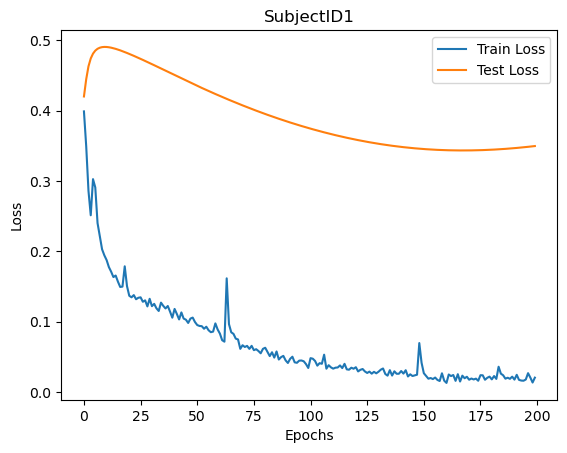

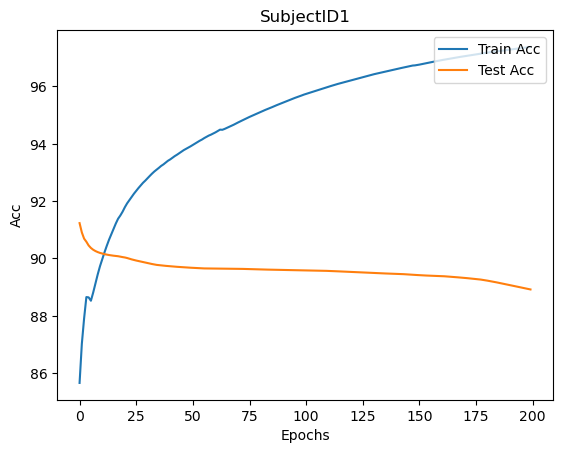

| epoch   0 | 0.6894 s/epoch | train loss 0.3734
| epoch   1 | 0.6932 s/epoch | train loss 0.2899
| epoch   2 | 0.6922 s/epoch | train loss 0.3022
| epoch   3 | 0.6880 s/epoch | train loss 0.2428
| epoch   4 | 0.6931 s/epoch | train loss 0.2832
| epoch   5 | 0.6907 s/epoch | train loss 0.2690
| epoch   6 | 0.6899 s/epoch | train loss 0.3561
| epoch   7 | 0.6865 s/epoch | train loss 0.2821
| epoch   8 | 0.6957 s/epoch | train loss 0.3426
| epoch   9 | 0.6878 s/epoch | train loss 0.4546
| epoch  10 | 0.6919 s/epoch | train loss 0.3197
| epoch  11 | 0.6867 s/epoch | train loss 0.3413
| epoch  12 | 0.6898 s/epoch | train loss 0.2634
| epoch  13 | 0.6927 s/epoch | train loss 0.2458
| epoch  14 | 0.6065 s/epoch | train loss 0.2347
| epoch  15 | 0.5879 s/epoch | train loss 0.2308
| epoch  16 | 0.5858 s/epoch | train loss 0.2202
| epoch  17 | 0.5809 s/epoch | train loss 0.2141
| epoch  18 | 0.5776 s/epoch | train loss 0.2087
| epoch  19 | 0.6768 s/epoch | train loss 0.2001
| epoch  20 | 0.6818

| epoch 168 | 0.8364 s/epoch | train loss 0.0198
| epoch 169 | 0.8600 s/epoch | train loss 0.0169
| epoch 170 | 0.8529 s/epoch | train loss 0.0242
| epoch 171 | 0.8591 s/epoch | train loss 0.0229
| epoch 172 | 0.8600 s/epoch | train loss 0.0194
| epoch 173 | 0.8467 s/epoch | train loss 0.0205
| epoch 174 | 0.8421 s/epoch | train loss 0.0194
| epoch 175 | 0.8459 s/epoch | train loss 0.0197
| epoch 176 | 0.8260 s/epoch | train loss 0.0285
| epoch 177 | 0.8687 s/epoch | train loss 0.0219
| epoch 178 | 0.8287 s/epoch | train loss 0.0142
| epoch 179 | 0.8056 s/epoch | train loss 0.0227
| epoch 180 | 0.7806 s/epoch | train loss 0.0220
| epoch 181 | 0.7733 s/epoch | train loss 0.0177
| epoch 182 | 0.8087 s/epoch | train loss 0.0138
| epoch 183 | 0.8867 s/epoch | train loss 0.0193
| epoch 184 | 0.8400 s/epoch | train loss 0.0156
| epoch 185 | 0.7987 s/epoch | train loss 0.0160
| epoch 186 | 0.8004 s/epoch | train loss 0.0247
| epoch 187 | 0.7370 s/epoch | train loss 0.0167
| epoch 188 | 0.7044

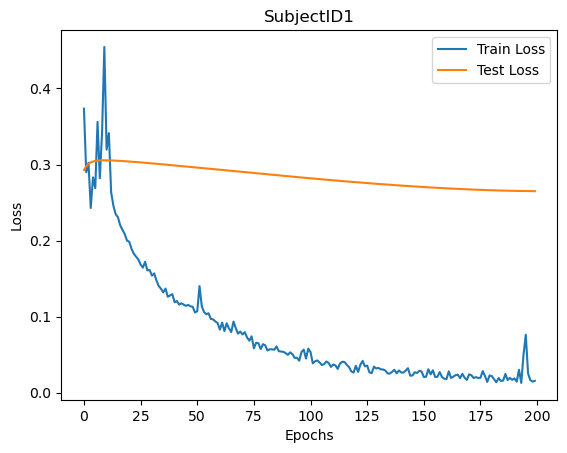

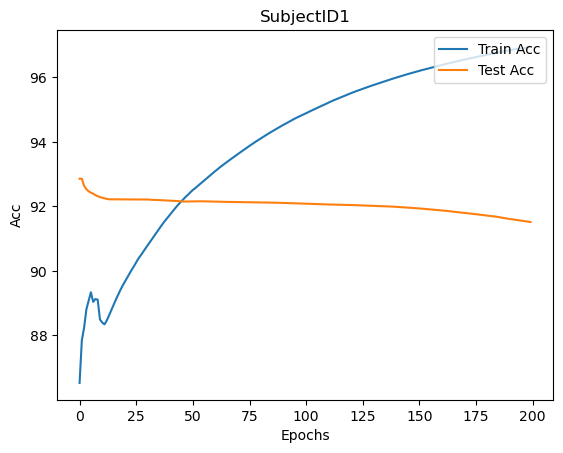


Subject 2
device: cuda
| epoch   0 | 0.8822 s/epoch | train loss 0.3794
| epoch   1 | 0.8594 s/epoch | train loss 0.2938
| epoch   2 | 0.8905 s/epoch | train loss 0.3410
| epoch   3 | 0.8762 s/epoch | train loss 0.2879
| epoch   4 | 0.8517 s/epoch | train loss 0.2446
| epoch   5 | 0.8571 s/epoch | train loss 0.2929
| epoch   6 | 0.8427 s/epoch | train loss 0.2718
| epoch   7 | 0.8920 s/epoch | train loss 0.2323
| epoch   8 | 0.8068 s/epoch | train loss 0.2255
| epoch   9 | 0.7471 s/epoch | train loss 0.2324
| epoch  10 | 0.7416 s/epoch | train loss 0.3441
| epoch  11 | 0.7088 s/epoch | train loss 0.2291
| epoch  12 | 0.6998 s/epoch | train loss 0.2124
| epoch  13 | 0.7892 s/epoch | train loss 0.1989
| epoch  14 | 0.8565 s/epoch | train loss 0.1874
| epoch  15 | 0.8970 s/epoch | train loss 0.1772
| epoch  16 | 0.8547 s/epoch | train loss 0.2047
| epoch  17 | 0.9429 s/epoch | train loss 0.1904
| epoch  18 | 0.9388 s/epoch | train loss 0.1720
| epoch  19 | 0.9374 s/epoch | train loss 0.1

| epoch 167 | 0.7298 s/epoch | train loss 0.0273
| epoch 168 | 0.7478 s/epoch | train loss 0.0250
| epoch 169 | 0.7052 s/epoch | train loss 0.0243
| epoch 170 | 0.6987 s/epoch | train loss 0.0234
| epoch 171 | 0.7141 s/epoch | train loss 0.0237
| epoch 172 | 0.7029 s/epoch | train loss 0.0198
| epoch 173 | 0.7145 s/epoch | train loss 0.0205
| epoch 174 | 0.7108 s/epoch | train loss 0.0310
| epoch 175 | 0.7062 s/epoch | train loss 0.0216
| epoch 176 | 0.7159 s/epoch | train loss 0.0358
| epoch 177 | 0.7181 s/epoch | train loss 0.1062
| epoch 178 | 0.7112 s/epoch | train loss 0.0446
| epoch 179 | 0.6972 s/epoch | train loss 0.0299
| epoch 180 | 0.7094 s/epoch | train loss 0.0277
| epoch 181 | 0.7065 s/epoch | train loss 0.0205
| epoch 182 | 0.7065 s/epoch | train loss 0.0190
| epoch 183 | 0.7219 s/epoch | train loss 0.0173
| epoch 184 | 0.6770 s/epoch | train loss 0.0167
| epoch 185 | 0.6701 s/epoch | train loss 0.0262
| epoch 186 | 0.6196 s/epoch | train loss 0.0187
| epoch 187 | 0.6159

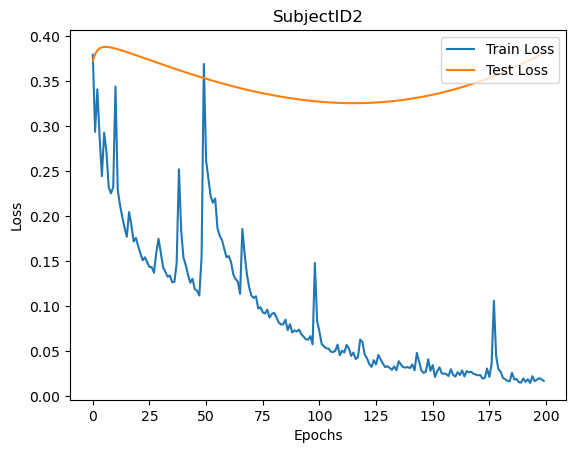

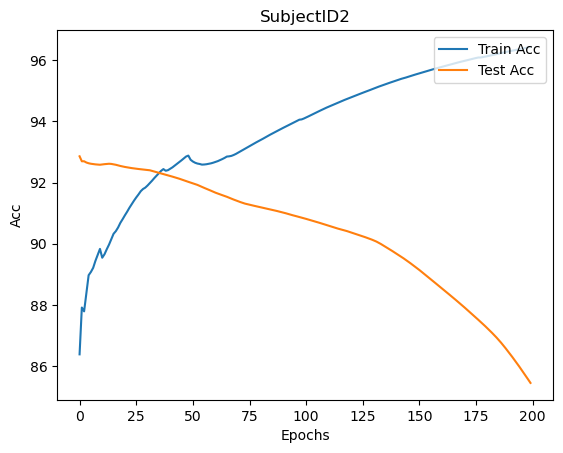

| epoch   0 | 0.7092 s/epoch | train loss 0.3883
| epoch   1 | 0.7367 s/epoch | train loss 0.3532
| epoch   2 | 0.7422 s/epoch | train loss 0.3780
| epoch   3 | 0.7562 s/epoch | train loss 0.2748
| epoch   4 | 0.7895 s/epoch | train loss 0.3450
| epoch   5 | 0.7552 s/epoch | train loss 0.2859
| epoch   6 | 0.7053 s/epoch | train loss 0.2653
| epoch   7 | 0.6836 s/epoch | train loss 0.2544
| epoch   8 | 0.6299 s/epoch | train loss 0.2250
| epoch   9 | 0.6219 s/epoch | train loss 0.3215
| epoch  10 | 0.5935 s/epoch | train loss 0.3980
| epoch  11 | 0.6034 s/epoch | train loss 0.2803
| epoch  12 | 0.6030 s/epoch | train loss 0.2599
| epoch  13 | 0.6293 s/epoch | train loss 0.2860
| epoch  14 | 0.7071 s/epoch | train loss 0.2579
| epoch  15 | 0.7005 s/epoch | train loss 0.2511
| epoch  16 | 0.7064 s/epoch | train loss 0.2379
| epoch  17 | 0.7054 s/epoch | train loss 0.2204
| epoch  18 | 0.7040 s/epoch | train loss 0.3163
| epoch  19 | 0.6936 s/epoch | train loss 0.3929
| epoch  20 | 0.6856

| epoch 168 | 0.7153 s/epoch | train loss 0.0294
| epoch 169 | 0.7047 s/epoch | train loss 0.0222
| epoch 170 | 0.7106 s/epoch | train loss 0.0229
| epoch 171 | 0.7129 s/epoch | train loss 0.0230
| epoch 172 | 0.7157 s/epoch | train loss 0.0312
| epoch 173 | 0.7141 s/epoch | train loss 0.0227
| epoch 174 | 0.7195 s/epoch | train loss 0.0168
| epoch 175 | 0.7179 s/epoch | train loss 0.0245
| epoch 176 | 0.7418 s/epoch | train loss 0.0180
| epoch 177 | 0.8149 s/epoch | train loss 0.0229
| epoch 178 | 0.6997 s/epoch | train loss 0.0214
| epoch 179 | 0.7058 s/epoch | train loss 0.0277
| epoch 180 | 0.7179 s/epoch | train loss 0.0288
| epoch 181 | 0.7310 s/epoch | train loss 0.0220
| epoch 182 | 0.7049 s/epoch | train loss 0.0252
| epoch 183 | 0.7109 s/epoch | train loss 0.0245
| epoch 184 | 0.7420 s/epoch | train loss 0.0241
| epoch 185 | 0.7006 s/epoch | train loss 0.0243
| epoch 186 | 0.6187 s/epoch | train loss 0.0210
| epoch 187 | 0.5896 s/epoch | train loss 0.0210
| epoch 188 | 0.6393

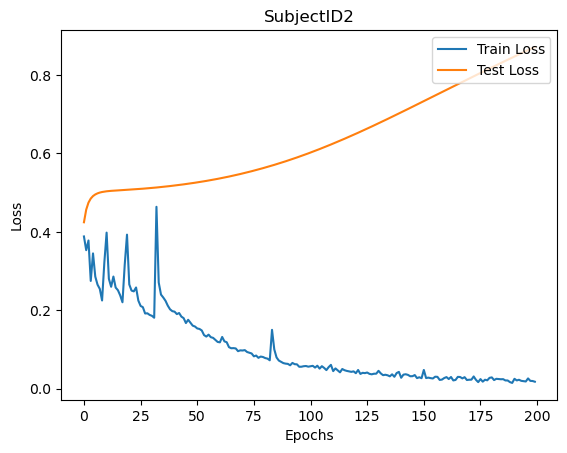

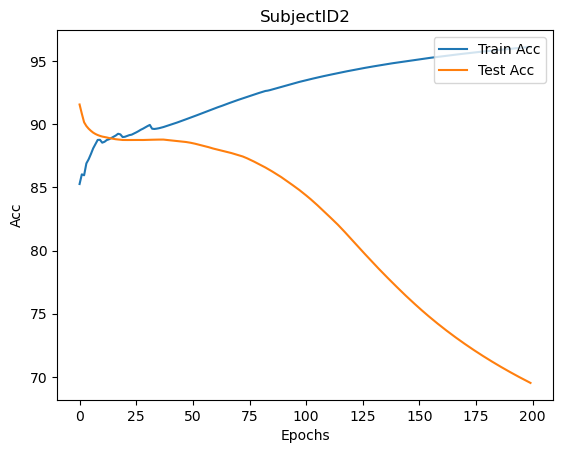


Subject 3
device: cuda
| epoch   0 | 0.6945 s/epoch | train loss 0.3818
| epoch   1 | 0.6964 s/epoch | train loss 0.2824
| epoch   2 | 0.6959 s/epoch | train loss 0.2983
| epoch   3 | 0.6949 s/epoch | train loss 0.2877
| epoch   4 | 0.7003 s/epoch | train loss 0.2902
| epoch   5 | 0.6946 s/epoch | train loss 0.2282
| epoch   6 | 0.6906 s/epoch | train loss 0.3335
| epoch   7 | 0.6947 s/epoch | train loss 0.3620
| epoch   8 | 0.7003 s/epoch | train loss 0.3071
| epoch   9 | 0.6913 s/epoch | train loss 0.3004
| epoch  10 | 0.6199 s/epoch | train loss 0.3250
| epoch  11 | 0.5976 s/epoch | train loss 0.2451
| epoch  12 | 0.6049 s/epoch | train loss 0.2580
| epoch  13 | 0.6247 s/epoch | train loss 0.2491
| epoch  14 | 0.5945 s/epoch | train loss 0.2662
| epoch  15 | 0.5971 s/epoch | train loss 0.3073
| epoch  16 | 0.6202 s/epoch | train loss 0.2448
| epoch  17 | 0.7186 s/epoch | train loss 0.2119
| epoch  18 | 0.7193 s/epoch | train loss 0.2071
| epoch  19 | 0.7189 s/epoch | train loss 0.3

| epoch 167 | 0.7851 s/epoch | train loss 0.0244
| epoch 168 | 0.7798 s/epoch | train loss 0.0223
| epoch 169 | 0.7772 s/epoch | train loss 0.0214
| epoch 170 | 0.7479 s/epoch | train loss 0.0236
| epoch 171 | 0.6872 s/epoch | train loss 0.0162
| epoch 172 | 0.7015 s/epoch | train loss 0.0247
| epoch 173 | 0.7471 s/epoch | train loss 0.0188
| epoch 174 | 0.7476 s/epoch | train loss 0.0228
| epoch 175 | 0.7688 s/epoch | train loss 0.0222
| epoch 176 | 0.7797 s/epoch | train loss 0.0237
| epoch 177 | 0.7517 s/epoch | train loss 0.0196
| epoch 178 | 0.8056 s/epoch | train loss 0.0173
| epoch 179 | 0.7845 s/epoch | train loss 0.0233
| epoch 180 | 0.7886 s/epoch | train loss 0.0280
| epoch 181 | 0.7697 s/epoch | train loss 0.0229
| epoch 182 | 0.8056 s/epoch | train loss 0.0194
| epoch 183 | 0.8008 s/epoch | train loss 0.0173
| epoch 184 | 0.8312 s/epoch | train loss 0.0226
| epoch 185 | 0.7990 s/epoch | train loss 0.0257
| epoch 186 | 0.8425 s/epoch | train loss 0.0192
| epoch 187 | 0.8107

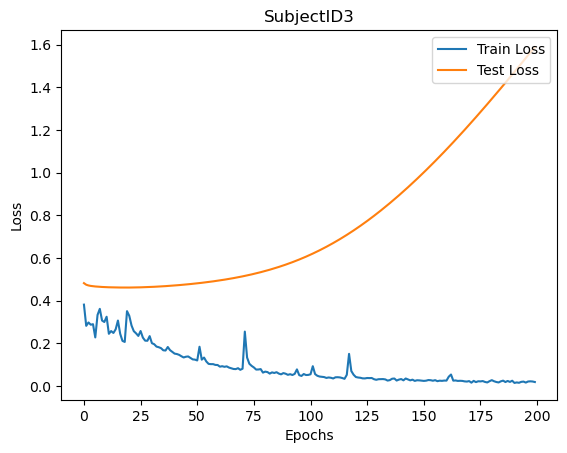

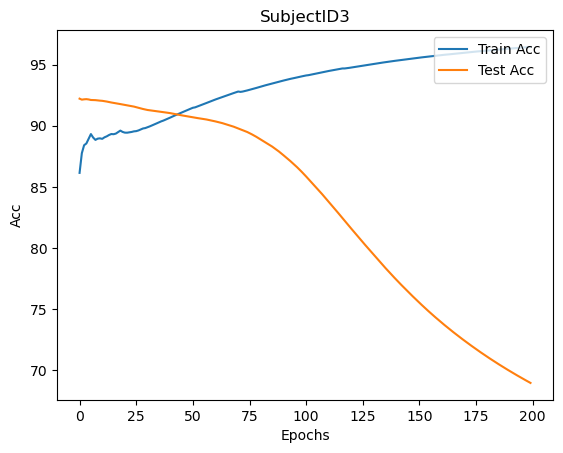

| epoch   0 | 0.7248 s/epoch | train loss 0.3354
| epoch   1 | 0.7177 s/epoch | train loss 0.2449
| epoch   2 | 0.7291 s/epoch | train loss 0.2185
| epoch   3 | 0.7643 s/epoch | train loss 0.1965
| epoch   4 | 0.7750 s/epoch | train loss 0.1942
| epoch   5 | 0.7987 s/epoch | train loss 0.1798
| epoch   6 | 0.8040 s/epoch | train loss 0.1775
| epoch   7 | 0.8004 s/epoch | train loss 0.1618
| epoch   8 | 0.7905 s/epoch | train loss 0.1617
| epoch   9 | 0.8171 s/epoch | train loss 0.1600
| epoch  10 | 0.7927 s/epoch | train loss 0.1624
| epoch  11 | 0.7826 s/epoch | train loss 0.1544
| epoch  12 | 0.8029 s/epoch | train loss 0.1597
| epoch  13 | 0.7599 s/epoch | train loss 0.1577
| epoch  14 | 0.7960 s/epoch | train loss 0.1539
| epoch  15 | 0.8187 s/epoch | train loss 0.1421
| epoch  16 | 0.7738 s/epoch | train loss 0.1382
| epoch  17 | 0.6335 s/epoch | train loss 0.1310
| epoch  18 | 0.6180 s/epoch | train loss 0.1367
| epoch  19 | 0.5989 s/epoch | train loss 0.1291
| epoch  20 | 0.5937

| epoch 168 | 0.6810 s/epoch | train loss 0.0199
| epoch 169 | 0.6846 s/epoch | train loss 0.0226
| epoch 170 | 0.6831 s/epoch | train loss 0.0219
| epoch 171 | 0.6767 s/epoch | train loss 0.0144
| epoch 172 | 0.6825 s/epoch | train loss 0.0229
| epoch 173 | 0.6865 s/epoch | train loss 0.0229
| epoch 174 | 0.6809 s/epoch | train loss 0.0193
| epoch 175 | 0.6114 s/epoch | train loss 0.0176
| epoch 176 | 0.5796 s/epoch | train loss 0.0168
| epoch 177 | 0.5725 s/epoch | train loss 0.0323
| epoch 178 | 0.5795 s/epoch | train loss 0.0216
| epoch 179 | 0.5823 s/epoch | train loss 0.0205
| epoch 180 | 0.5779 s/epoch | train loss 0.0157
| epoch 181 | 0.5756 s/epoch | train loss 0.0185
| epoch 182 | 0.5914 s/epoch | train loss 0.0170
| epoch 183 | 0.6858 s/epoch | train loss 0.0174
| epoch 184 | 0.6841 s/epoch | train loss 0.0174
| epoch 185 | 0.6706 s/epoch | train loss 0.0148
| epoch 186 | 0.6728 s/epoch | train loss 0.0146
| epoch 187 | 0.6802 s/epoch | train loss 0.0233
| epoch 188 | 0.6839

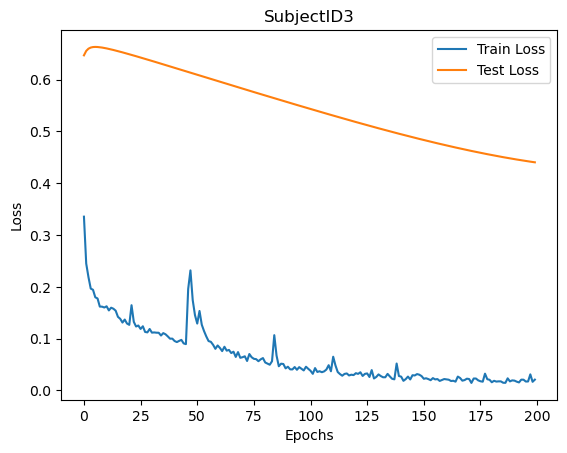

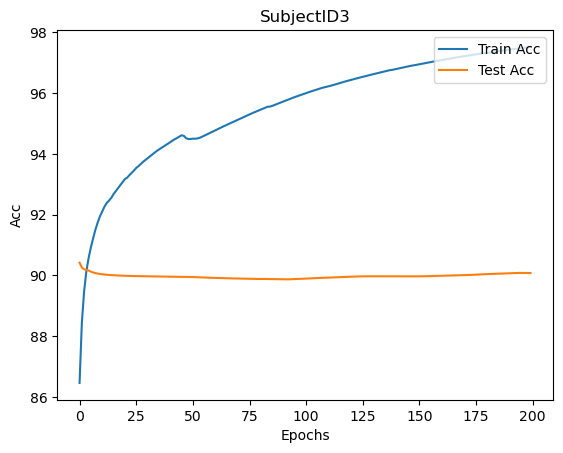


Subject 4
device: cuda
| epoch   0 | 0.6632 s/epoch | train loss 0.3877
| epoch   1 | 0.5804 s/epoch | train loss 0.2632
| epoch   2 | 0.5779 s/epoch | train loss 0.3583
| epoch   3 | 0.5742 s/epoch | train loss 0.2868
| epoch   4 | 0.5749 s/epoch | train loss 0.4294
| epoch   5 | 0.5719 s/epoch | train loss 0.3036
| epoch   6 | 0.5782 s/epoch | train loss 0.3032
| epoch   7 | 0.5784 s/epoch | train loss 0.2771
| epoch   8 | 0.6113 s/epoch | train loss 0.2769
| epoch   9 | 0.6785 s/epoch | train loss 0.2529
| epoch  10 | 0.6801 s/epoch | train loss 0.2666
| epoch  11 | 0.6760 s/epoch | train loss 0.2589
| epoch  12 | 0.6772 s/epoch | train loss 0.3136
| epoch  13 | 0.6765 s/epoch | train loss 0.3007
| epoch  14 | 0.6708 s/epoch | train loss 0.3154
| epoch  15 | 0.6839 s/epoch | train loss 0.3368
| epoch  16 | 0.6817 s/epoch | train loss 0.2798
| epoch  17 | 0.6775 s/epoch | train loss 0.2576
| epoch  18 | 0.6778 s/epoch | train loss 0.2415
| epoch  19 | 0.6783 s/epoch | train loss 0.2

| epoch 167 | 0.5792 s/epoch | train loss 0.0194
| epoch 168 | 0.6806 s/epoch | train loss 0.0256
| epoch 169 | 0.6854 s/epoch | train loss 0.0236
| epoch 170 | 0.6778 s/epoch | train loss 0.0222
| epoch 171 | 0.6787 s/epoch | train loss 0.0228
| epoch 172 | 0.6824 s/epoch | train loss 0.0244
| epoch 173 | 0.6787 s/epoch | train loss 0.0228
| epoch 174 | 0.6824 s/epoch | train loss 0.0199
| epoch 175 | 0.6851 s/epoch | train loss 0.0212
| epoch 176 | 0.6748 s/epoch | train loss 0.0246
| epoch 177 | 0.6825 s/epoch | train loss 0.0178
| epoch 178 | 0.6780 s/epoch | train loss 0.0207
| epoch 179 | 0.6795 s/epoch | train loss 0.0268
| epoch 180 | 0.6826 s/epoch | train loss 0.0254
| epoch 181 | 0.6787 s/epoch | train loss 0.0234
| epoch 182 | 0.6857 s/epoch | train loss 0.0230
| epoch 183 | 0.6692 s/epoch | train loss 0.0194
| epoch 184 | 0.6826 s/epoch | train loss 0.0186
| epoch 185 | 0.6855 s/epoch | train loss 0.0182
| epoch 186 | 0.6805 s/epoch | train loss 0.0151
| epoch 187 | 0.6677

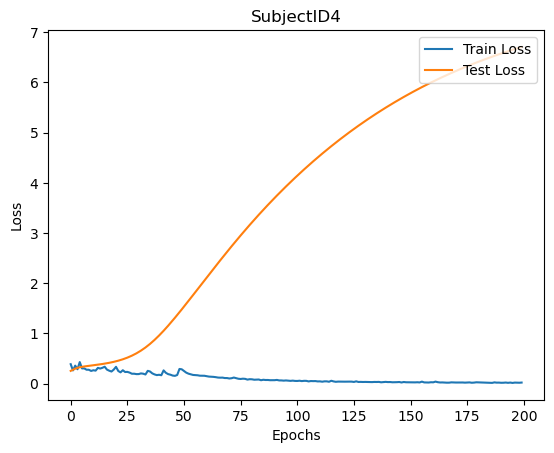

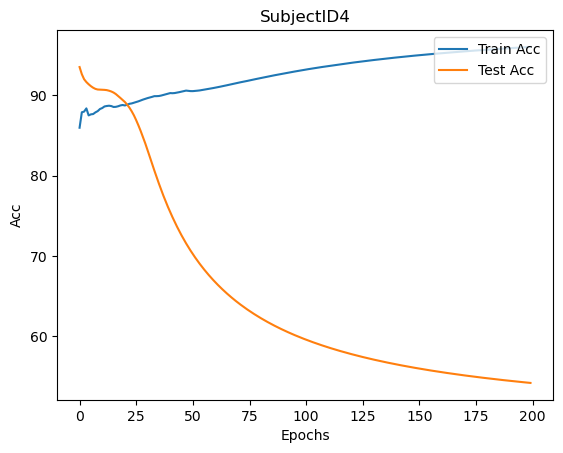

| epoch   0 | 0.6764 s/epoch | train loss 0.3841
| epoch   1 | 0.6758 s/epoch | train loss 0.2580
| epoch   2 | 0.6680 s/epoch | train loss 0.2380
| epoch   3 | 0.6789 s/epoch | train loss 0.2229
| epoch   4 | 0.6752 s/epoch | train loss 0.2204
| epoch   5 | 0.6790 s/epoch | train loss 0.2001
| epoch   6 | 0.6782 s/epoch | train loss 0.2001
| epoch   7 | 0.6752 s/epoch | train loss 0.1867
| epoch   8 | 0.6788 s/epoch | train loss 0.1857
| epoch   9 | 0.6756 s/epoch | train loss 0.1781
| epoch  10 | 0.6718 s/epoch | train loss 0.2167
| epoch  11 | 0.6765 s/epoch | train loss 0.1873
| epoch  12 | 0.6748 s/epoch | train loss 0.1734
| epoch  13 | 0.6723 s/epoch | train loss 0.1714
| epoch  14 | 0.6760 s/epoch | train loss 0.1633
| epoch  15 | 0.6722 s/epoch | train loss 0.1566
| epoch  16 | 0.6728 s/epoch | train loss 0.1603
| epoch  17 | 0.6787 s/epoch | train loss 0.1523
| epoch  18 | 0.5790 s/epoch | train loss 0.1458
| epoch  19 | 0.5697 s/epoch | train loss 0.1473
| epoch  20 | 0.5740

| epoch 168 | 0.6832 s/epoch | train loss 0.0261
| epoch 169 | 0.6766 s/epoch | train loss 0.0245
| epoch 170 | 0.6803 s/epoch | train loss 0.0260
| epoch 171 | 0.6779 s/epoch | train loss 0.0225
| epoch 172 | 0.6786 s/epoch | train loss 0.0255
| epoch 173 | 0.6779 s/epoch | train loss 0.0246
| epoch 174 | 0.6781 s/epoch | train loss 0.0264
| epoch 175 | 0.6788 s/epoch | train loss 0.0232
| epoch 176 | 0.6751 s/epoch | train loss 0.0242
| epoch 177 | 0.6814 s/epoch | train loss 0.0181
| epoch 178 | 0.6808 s/epoch | train loss 0.0253
| epoch 179 | 0.6705 s/epoch | train loss 0.0327
| epoch 180 | 0.5712 s/epoch | train loss 0.0316
| epoch 181 | 0.5794 s/epoch | train loss 0.0240
| epoch 182 | 0.5822 s/epoch | train loss 0.0245
| epoch 183 | 0.5789 s/epoch | train loss 0.0166
| epoch 184 | 0.5824 s/epoch | train loss 0.0221
| epoch 185 | 0.5764 s/epoch | train loss 0.0222
| epoch 186 | 0.5698 s/epoch | train loss 0.0200
| epoch 187 | 0.5798 s/epoch | train loss 0.0192
| epoch 188 | 0.6354

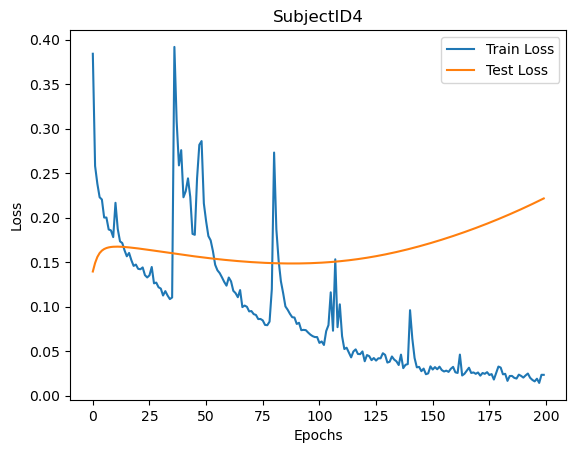

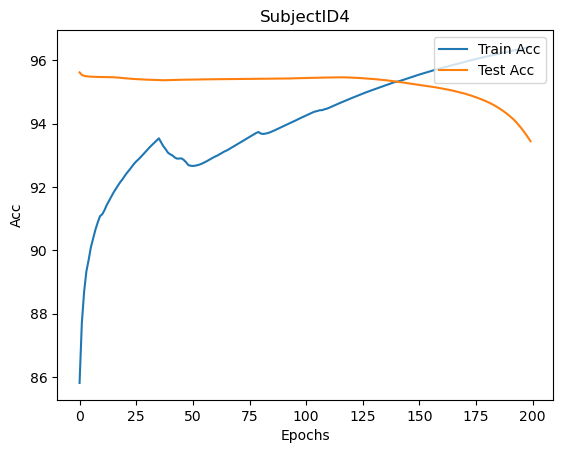


Subject 5
device: cuda
| epoch   0 | 0.6748 s/epoch | train loss 0.4003
| epoch   1 | 0.6774 s/epoch | train loss 0.3057
| epoch   2 | 0.6754 s/epoch | train loss 0.3504
| epoch   3 | 0.6782 s/epoch | train loss 0.3200
| epoch   4 | 0.6708 s/epoch | train loss 0.2918
| epoch   5 | 0.6753 s/epoch | train loss 0.2480
| epoch   6 | 0.6248 s/epoch | train loss 0.2271
| epoch   7 | 0.5792 s/epoch | train loss 0.2255
| epoch   8 | 0.5749 s/epoch | train loss 0.2464
| epoch   9 | 0.5673 s/epoch | train loss 0.2818
| epoch  10 | 0.5750 s/epoch | train loss 0.2244
| epoch  11 | 0.5816 s/epoch | train loss 0.2150
| epoch  12 | 0.5689 s/epoch | train loss 0.1915
| epoch  13 | 0.5762 s/epoch | train loss 0.2120
| epoch  14 | 0.5774 s/epoch | train loss 0.2016
| epoch  15 | 0.6609 s/epoch | train loss 0.2155
| epoch  16 | 0.6771 s/epoch | train loss 0.1772
| epoch  17 | 0.6790 s/epoch | train loss 0.3916
| epoch  18 | 0.6706 s/epoch | train loss 0.4760
| epoch  19 | 0.6772 s/epoch | train loss 0.3

| epoch 167 | 0.3942 s/epoch | train loss 0.0326
| epoch 168 | 0.3946 s/epoch | train loss 0.0255
| epoch 169 | 0.3959 s/epoch | train loss 0.0265
| epoch 170 | 0.3981 s/epoch | train loss 0.0271
| epoch 171 | 0.3906 s/epoch | train loss 0.0276
| epoch 172 | 0.3988 s/epoch | train loss 0.0202
| epoch 173 | 0.3996 s/epoch | train loss 0.0254
| epoch 174 | 0.3908 s/epoch | train loss 0.0243
| epoch 175 | 0.3932 s/epoch | train loss 0.0251
| epoch 176 | 0.3968 s/epoch | train loss 0.0245
| epoch 177 | 0.3916 s/epoch | train loss 0.0594
| epoch 178 | 0.3943 s/epoch | train loss 0.0255
| epoch 179 | 0.4004 s/epoch | train loss 0.0183
| epoch 180 | 0.3908 s/epoch | train loss 0.0196
| epoch 181 | 0.3958 s/epoch | train loss 0.0158
| epoch 182 | 0.4016 s/epoch | train loss 0.0181
| epoch 183 | 0.3970 s/epoch | train loss 0.0198
| epoch 184 | 0.3817 s/epoch | train loss 0.0222
| epoch 185 | 0.2625 s/epoch | train loss 0.0199
| epoch 186 | 0.2615 s/epoch | train loss 0.0168
| epoch 187 | 0.2786

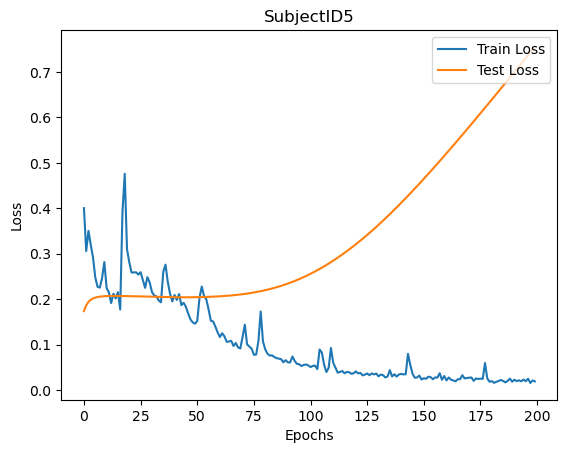

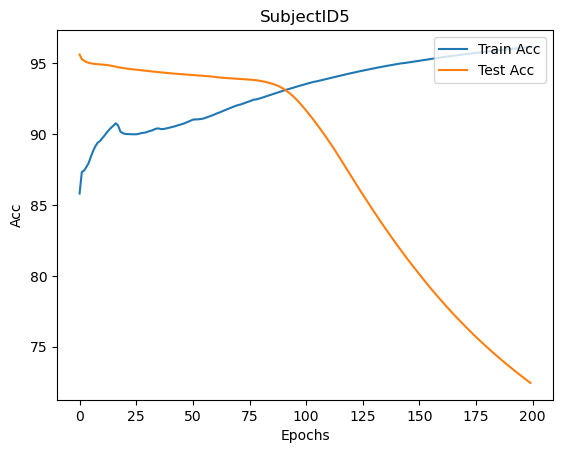

| epoch   0 | 0.3934 s/epoch | train loss 0.3690
| epoch   1 | 0.3895 s/epoch | train loss 0.2466
| epoch   2 | 0.3970 s/epoch | train loss 0.2171
| epoch   3 | 0.3957 s/epoch | train loss 0.2163
| epoch   4 | 0.3953 s/epoch | train loss 0.1942
| epoch   5 | 0.3905 s/epoch | train loss 0.1997
| epoch   6 | 0.3993 s/epoch | train loss 0.2419
| epoch   7 | 0.3900 s/epoch | train loss 0.2073
| epoch   8 | 0.3928 s/epoch | train loss 0.1939
| epoch   9 | 0.3960 s/epoch | train loss 0.1834
| epoch  10 | 0.3957 s/epoch | train loss 0.1662
| epoch  11 | 0.3924 s/epoch | train loss 0.1628
| epoch  12 | 0.3859 s/epoch | train loss 0.1551
| epoch  13 | 0.3967 s/epoch | train loss 0.1535
| epoch  14 | 0.3961 s/epoch | train loss 0.1412
| epoch  15 | 0.3980 s/epoch | train loss 0.1461
| epoch  16 | 0.3964 s/epoch | train loss 0.1435
| epoch  17 | 0.3833 s/epoch | train loss 0.1400
| epoch  18 | 0.3808 s/epoch | train loss 0.1380
| epoch  19 | 0.3967 s/epoch | train loss 0.1349
| epoch  20 | 0.3908

| epoch 168 | 0.2785 s/epoch | train loss 0.0218
| epoch 169 | 0.2712 s/epoch | train loss 0.0230
| epoch 170 | 0.2804 s/epoch | train loss 0.0203
| epoch 171 | 0.2863 s/epoch | train loss 0.0505
| epoch 172 | 0.2763 s/epoch | train loss 0.0338
| epoch 173 | 0.2751 s/epoch | train loss 0.0241
| epoch 174 | 0.3201 s/epoch | train loss 0.0204
| epoch 175 | 0.3940 s/epoch | train loss 0.0218
| epoch 176 | 0.3832 s/epoch | train loss 0.0152
| epoch 177 | 0.4009 s/epoch | train loss 0.0178
| epoch 178 | 0.3948 s/epoch | train loss 0.0161
| epoch 179 | 0.3870 s/epoch | train loss 0.0137
| epoch 180 | 0.4011 s/epoch | train loss 0.0196
| epoch 181 | 0.4003 s/epoch | train loss 0.0193
| epoch 182 | 0.3998 s/epoch | train loss 0.0157
| epoch 183 | 0.3938 s/epoch | train loss 0.0170
| epoch 184 | 0.3918 s/epoch | train loss 0.0209
| epoch 185 | 0.3974 s/epoch | train loss 0.0218
| epoch 186 | 0.3983 s/epoch | train loss 0.0181
| epoch 187 | 0.3889 s/epoch | train loss 0.0140
| epoch 188 | 0.3990

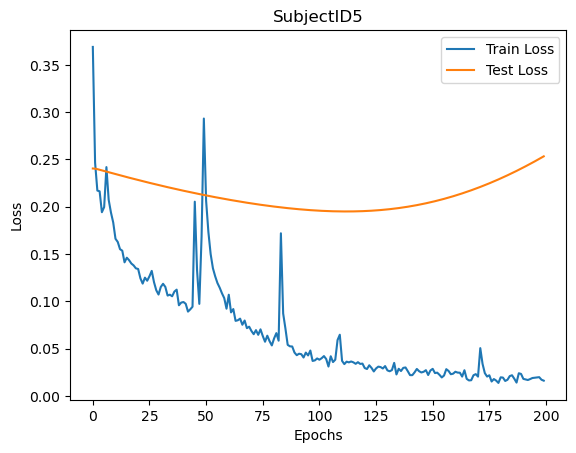

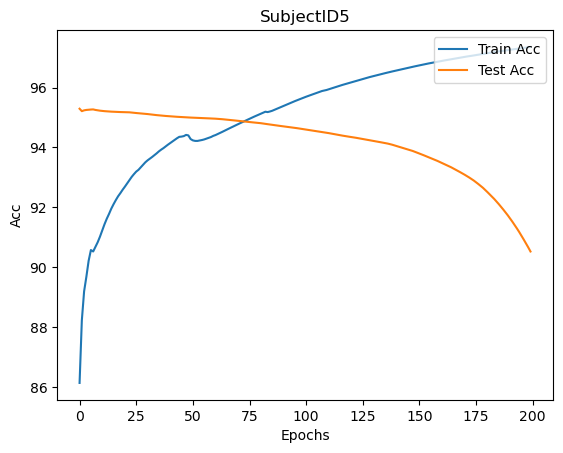


Subject 7
device: cuda
| epoch   0 | 0.2912 s/epoch | train loss 0.3322
| epoch   1 | 0.2680 s/epoch | train loss 0.2475
| epoch   2 | 0.2631 s/epoch | train loss 0.2185
| epoch   3 | 0.2775 s/epoch | train loss 0.2093
| epoch   4 | 0.2895 s/epoch | train loss 0.1932
| epoch   5 | 0.2492 s/epoch | train loss 0.1805
| epoch   6 | 0.2514 s/epoch | train loss 0.1843
| epoch   7 | 0.2499 s/epoch | train loss 0.1709
| epoch   8 | 0.2678 s/epoch | train loss 0.1677
| epoch   9 | 0.2586 s/epoch | train loss 0.1619
| epoch  10 | 0.2830 s/epoch | train loss 0.1555
| epoch  11 | 0.2731 s/epoch | train loss 0.1579
| epoch  12 | 0.2638 s/epoch | train loss 0.1541
| epoch  13 | 0.3982 s/epoch | train loss 0.1555
| epoch  14 | 0.3961 s/epoch | train loss 0.1474
| epoch  15 | 0.3980 s/epoch | train loss 0.1454
| epoch  16 | 0.3873 s/epoch | train loss 0.1432
| epoch  17 | 0.3927 s/epoch | train loss 0.1356
| epoch  18 | 0.3975 s/epoch | train loss 0.1298
| epoch  19 | 0.3983 s/epoch | train loss 0.1

| epoch 167 | 0.6857 s/epoch | train loss 0.0188
| epoch 168 | 0.6945 s/epoch | train loss 0.0153
| epoch 169 | 0.6897 s/epoch | train loss 0.0184
| epoch 170 | 0.6177 s/epoch | train loss 0.0251
| epoch 171 | 0.5830 s/epoch | train loss 0.0183
| epoch 172 | 0.5945 s/epoch | train loss 0.0216
| epoch 173 | 0.5904 s/epoch | train loss 0.0220
| epoch 174 | 0.5942 s/epoch | train loss 0.0211
| epoch 175 | 0.5903 s/epoch | train loss 0.0237
| epoch 176 | 0.5908 s/epoch | train loss 0.0203
| epoch 177 | 0.5948 s/epoch | train loss 0.0275
| epoch 178 | 0.5965 s/epoch | train loss 0.0206
| epoch 179 | 0.5992 s/epoch | train loss 0.0211
| epoch 180 | 0.7075 s/epoch | train loss 0.0145
| epoch 181 | 0.7042 s/epoch | train loss 0.0222
| epoch 182 | 0.6903 s/epoch | train loss 0.0170
| epoch 183 | 0.7077 s/epoch | train loss 0.0196
| epoch 184 | 0.7062 s/epoch | train loss 0.0168
| epoch 185 | 0.6454 s/epoch | train loss 0.0189
| epoch 186 | 0.6028 s/epoch | train loss 0.0176
| epoch 187 | 0.5899

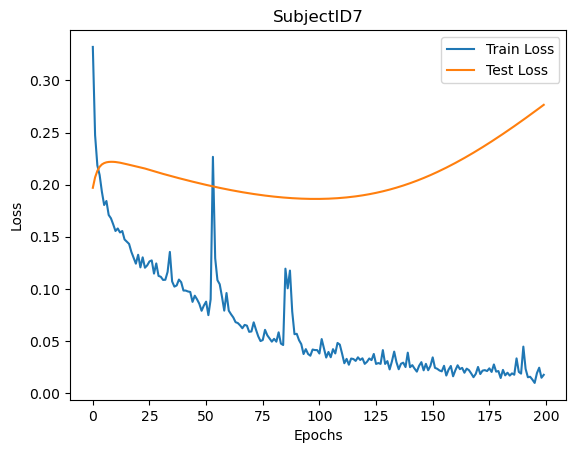

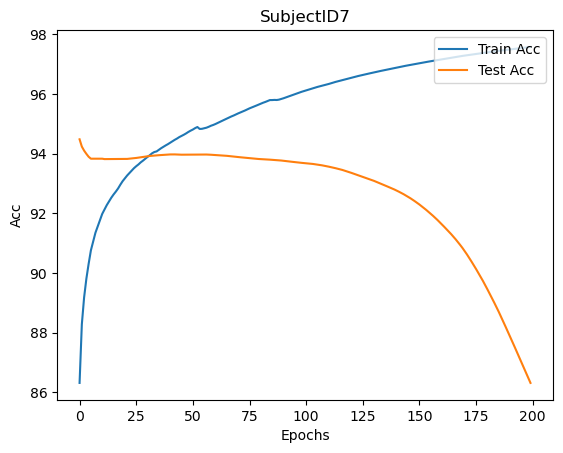

| epoch   0 | 0.6793 s/epoch | train loss 0.3828
| epoch   1 | 0.6967 s/epoch | train loss 0.2680
| epoch   2 | 0.6856 s/epoch | train loss 0.3400
| epoch   3 | 0.6850 s/epoch | train loss 0.2763
| epoch   4 | 0.6909 s/epoch | train loss 0.3111
| epoch   5 | 0.6903 s/epoch | train loss 0.2632
| epoch   6 | 0.6931 s/epoch | train loss 0.2138
| epoch   7 | 0.6881 s/epoch | train loss 0.1995
| epoch   8 | 0.6883 s/epoch | train loss 0.2307
| epoch   9 | 0.6886 s/epoch | train loss 0.1903
| epoch  10 | 0.6949 s/epoch | train loss 0.1831
| epoch  11 | 0.6946 s/epoch | train loss 0.1782
| epoch  12 | 0.6929 s/epoch | train loss 0.2660
| epoch  13 | 0.6852 s/epoch | train loss 0.4022
| epoch  14 | 0.6937 s/epoch | train loss 0.2942
| epoch  15 | 0.6922 s/epoch | train loss 0.2776
| epoch  16 | 0.6805 s/epoch | train loss 0.2764
| epoch  17 | 0.6842 s/epoch | train loss 0.2237
| epoch  18 | 0.6934 s/epoch | train loss 0.2003
| epoch  19 | 0.6899 s/epoch | train loss 0.1895
| epoch  20 | 0.6911

| epoch 168 | 0.8883 s/epoch | train loss 0.0237
| epoch 169 | 0.8104 s/epoch | train loss 0.0266
| epoch 170 | 0.8404 s/epoch | train loss 0.0237
| epoch 171 | 0.7944 s/epoch | train loss 0.0259
| epoch 172 | 0.7766 s/epoch | train loss 0.0274
| epoch 173 | 0.8407 s/epoch | train loss 0.0304
| epoch 174 | 0.8324 s/epoch | train loss 0.0275
| epoch 175 | 0.8207 s/epoch | train loss 0.0234
| epoch 176 | 0.8556 s/epoch | train loss 0.0193
| epoch 177 | 0.8213 s/epoch | train loss 0.0226
| epoch 178 | 0.8028 s/epoch | train loss 0.0249
| epoch 179 | 0.8264 s/epoch | train loss 0.0223
| epoch 180 | 0.8402 s/epoch | train loss 0.0219
| epoch 181 | 0.8448 s/epoch | train loss 0.0192
| epoch 182 | 0.8286 s/epoch | train loss 0.0252
| epoch 183 | 0.8211 s/epoch | train loss 0.0283
| epoch 184 | 0.8295 s/epoch | train loss 0.0277
| epoch 185 | 0.8200 s/epoch | train loss 0.0233
| epoch 186 | 0.8025 s/epoch | train loss 0.0251
| epoch 187 | 0.8374 s/epoch | train loss 0.0222
| epoch 188 | 0.8228

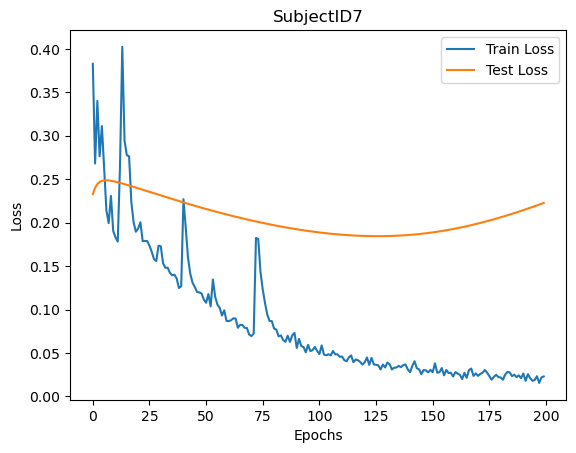

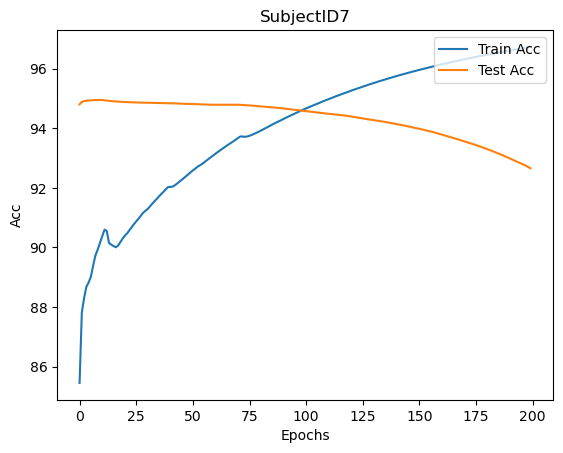


Subject 8
device: cuda
| epoch   0 | 0.8423 s/epoch | train loss 0.3688
| epoch   1 | 0.7790 s/epoch | train loss 0.2873
| epoch   2 | 0.7602 s/epoch | train loss 0.2610
| epoch   3 | 0.8114 s/epoch | train loss 0.2706
| epoch   4 | 0.7909 s/epoch | train loss 0.5107
| epoch   5 | 0.7496 s/epoch | train loss 0.3580
| epoch   6 | 0.7819 s/epoch | train loss 0.3124
| epoch   7 | 0.7822 s/epoch | train loss 0.2817
| epoch   8 | 0.7884 s/epoch | train loss 0.3306
| epoch   9 | 0.8015 s/epoch | train loss 0.3095
| epoch  10 | 0.8235 s/epoch | train loss 0.2795
| epoch  11 | 0.8203 s/epoch | train loss 0.3381
| epoch  12 | 0.8105 s/epoch | train loss 0.3158
| epoch  13 | 0.8318 s/epoch | train loss 0.2799
| epoch  14 | 0.8266 s/epoch | train loss 0.2777
| epoch  15 | 0.8010 s/epoch | train loss 0.2492
| epoch  16 | 0.8020 s/epoch | train loss 0.2411
| epoch  17 | 0.8469 s/epoch | train loss 0.2256
| epoch  18 | 0.8311 s/epoch | train loss 0.2448
| epoch  19 | 0.7960 s/epoch | train loss 0.2

| epoch 167 | 0.6953 s/epoch | train loss 0.0255
| epoch 168 | 0.6905 s/epoch | train loss 0.0210
| epoch 169 | 0.6869 s/epoch | train loss 0.0214
| epoch 170 | 0.6963 s/epoch | train loss 0.0258
| epoch 171 | 0.6927 s/epoch | train loss 0.0182
| epoch 172 | 0.6871 s/epoch | train loss 0.0356
| epoch 173 | 0.6807 s/epoch | train loss 0.0217
| epoch 174 | 0.6911 s/epoch | train loss 0.0197
| epoch 175 | 0.6933 s/epoch | train loss 0.0158
| epoch 176 | 0.6749 s/epoch | train loss 0.0214
| epoch 177 | 0.6841 s/epoch | train loss 0.0200
| epoch 178 | 0.6861 s/epoch | train loss 0.0210
| epoch 179 | 0.6941 s/epoch | train loss 0.0210
| epoch 180 | 0.6967 s/epoch | train loss 0.0188
| epoch 181 | 0.6928 s/epoch | train loss 0.0174
| epoch 182 | 0.6997 s/epoch | train loss 0.0249
| epoch 183 | 0.6982 s/epoch | train loss 0.0207
| epoch 184 | 0.6997 s/epoch | train loss 0.0203
| epoch 185 | 0.6955 s/epoch | train loss 0.0231
| epoch 186 | 0.7010 s/epoch | train loss 0.0198
| epoch 187 | 0.6939

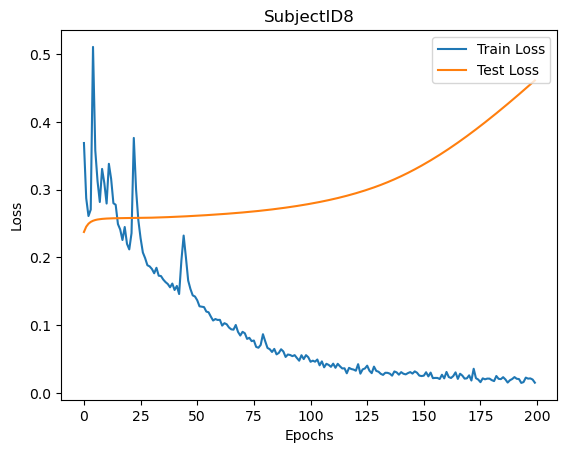

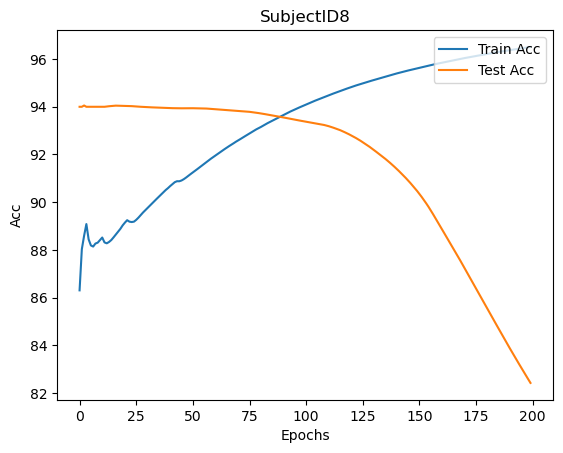

| epoch   0 | 0.6848 s/epoch | train loss 0.3813
| epoch   1 | 0.6897 s/epoch | train loss 0.3251
| epoch   2 | 0.6930 s/epoch | train loss 0.3776
| epoch   3 | 0.6942 s/epoch | train loss 0.2560
| epoch   4 | 0.6899 s/epoch | train loss 0.2135
| epoch   5 | 0.6865 s/epoch | train loss 0.2100
| epoch   6 | 0.6906 s/epoch | train loss 0.1916
| epoch   7 | 0.6959 s/epoch | train loss 0.1861
| epoch   8 | 0.6888 s/epoch | train loss 0.1780
| epoch   9 | 0.6903 s/epoch | train loss 0.1727
| epoch  10 | 0.6858 s/epoch | train loss 0.1670
| epoch  11 | 0.6865 s/epoch | train loss 0.1666
| epoch  12 | 0.6907 s/epoch | train loss 0.1721
| epoch  13 | 0.6842 s/epoch | train loss 0.1612
| epoch  14 | 0.6861 s/epoch | train loss 0.1721
| epoch  15 | 0.6868 s/epoch | train loss 0.2366
| epoch  16 | 0.6826 s/epoch | train loss 0.2208
| epoch  17 | 0.6907 s/epoch | train loss 0.2038
| epoch  18 | 0.6699 s/epoch | train loss 0.2748
| epoch  19 | 0.6823 s/epoch | train loss 0.2670
| epoch  20 | 0.6817

| epoch 168 | 0.6928 s/epoch | train loss 0.0236
| epoch 169 | 0.6823 s/epoch | train loss 0.0247
| epoch 170 | 0.6961 s/epoch | train loss 0.0241
| epoch 171 | 0.6940 s/epoch | train loss 0.0287
| epoch 172 | 0.6938 s/epoch | train loss 0.0252
| epoch 173 | 0.6975 s/epoch | train loss 0.0252
| epoch 174 | 0.7117 s/epoch | train loss 0.0259
| epoch 175 | 0.7102 s/epoch | train loss 0.0186
| epoch 176 | 0.7526 s/epoch | train loss 0.0224
| epoch 177 | 0.7370 s/epoch | train loss 0.0240
| epoch 178 | 0.6856 s/epoch | train loss 0.0204
| epoch 179 | 0.8149 s/epoch | train loss 0.0210
| epoch 180 | 0.7473 s/epoch | train loss 0.0177
| epoch 181 | 0.6938 s/epoch | train loss 0.0234
| epoch 182 | 0.6978 s/epoch | train loss 0.0241
| epoch 183 | 0.6907 s/epoch | train loss 0.0243
| epoch 184 | 0.6811 s/epoch | train loss 0.0189
| epoch 185 | 0.6968 s/epoch | train loss 0.0257
| epoch 186 | 0.6943 s/epoch | train loss 0.0181
| epoch 187 | 0.6928 s/epoch | train loss 0.0175
| epoch 188 | 0.6944

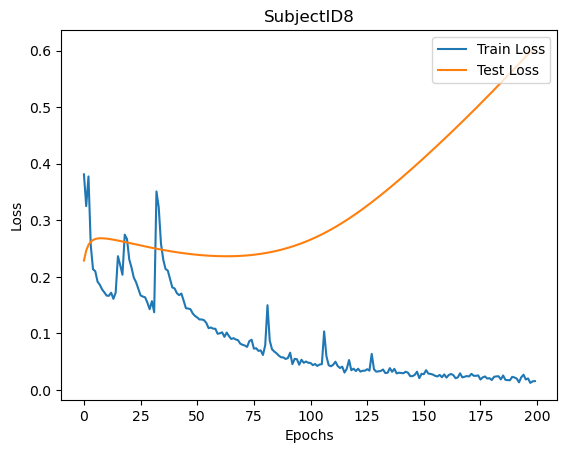

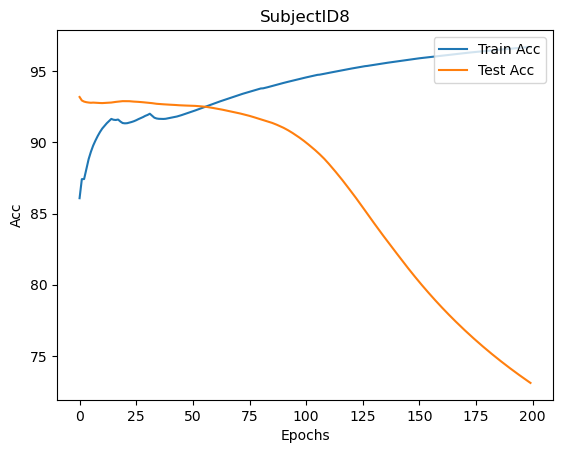


Subject 9
device: cuda
| epoch   0 | 0.7274 s/epoch | train loss 0.3345
| epoch   1 | 0.7762 s/epoch | train loss 0.2399
| epoch   2 | 0.7130 s/epoch | train loss 0.2151
| epoch   3 | 0.8563 s/epoch | train loss 0.2125
| epoch   4 | 0.7098 s/epoch | train loss 0.2055
| epoch   5 | 0.8046 s/epoch | train loss 0.1889
| epoch   6 | 0.9025 s/epoch | train loss 0.1884
| epoch   7 | 0.9662 s/epoch | train loss 0.1782
| epoch   8 | 0.8289 s/epoch | train loss 0.1752
| epoch   9 | 0.7139 s/epoch | train loss 0.1656
| epoch  10 | 0.9671 s/epoch | train loss 0.1675
| epoch  11 | 0.9740 s/epoch | train loss 0.1586
| epoch  12 | 0.7302 s/epoch | train loss 0.6156
| epoch  13 | 0.7062 s/epoch | train loss 0.3771
| epoch  14 | 0.6835 s/epoch | train loss 0.3418
| epoch  15 | 0.6954 s/epoch | train loss 0.2914
| epoch  16 | 0.6916 s/epoch | train loss 0.2795
| epoch  17 | 0.6964 s/epoch | train loss 0.3341
| epoch  18 | 0.6934 s/epoch | train loss 0.2616
| epoch  19 | 0.6959 s/epoch | train loss 0.2

| epoch 167 | 0.6943 s/epoch | train loss 0.0432
| epoch 168 | 0.6832 s/epoch | train loss 0.0338
| epoch 169 | 0.6996 s/epoch | train loss 0.0390
| epoch 170 | 0.6917 s/epoch | train loss 0.0307
| epoch 171 | 0.6988 s/epoch | train loss 0.0322
| epoch 172 | 0.6912 s/epoch | train loss 0.0370
| epoch 173 | 0.6945 s/epoch | train loss 0.0333
| epoch 174 | 0.6926 s/epoch | train loss 0.0418
| epoch 175 | 0.6915 s/epoch | train loss 0.0353
| epoch 176 | 0.6807 s/epoch | train loss 0.0303
| epoch 177 | 0.6830 s/epoch | train loss 0.0346
| epoch 178 | 0.6881 s/epoch | train loss 0.0334
| epoch 179 | 0.6893 s/epoch | train loss 0.0290
| epoch 180 | 0.6876 s/epoch | train loss 0.0299
| epoch 181 | 0.6853 s/epoch | train loss 0.0315
| epoch 182 | 0.6874 s/epoch | train loss 0.0327
| epoch 183 | 0.6892 s/epoch | train loss 0.0325
| epoch 184 | 0.6966 s/epoch | train loss 0.0258
| epoch 185 | 0.6832 s/epoch | train loss 0.0282
| epoch 186 | 0.6870 s/epoch | train loss 0.0372
| epoch 187 | 0.6958

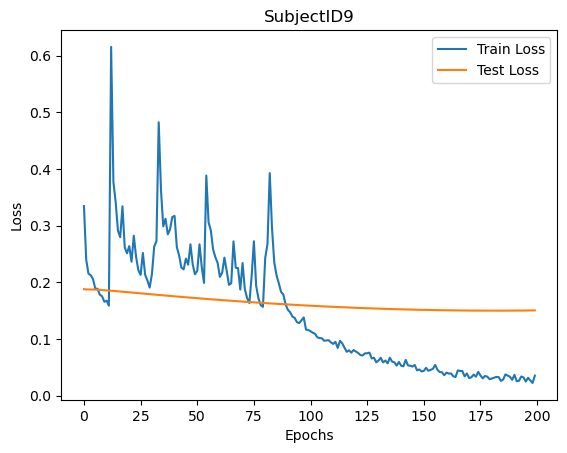

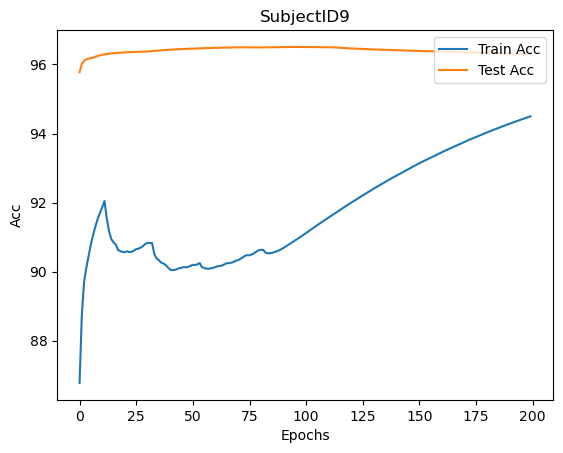

| epoch   0 | 0.6934 s/epoch | train loss 0.3406
| epoch   1 | 0.6978 s/epoch | train loss 0.2551
| epoch   2 | 0.6914 s/epoch | train loss 0.2178
| epoch   3 | 0.6944 s/epoch | train loss 0.2235
| epoch   4 | 0.6939 s/epoch | train loss 0.2119
| epoch   5 | 0.7169 s/epoch | train loss 0.1924
| epoch   6 | 0.7239 s/epoch | train loss 0.2367
| epoch   7 | 0.6340 s/epoch | train loss 0.2100
| epoch   8 | 0.6612 s/epoch | train loss 0.1804
| epoch   9 | 0.6539 s/epoch | train loss 0.1762
| epoch  10 | 0.6759 s/epoch | train loss 0.1844
| epoch  11 | 0.8612 s/epoch | train loss 0.1634
| epoch  12 | 0.7742 s/epoch | train loss 0.1562
| epoch  13 | 0.8146 s/epoch | train loss 0.1546
| epoch  14 | 0.7883 s/epoch | train loss 0.1479
| epoch  15 | 0.7744 s/epoch | train loss 0.1495
| epoch  16 | 0.7775 s/epoch | train loss 0.1406
| epoch  17 | 0.7862 s/epoch | train loss 0.1435
| epoch  18 | 0.7767 s/epoch | train loss 0.1565
| epoch  19 | 0.7869 s/epoch | train loss 0.1456
| epoch  20 | 0.7944

| epoch 168 | 0.7604 s/epoch | train loss 0.0212
| epoch 169 | 0.7766 s/epoch | train loss 0.0400
| epoch 170 | 0.7742 s/epoch | train loss 0.0176
| epoch 171 | 0.7609 s/epoch | train loss 0.0276
| epoch 172 | 0.7546 s/epoch | train loss 0.0201
| epoch 173 | 0.7358 s/epoch | train loss 0.0174
| epoch 174 | 0.7916 s/epoch | train loss 0.0216
| epoch 175 | 0.7719 s/epoch | train loss 0.0261
| epoch 176 | 0.7656 s/epoch | train loss 0.0192
| epoch 177 | 0.7791 s/epoch | train loss 0.0201
| epoch 178 | 0.7603 s/epoch | train loss 0.0228
| epoch 179 | 0.7394 s/epoch | train loss 0.0242
| epoch 180 | 0.8012 s/epoch | train loss 0.0229
| epoch 181 | 0.7878 s/epoch | train loss 0.0220
| epoch 182 | 0.8283 s/epoch | train loss 0.0191
| epoch 183 | 0.7905 s/epoch | train loss 0.0193
| epoch 184 | 0.7496 s/epoch | train loss 0.0411
| epoch 185 | 0.8570 s/epoch | train loss 0.0261
| epoch 186 | 0.8197 s/epoch | train loss 0.0170
| epoch 187 | 0.7685 s/epoch | train loss 0.0185
| epoch 188 | 0.7606

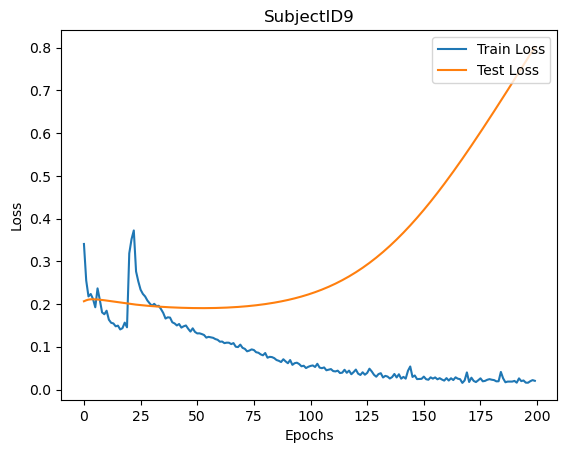

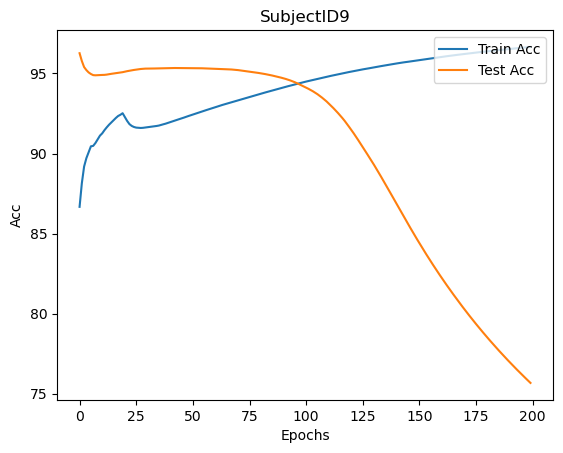


Subject 10
device: cuda
| epoch   0 | 0.8202 s/epoch | train loss 0.3855
| epoch   1 | 0.8517 s/epoch | train loss 0.3158
| epoch   2 | 0.7907 s/epoch | train loss 0.3415
| epoch   3 | 0.8018 s/epoch | train loss 0.4515
| epoch   4 | 0.8286 s/epoch | train loss 0.3476
| epoch   5 | 0.8554 s/epoch | train loss 0.2859
| epoch   6 | 0.8331 s/epoch | train loss 0.3008
| epoch   7 | 0.8498 s/epoch | train loss 0.3027
| epoch   8 | 0.8430 s/epoch | train loss 0.2865
| epoch   9 | 0.8518 s/epoch | train loss 0.2504
| epoch  10 | 0.7897 s/epoch | train loss 0.2419
| epoch  11 | 0.8130 s/epoch | train loss 0.2315
| epoch  12 | 0.8255 s/epoch | train loss 0.2210
| epoch  13 | 0.8101 s/epoch | train loss 0.2886
| epoch  14 | 0.6973 s/epoch | train loss 0.2300
| epoch  15 | 0.6671 s/epoch | train loss 0.2178
| epoch  16 | 0.6857 s/epoch | train loss 0.2468
| epoch  17 | 0.6554 s/epoch | train loss 0.2157
| epoch  18 | 0.6624 s/epoch | train loss 0.2426
| epoch  19 | 0.6589 s/epoch | train loss 0.

| epoch 167 | 0.6896 s/epoch | train loss 0.0201
| epoch 168 | 0.6917 s/epoch | train loss 0.0302
| epoch 169 | 0.6945 s/epoch | train loss 0.0243
| epoch 170 | 0.6793 s/epoch | train loss 0.0258
| epoch 171 | 0.6890 s/epoch | train loss 0.0308
| epoch 172 | 0.6988 s/epoch | train loss 0.0209
| epoch 173 | 0.6892 s/epoch | train loss 0.0252
| epoch 174 | 0.6911 s/epoch | train loss 0.0212
| epoch 175 | 0.6902 s/epoch | train loss 0.0218
| epoch 176 | 0.6936 s/epoch | train loss 0.0243
| epoch 177 | 0.6897 s/epoch | train loss 0.0259
| epoch 178 | 0.6889 s/epoch | train loss 0.0226
| epoch 179 | 0.6879 s/epoch | train loss 0.0347
| epoch 180 | 0.6925 s/epoch | train loss 0.0234
| epoch 181 | 0.6966 s/epoch | train loss 0.0208
| epoch 182 | 0.6940 s/epoch | train loss 0.0172
| epoch 183 | 0.6888 s/epoch | train loss 0.0356
| epoch 184 | 0.6932 s/epoch | train loss 0.0275
| epoch 185 | 0.6868 s/epoch | train loss 0.0331
| epoch 186 | 0.6877 s/epoch | train loss 0.0226
| epoch 187 | 0.6877

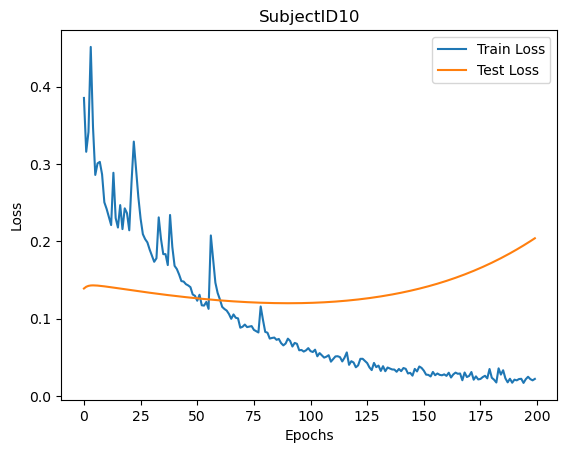

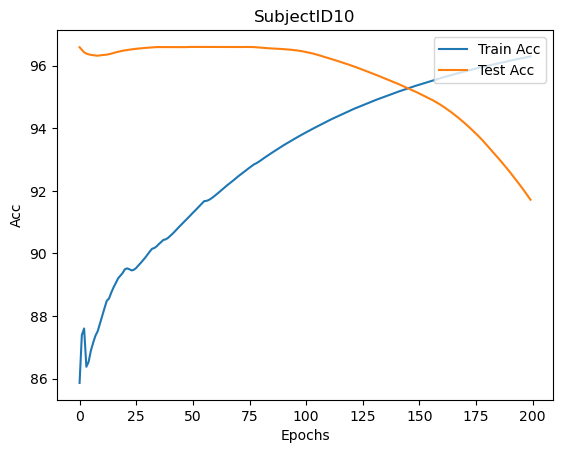

| epoch   0 | 0.6792 s/epoch | train loss 0.3947
| epoch   1 | 0.6843 s/epoch | train loss 0.2916
| epoch   2 | 0.6830 s/epoch | train loss 0.2888
| epoch   3 | 0.6787 s/epoch | train loss 0.2760
| epoch   4 | 0.6752 s/epoch | train loss 0.2899
| epoch   5 | 0.6765 s/epoch | train loss 0.3412
| epoch   6 | 0.6814 s/epoch | train loss 0.2622
| epoch   7 | 0.6827 s/epoch | train loss 0.2234
| epoch   8 | 0.6845 s/epoch | train loss 0.2102
| epoch   9 | 0.6886 s/epoch | train loss 0.2050
| epoch  10 | 0.6847 s/epoch | train loss 0.1974
| epoch  11 | 0.6797 s/epoch | train loss 0.1844
| epoch  12 | 0.6801 s/epoch | train loss 0.1790
| epoch  13 | 0.6860 s/epoch | train loss 0.1780
| epoch  14 | 0.6869 s/epoch | train loss 0.1730
| epoch  15 | 0.6869 s/epoch | train loss 0.1721
| epoch  16 | 0.6821 s/epoch | train loss 0.1680
| epoch  17 | 0.6909 s/epoch | train loss 0.1655
| epoch  18 | 0.6866 s/epoch | train loss 0.1726
| epoch  19 | 0.6816 s/epoch | train loss 0.1802
| epoch  20 | 0.6834

| epoch 168 | 0.6877 s/epoch | train loss 0.0190
| epoch 169 | 0.6909 s/epoch | train loss 0.0301
| epoch 170 | 0.6894 s/epoch | train loss 0.0280
| epoch 171 | 0.6952 s/epoch | train loss 0.0230
| epoch 172 | 0.6884 s/epoch | train loss 0.0237
| epoch 173 | 0.6914 s/epoch | train loss 0.0204
| epoch 174 | 0.6943 s/epoch | train loss 0.0237
| epoch 175 | 0.6908 s/epoch | train loss 0.0246
| epoch 176 | 0.6911 s/epoch | train loss 0.0240
| epoch 177 | 0.6925 s/epoch | train loss 0.0176
| epoch 178 | 0.6921 s/epoch | train loss 0.0182
| epoch 179 | 0.6842 s/epoch | train loss 0.0221
| epoch 180 | 0.6909 s/epoch | train loss 0.0274
| epoch 181 | 0.6785 s/epoch | train loss 0.0194
| epoch 182 | 0.6909 s/epoch | train loss 0.0216
| epoch 183 | 0.6943 s/epoch | train loss 0.0206
| epoch 184 | 0.6881 s/epoch | train loss 0.0234
| epoch 185 | 0.6861 s/epoch | train loss 0.0235
| epoch 186 | 0.6936 s/epoch | train loss 0.0194
| epoch 187 | 0.6971 s/epoch | train loss 0.0157
| epoch 188 | 0.6950

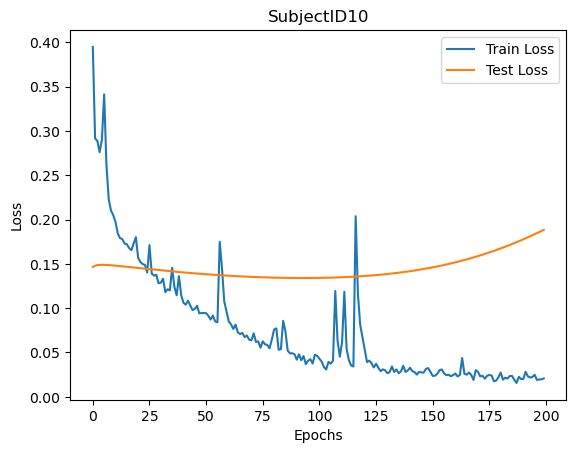

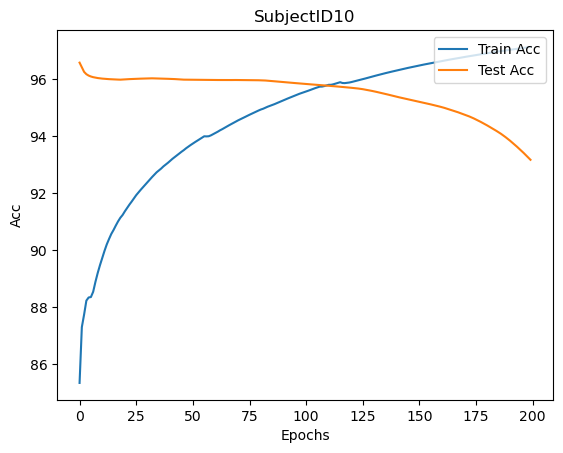


Subject 11
device: cuda
| epoch   0 | 0.6926 s/epoch | train loss 0.4000
| epoch   1 | 0.6879 s/epoch | train loss 0.2934
| epoch   2 | 0.6871 s/epoch | train loss 0.2512
| epoch   3 | 0.6907 s/epoch | train loss 0.2704
| epoch   4 | 0.6914 s/epoch | train loss 0.3794
| epoch   5 | 0.6924 s/epoch | train loss 0.2780
| epoch   6 | 0.6866 s/epoch | train loss 0.2444
| epoch   7 | 0.6773 s/epoch | train loss 0.2275
| epoch   8 | 0.6879 s/epoch | train loss 0.2125
| epoch   9 | 0.6826 s/epoch | train loss 0.2015
| epoch  10 | 0.6793 s/epoch | train loss 0.1959
| epoch  11 | 0.6814 s/epoch | train loss 0.1878
| epoch  12 | 0.6842 s/epoch | train loss 0.1840
| epoch  13 | 0.6797 s/epoch | train loss 0.3235
| epoch  14 | 0.6854 s/epoch | train loss 0.2453
| epoch  15 | 0.6941 s/epoch | train loss 0.2231
| epoch  16 | 0.6925 s/epoch | train loss 0.2091
| epoch  17 | 0.6955 s/epoch | train loss 0.1930
| epoch  18 | 0.6877 s/epoch | train loss 0.1859
| epoch  19 | 0.6853 s/epoch | train loss 0.

| epoch 167 | 0.6948 s/epoch | train loss 0.0435
| epoch 168 | 0.6876 s/epoch | train loss 0.0233
| epoch 169 | 0.6926 s/epoch | train loss 0.0189
| epoch 170 | 0.6969 s/epoch | train loss 0.0233
| epoch 171 | 0.6921 s/epoch | train loss 0.0226
| epoch 172 | 0.6954 s/epoch | train loss 0.0230
| epoch 173 | 0.6944 s/epoch | train loss 0.0226
| epoch 174 | 0.6893 s/epoch | train loss 0.0229
| epoch 175 | 0.6952 s/epoch | train loss 0.0207
| epoch 176 | 0.6852 s/epoch | train loss 0.0267
| epoch 177 | 0.6884 s/epoch | train loss 0.0200
| epoch 178 | 0.6928 s/epoch | train loss 0.0252
| epoch 179 | 0.6977 s/epoch | train loss 0.0180
| epoch 180 | 0.6897 s/epoch | train loss 0.0205
| epoch 181 | 0.6945 s/epoch | train loss 0.0242
| epoch 182 | 0.6949 s/epoch | train loss 0.0196
| epoch 183 | 0.6894 s/epoch | train loss 0.0235
| epoch 184 | 0.6942 s/epoch | train loss 0.0207
| epoch 185 | 0.6889 s/epoch | train loss 0.0305
| epoch 186 | 0.6885 s/epoch | train loss 0.0216
| epoch 187 | 0.6876

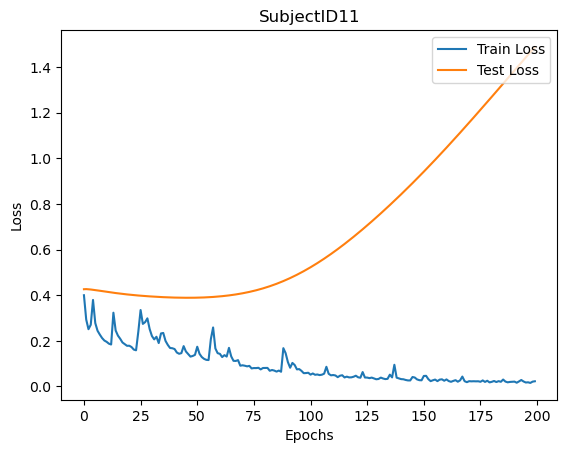

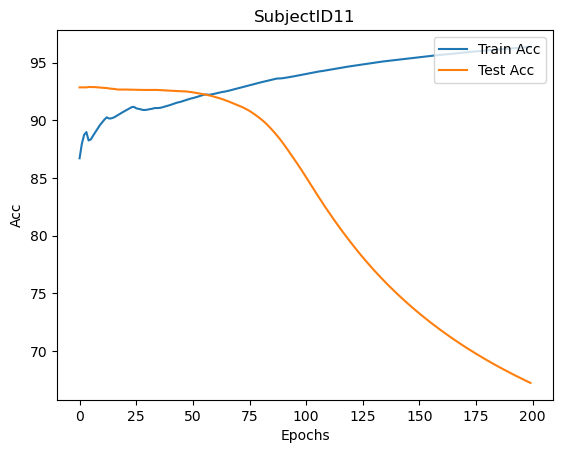

| epoch   0 | 0.6913 s/epoch | train loss 0.4266
| epoch   1 | 0.6923 s/epoch | train loss 0.3052
| epoch   2 | 0.6973 s/epoch | train loss 0.3664
| epoch   3 | 0.6805 s/epoch | train loss 0.3150
| epoch   4 | 0.6863 s/epoch | train loss 0.3360
| epoch   5 | 0.6934 s/epoch | train loss 0.3845
| epoch   6 | 0.6918 s/epoch | train loss 0.2939
| epoch   7 | 0.6777 s/epoch | train loss 0.2718
| epoch   8 | 0.6868 s/epoch | train loss 0.2703
| epoch   9 | 0.6905 s/epoch | train loss 0.2395
| epoch  10 | 0.6841 s/epoch | train loss 0.2685
| epoch  11 | 0.6890 s/epoch | train loss 0.2299
| epoch  12 | 0.6799 s/epoch | train loss 0.2323
| epoch  13 | 0.6867 s/epoch | train loss 0.2307
| epoch  14 | 0.6792 s/epoch | train loss 0.3674
| epoch  15 | 0.6761 s/epoch | train loss 0.3335
| epoch  16 | 0.6815 s/epoch | train loss 0.2767
| epoch  17 | 0.6933 s/epoch | train loss 0.2285
| epoch  18 | 0.6890 s/epoch | train loss 0.2256
| epoch  19 | 0.6803 s/epoch | train loss 0.2067
| epoch  20 | 0.6901

| epoch 168 | 0.6958 s/epoch | train loss 0.0282
| epoch 169 | 0.6959 s/epoch | train loss 0.0268
| epoch 170 | 0.6899 s/epoch | train loss 0.0273
| epoch 171 | 0.6922 s/epoch | train loss 0.0218
| epoch 172 | 0.6918 s/epoch | train loss 0.0270
| epoch 173 | 0.6934 s/epoch | train loss 0.0225
| epoch 174 | 0.6835 s/epoch | train loss 0.0250
| epoch 175 | 0.6902 s/epoch | train loss 0.0252
| epoch 176 | 0.6927 s/epoch | train loss 0.0253
| epoch 177 | 0.6928 s/epoch | train loss 0.0251
| epoch 178 | 0.6894 s/epoch | train loss 0.0229
| epoch 179 | 0.6914 s/epoch | train loss 0.0284
| epoch 180 | 0.6914 s/epoch | train loss 0.0279
| epoch 181 | 0.6827 s/epoch | train loss 0.0209
| epoch 182 | 0.6859 s/epoch | train loss 0.0224
| epoch 183 | 0.6883 s/epoch | train loss 0.0210
| epoch 184 | 0.6895 s/epoch | train loss 0.0251
| epoch 185 | 0.6910 s/epoch | train loss 0.0249
| epoch 186 | 0.6941 s/epoch | train loss 0.0250
| epoch 187 | 0.6879 s/epoch | train loss 0.0212
| epoch 188 | 0.6893

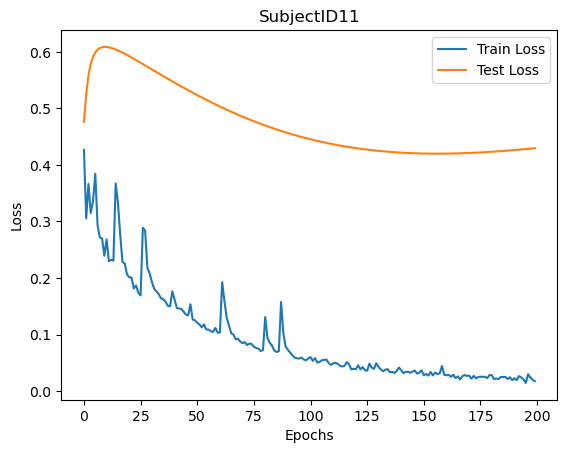

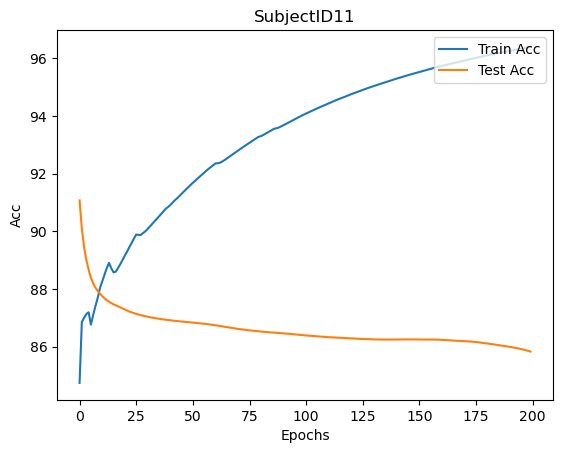


Subject 12
device: cuda
| epoch   0 | 0.6852 s/epoch | train loss 0.3715
| epoch   1 | 0.6943 s/epoch | train loss 0.2564
| epoch   2 | 0.6896 s/epoch | train loss 0.2388
| epoch   3 | 0.6903 s/epoch | train loss 0.2135
| epoch   4 | 0.6923 s/epoch | train loss 0.2099
| epoch   5 | 0.6866 s/epoch | train loss 0.1969
| epoch   6 | 0.6925 s/epoch | train loss 0.1889
| epoch   7 | 0.6882 s/epoch | train loss 0.1850
| epoch   8 | 0.6956 s/epoch | train loss 0.1924
| epoch   9 | 0.6894 s/epoch | train loss 0.1802
| epoch  10 | 0.6936 s/epoch | train loss 0.1716
| epoch  11 | 0.6859 s/epoch | train loss 0.1653
| epoch  12 | 0.6792 s/epoch | train loss 0.1655
| epoch  13 | 0.6875 s/epoch | train loss 0.1598
| epoch  14 | 0.6938 s/epoch | train loss 0.1592
| epoch  15 | 0.6933 s/epoch | train loss 0.1468
| epoch  16 | 0.6793 s/epoch | train loss 0.1474
| epoch  17 | 0.6863 s/epoch | train loss 0.1488
| epoch  18 | 0.6863 s/epoch | train loss 0.1479
| epoch  19 | 0.6831 s/epoch | train loss 0.

| epoch 167 | 0.8179 s/epoch | train loss 0.0210
| epoch 168 | 0.7961 s/epoch | train loss 0.0234
| epoch 169 | 0.7672 s/epoch | train loss 0.0235
| epoch 170 | 0.8175 s/epoch | train loss 0.0234
| epoch 171 | 0.8023 s/epoch | train loss 0.0213
| epoch 172 | 0.8190 s/epoch | train loss 0.0207
| epoch 173 | 0.7589 s/epoch | train loss 0.0213
| epoch 174 | 0.7798 s/epoch | train loss 0.0203
| epoch 175 | 0.8546 s/epoch | train loss 0.0336
| epoch 176 | 0.8383 s/epoch | train loss 0.0244
| epoch 177 | 0.8386 s/epoch | train loss 0.0250
| epoch 178 | 0.7807 s/epoch | train loss 0.0192
| epoch 179 | 0.8306 s/epoch | train loss 0.0197
| epoch 180 | 0.8333 s/epoch | train loss 0.0178
| epoch 181 | 0.7817 s/epoch | train loss 0.0255
| epoch 182 | 0.7616 s/epoch | train loss 0.0204
| epoch 183 | 0.7721 s/epoch | train loss 0.0192
| epoch 184 | 0.7136 s/epoch | train loss 0.0171
| epoch 185 | 0.7930 s/epoch | train loss 0.0186
| epoch 186 | 0.7603 s/epoch | train loss 0.0204
| epoch 187 | 0.8258

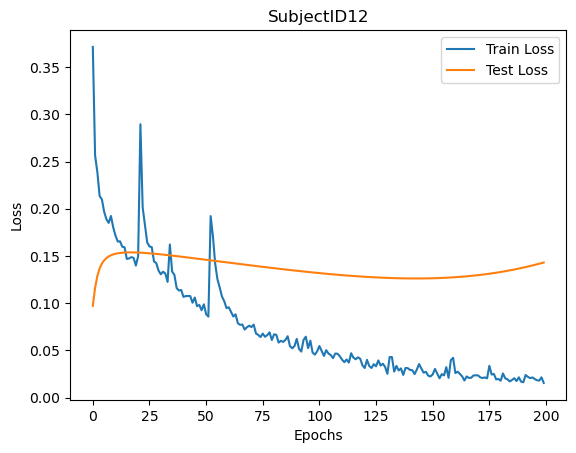

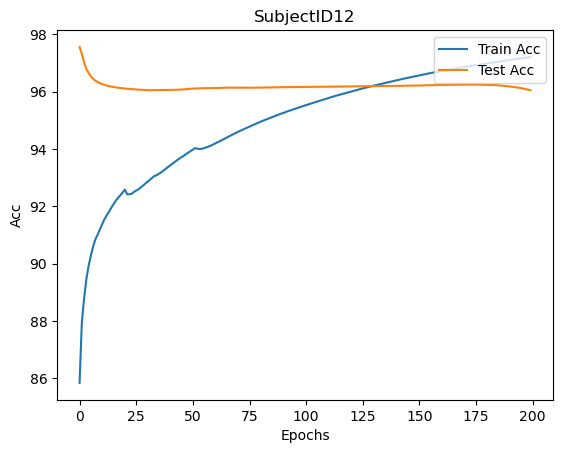

| epoch   0 | 0.6845 s/epoch | train loss 0.3710
| epoch   1 | 0.6944 s/epoch | train loss 0.2741
| epoch   2 | 0.7094 s/epoch | train loss 0.3061
| epoch   3 | 0.6931 s/epoch | train loss 0.3250
| epoch   4 | 0.7235 s/epoch | train loss 0.3120
| epoch   5 | 0.7090 s/epoch | train loss 0.2700
| epoch   6 | 0.7189 s/epoch | train loss 0.2417
| epoch   7 | 0.7154 s/epoch | train loss 0.2576
| epoch   8 | 0.7045 s/epoch | train loss 0.4104
| epoch   9 | 0.7094 s/epoch | train loss 0.2749
| epoch  10 | 0.7046 s/epoch | train loss 0.2513
| epoch  11 | 0.7117 s/epoch | train loss 0.2273
| epoch  12 | 0.7095 s/epoch | train loss 0.2174
| epoch  13 | 0.6999 s/epoch | train loss 0.2053
| epoch  14 | 0.7089 s/epoch | train loss 0.2037
| epoch  15 | 0.6956 s/epoch | train loss 0.1960
| epoch  16 | 0.6941 s/epoch | train loss 0.1867
| epoch  17 | 0.7028 s/epoch | train loss 0.2365
| epoch  18 | 0.7001 s/epoch | train loss 0.2032
| epoch  19 | 0.6915 s/epoch | train loss 0.1897
| epoch  20 | 0.6981

| epoch 168 | 0.6947 s/epoch | train loss 0.0670
| epoch 169 | 0.6937 s/epoch | train loss 0.0426
| epoch 170 | 0.6891 s/epoch | train loss 0.0285
| epoch 171 | 0.7102 s/epoch | train loss 0.0241
| epoch 172 | 0.6961 s/epoch | train loss 0.0201
| epoch 173 | 0.7069 s/epoch | train loss 0.0259
| epoch 174 | 0.6984 s/epoch | train loss 0.0162
| epoch 175 | 0.6965 s/epoch | train loss 0.0182
| epoch 176 | 0.7111 s/epoch | train loss 0.0244
| epoch 177 | 0.7266 s/epoch | train loss 0.0211
| epoch 178 | 0.7229 s/epoch | train loss 0.0158
| epoch 179 | 0.7454 s/epoch | train loss 0.0249
| epoch 180 | 0.7176 s/epoch | train loss 0.0228
| epoch 181 | 0.7158 s/epoch | train loss 0.0195
| epoch 182 | 0.7114 s/epoch | train loss 0.0219
| epoch 183 | 0.7330 s/epoch | train loss 0.0160
| epoch 184 | 0.7157 s/epoch | train loss 0.0239
| epoch 185 | 0.7366 s/epoch | train loss 0.0272
| epoch 186 | 0.7234 s/epoch | train loss 0.0221
| epoch 187 | 0.7236 s/epoch | train loss 0.0229
| epoch 188 | 0.7412

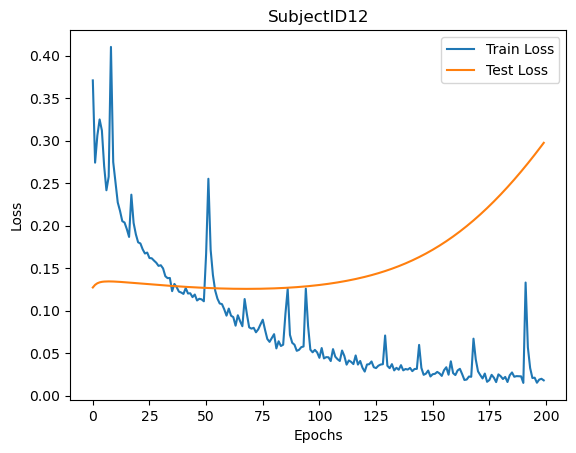

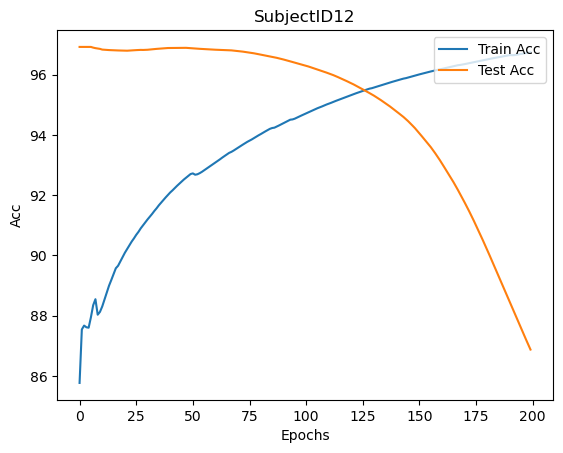


Subject 13
device: cuda
| epoch   0 | 0.6924 s/epoch | train loss 0.3957
| epoch   1 | 0.6797 s/epoch | train loss 0.2786
| epoch   2 | 0.6790 s/epoch | train loss 0.3307
| epoch   3 | 0.6904 s/epoch | train loss 0.3025
| epoch   4 | 0.6918 s/epoch | train loss 0.3529
| epoch   5 | 0.6868 s/epoch | train loss 0.2816
| epoch   6 | 0.6832 s/epoch | train loss 0.2597
| epoch   7 | 0.6914 s/epoch | train loss 0.2349
| epoch   8 | 0.6940 s/epoch | train loss 0.2219
| epoch   9 | 0.6921 s/epoch | train loss 0.2143
| epoch  10 | 0.6924 s/epoch | train loss 0.2390
| epoch  11 | 0.6919 s/epoch | train loss 0.2059
| epoch  12 | 0.6861 s/epoch | train loss 0.2359
| epoch  13 | 0.6887 s/epoch | train loss 0.3346
| epoch  14 | 0.6865 s/epoch | train loss 0.2544
| epoch  15 | 0.6861 s/epoch | train loss 0.2385
| epoch  16 | 0.6964 s/epoch | train loss 0.2583
| epoch  17 | 0.6869 s/epoch | train loss 0.2663
| epoch  18 | 0.6966 s/epoch | train loss 0.2466
| epoch  19 | 0.6925 s/epoch | train loss 0.

| epoch 167 | 0.6988 s/epoch | train loss 0.0279
| epoch 168 | 0.6992 s/epoch | train loss 0.0369
| epoch 169 | 0.6978 s/epoch | train loss 0.0222
| epoch 170 | 0.6953 s/epoch | train loss 0.0238
| epoch 171 | 0.6939 s/epoch | train loss 0.0188
| epoch 172 | 0.6913 s/epoch | train loss 0.0267
| epoch 173 | 0.6933 s/epoch | train loss 0.0298
| epoch 174 | 0.6934 s/epoch | train loss 0.0251
| epoch 175 | 0.6948 s/epoch | train loss 0.0291
| epoch 176 | 0.6940 s/epoch | train loss 0.0212
| epoch 177 | 0.6899 s/epoch | train loss 0.0207
| epoch 178 | 0.6982 s/epoch | train loss 0.0192
| epoch 179 | 0.6906 s/epoch | train loss 0.0201
| epoch 180 | 0.6983 s/epoch | train loss 0.0347
| epoch 181 | 0.6965 s/epoch | train loss 0.0265
| epoch 182 | 0.6991 s/epoch | train loss 0.0194
| epoch 183 | 0.6978 s/epoch | train loss 0.0240
| epoch 184 | 0.6975 s/epoch | train loss 0.0155
| epoch 185 | 0.6914 s/epoch | train loss 0.0260
| epoch 186 | 0.6984 s/epoch | train loss 0.0228
| epoch 187 | 0.6936

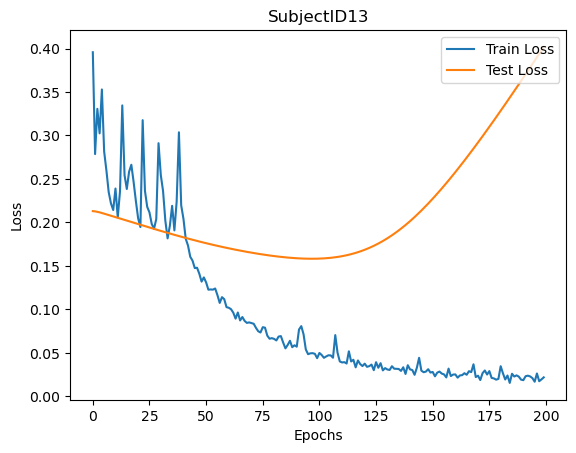

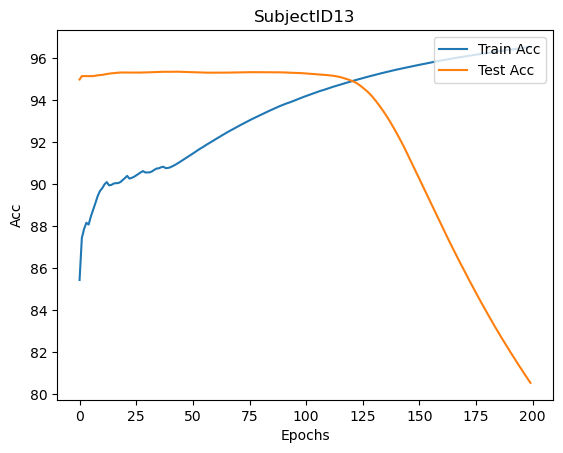

| epoch   0 | 0.7004 s/epoch | train loss 0.4030
| epoch   1 | 0.6928 s/epoch | train loss 0.3181
| epoch   2 | 0.6801 s/epoch | train loss 0.3268
| epoch   3 | 0.6848 s/epoch | train loss 0.4003
| epoch   4 | 0.6927 s/epoch | train loss 0.3574
| epoch   5 | 0.6970 s/epoch | train loss 0.2815
| epoch   6 | 0.6878 s/epoch | train loss 0.2967
| epoch   7 | 0.6877 s/epoch | train loss 0.3101
| epoch   8 | 0.6928 s/epoch | train loss 0.3076
| epoch   9 | 0.6902 s/epoch | train loss 0.2553
| epoch  10 | 0.6902 s/epoch | train loss 0.2347
| epoch  11 | 0.6884 s/epoch | train loss 0.2262
| epoch  12 | 0.6911 s/epoch | train loss 0.2441
| epoch  13 | 0.6908 s/epoch | train loss 0.2108
| epoch  14 | 0.6884 s/epoch | train loss 0.1936
| epoch  15 | 0.6899 s/epoch | train loss 0.1906
| epoch  16 | 0.6948 s/epoch | train loss 0.2034
| epoch  17 | 0.6951 s/epoch | train loss 0.1844
| epoch  18 | 0.6894 s/epoch | train loss 0.1679
| epoch  19 | 0.6944 s/epoch | train loss 0.1643
| epoch  20 | 0.6985

| epoch 168 | 0.6918 s/epoch | train loss 0.0306
| epoch 169 | 0.6916 s/epoch | train loss 0.0275
| epoch 170 | 0.6970 s/epoch | train loss 0.0247
| epoch 171 | 0.6902 s/epoch | train loss 0.1214
| epoch 172 | 0.6959 s/epoch | train loss 0.0494
| epoch 173 | 0.6863 s/epoch | train loss 0.0404
| epoch 174 | 0.6896 s/epoch | train loss 0.0337
| epoch 175 | 0.6971 s/epoch | train loss 0.0290
| epoch 176 | 0.6968 s/epoch | train loss 0.0284
| epoch 177 | 0.6942 s/epoch | train loss 0.0236
| epoch 178 | 0.6884 s/epoch | train loss 0.0212
| epoch 179 | 0.6920 s/epoch | train loss 0.0247
| epoch 180 | 0.6984 s/epoch | train loss 0.0240
| epoch 181 | 0.6927 s/epoch | train loss 0.0250
| epoch 182 | 0.6913 s/epoch | train loss 0.0153
| epoch 183 | 0.6783 s/epoch | train loss 0.0239
| epoch 184 | 0.6943 s/epoch | train loss 0.0282
| epoch 185 | 0.6924 s/epoch | train loss 0.0172
| epoch 186 | 0.6906 s/epoch | train loss 0.0210
| epoch 187 | 0.7008 s/epoch | train loss 0.0169
| epoch 188 | 0.6911

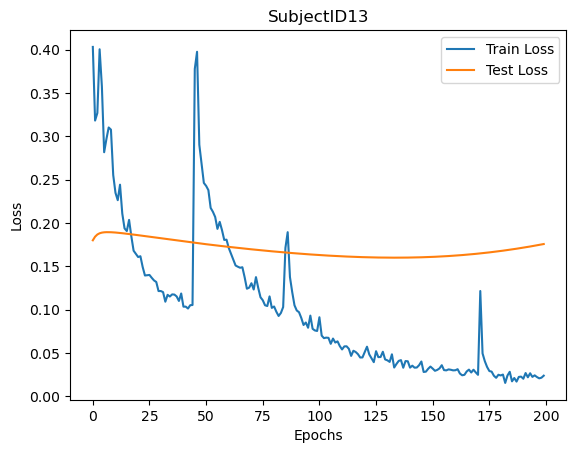

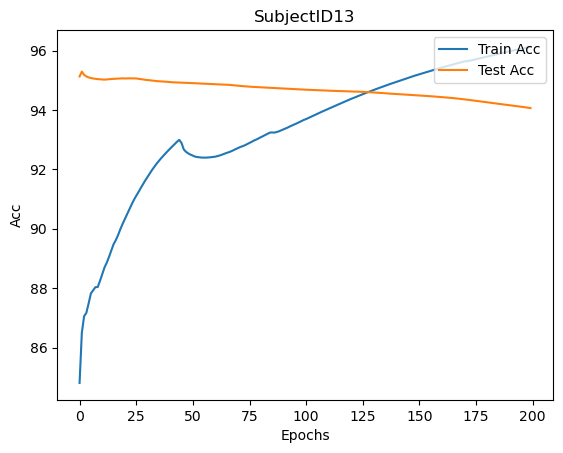


Subject 14
device: cuda
| epoch   0 | 0.6910 s/epoch | train loss 0.3795
| epoch   1 | 0.6904 s/epoch | train loss 0.3168
| epoch   2 | 0.6932 s/epoch | train loss 0.2976
| epoch   3 | 0.6769 s/epoch | train loss 0.3509
| epoch   4 | 0.6842 s/epoch | train loss 0.3030
| epoch   5 | 0.6911 s/epoch | train loss 0.3923
| epoch   6 | 0.6970 s/epoch | train loss 0.3323
| epoch   7 | 0.6821 s/epoch | train loss 0.2946
| epoch   8 | 0.6904 s/epoch | train loss 0.2701
| epoch   9 | 0.6931 s/epoch | train loss 0.2783
| epoch  10 | 0.6908 s/epoch | train loss 0.3210
| epoch  11 | 0.6931 s/epoch | train loss 0.2617
| epoch  12 | 0.6897 s/epoch | train loss 0.3198
| epoch  13 | 0.6875 s/epoch | train loss 0.3015
| epoch  14 | 0.6908 s/epoch | train loss 0.2611
| epoch  15 | 0.6857 s/epoch | train loss 0.2388
| epoch  16 | 0.6905 s/epoch | train loss 0.2150
| epoch  17 | 0.6907 s/epoch | train loss 0.2157
| epoch  18 | 0.6963 s/epoch | train loss 0.2025
| epoch  19 | 0.6928 s/epoch | train loss 0.

| epoch 167 | 0.6958 s/epoch | train loss 0.0215
| epoch 168 | 0.6900 s/epoch | train loss 0.0257
| epoch 169 | 0.6933 s/epoch | train loss 0.0201
| epoch 170 | 0.6935 s/epoch | train loss 0.0189
| epoch 171 | 0.6933 s/epoch | train loss 0.0219
| epoch 172 | 0.6916 s/epoch | train loss 0.0244
| epoch 173 | 0.6920 s/epoch | train loss 0.0207
| epoch 174 | 0.6946 s/epoch | train loss 0.0238
| epoch 175 | 0.6820 s/epoch | train loss 0.0272
| epoch 176 | 0.6954 s/epoch | train loss 0.0201
| epoch 177 | 0.6951 s/epoch | train loss 0.0157
| epoch 178 | 0.6979 s/epoch | train loss 0.0162
| epoch 179 | 0.6899 s/epoch | train loss 0.0257
| epoch 180 | 0.6904 s/epoch | train loss 0.0212
| epoch 181 | 0.6932 s/epoch | train loss 0.0196
| epoch 182 | 0.6908 s/epoch | train loss 0.0238
| epoch 183 | 0.6963 s/epoch | train loss 0.0237
| epoch 184 | 0.6916 s/epoch | train loss 0.0192
| epoch 185 | 0.6980 s/epoch | train loss 0.0191
| epoch 186 | 0.6907 s/epoch | train loss 0.0371
| epoch 187 | 0.6934

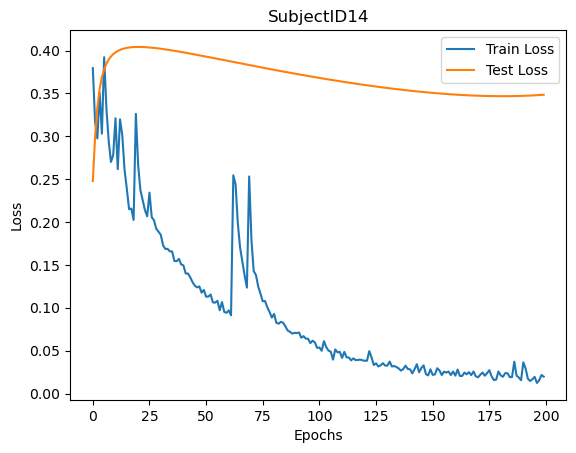

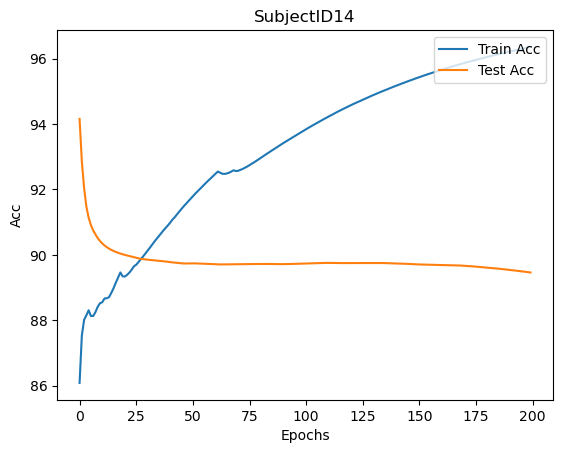

| epoch   0 | 0.6926 s/epoch | train loss 0.3502
| epoch   1 | 0.6879 s/epoch | train loss 0.2471
| epoch   2 | 0.6945 s/epoch | train loss 0.2219
| epoch   3 | 0.6935 s/epoch | train loss 0.2118
| epoch   4 | 0.6772 s/epoch | train loss 0.1933
| epoch   5 | 0.6810 s/epoch | train loss 0.1881
| epoch   6 | 0.6941 s/epoch | train loss 0.1810
| epoch   7 | 0.6902 s/epoch | train loss 0.1838
| epoch   8 | 0.6903 s/epoch | train loss 0.1676
| epoch   9 | 0.6878 s/epoch | train loss 0.1632
| epoch  10 | 0.6944 s/epoch | train loss 0.1647
| epoch  11 | 0.6892 s/epoch | train loss 0.1459
| epoch  12 | 0.6891 s/epoch | train loss 0.1499
| epoch  13 | 0.6921 s/epoch | train loss 0.1517
| epoch  14 | 0.6928 s/epoch | train loss 0.1393
| epoch  15 | 0.6980 s/epoch | train loss 0.1689
| epoch  16 | 0.6948 s/epoch | train loss 0.1450
| epoch  17 | 0.6787 s/epoch | train loss 0.1369
| epoch  18 | 0.6872 s/epoch | train loss 0.3380
| epoch  19 | 0.6954 s/epoch | train loss 0.3105
| epoch  20 | 0.6838

| epoch 168 | 0.8487 s/epoch | train loss 0.0163
| epoch 169 | 0.8328 s/epoch | train loss 0.0212
| epoch 170 | 0.8093 s/epoch | train loss 0.0165
| epoch 171 | 0.8021 s/epoch | train loss 0.0240
| epoch 172 | 0.7610 s/epoch | train loss 0.0217
| epoch 173 | 0.8329 s/epoch | train loss 0.0198
| epoch 174 | 0.8590 s/epoch | train loss 0.0164
| epoch 175 | 0.7964 s/epoch | train loss 0.0155
| epoch 176 | 0.8768 s/epoch | train loss 0.0203
| epoch 177 | 0.8064 s/epoch | train loss 0.0211
| epoch 178 | 0.8337 s/epoch | train loss 0.0165
| epoch 179 | 0.8407 s/epoch | train loss 0.0158
| epoch 180 | 0.8408 s/epoch | train loss 0.0126
| epoch 181 | 0.8231 s/epoch | train loss 0.0224
| epoch 182 | 0.8176 s/epoch | train loss 0.0185
| epoch 183 | 0.7927 s/epoch | train loss 0.0227
| epoch 184 | 0.7931 s/epoch | train loss 0.0210
| epoch 185 | 0.8095 s/epoch | train loss 0.0219
| epoch 186 | 0.8059 s/epoch | train loss 0.0200
| epoch 187 | 0.8205 s/epoch | train loss 0.0237
| epoch 188 | 0.7821

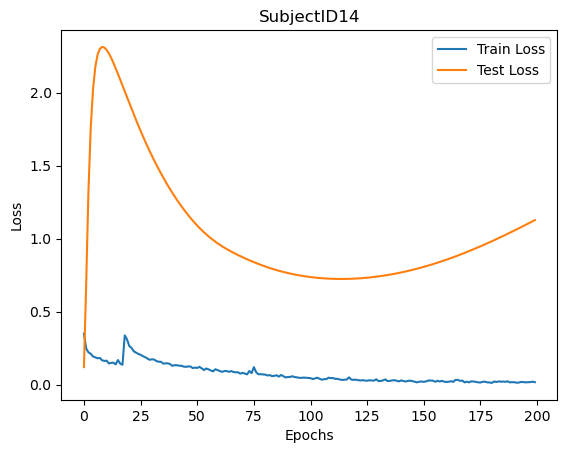

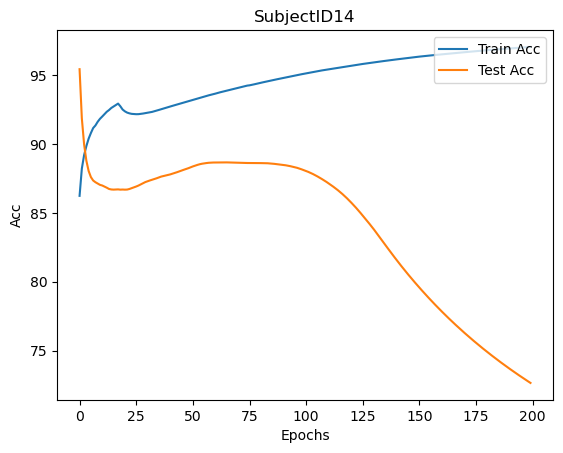


Subject 15
device: cuda
| epoch   0 | 0.7963 s/epoch | train loss 0.3855
| epoch   1 | 0.8111 s/epoch | train loss 0.2584
| epoch   2 | 0.7749 s/epoch | train loss 0.3519
| epoch   3 | 0.7881 s/epoch | train loss 0.2971
| epoch   4 | 0.7806 s/epoch | train loss 0.2358
| epoch   5 | 0.7687 s/epoch | train loss 0.3005
| epoch   6 | 0.7836 s/epoch | train loss 0.2567
| epoch   7 | 0.8180 s/epoch | train loss 0.2276
| epoch   8 | 0.7751 s/epoch | train loss 0.2126
| epoch   9 | 0.7824 s/epoch | train loss 0.1998
| epoch  10 | 0.7909 s/epoch | train loss 0.1946
| epoch  11 | 0.7750 s/epoch | train loss 0.1944
| epoch  12 | 0.7863 s/epoch | train loss 0.1730
| epoch  13 | 0.7618 s/epoch | train loss 0.1698
| epoch  14 | 0.7522 s/epoch | train loss 0.1580
| epoch  15 | 0.7291 s/epoch | train loss 0.1586
| epoch  16 | 0.7471 s/epoch | train loss 0.1560
| epoch  17 | 0.7521 s/epoch | train loss 0.1487
| epoch  18 | 0.7248 s/epoch | train loss 0.1421
| epoch  19 | 0.7490 s/epoch | train loss 0.

| epoch 167 | 0.6561 s/epoch | train loss 0.0243
| epoch 168 | 0.6525 s/epoch | train loss 0.0265
| epoch 169 | 0.6398 s/epoch | train loss 0.0197
| epoch 170 | 0.6650 s/epoch | train loss 0.0346
| epoch 171 | 0.6628 s/epoch | train loss 0.0249
| epoch 172 | 0.6956 s/epoch | train loss 0.0227
| epoch 173 | 0.6903 s/epoch | train loss 0.0209
| epoch 174 | 0.6851 s/epoch | train loss 0.0248
| epoch 175 | 0.6873 s/epoch | train loss 0.0272
| epoch 176 | 0.6828 s/epoch | train loss 0.0187
| epoch 177 | 0.6956 s/epoch | train loss 0.0203
| epoch 178 | 0.6982 s/epoch | train loss 0.0189
| epoch 179 | 0.6930 s/epoch | train loss 0.0233
| epoch 180 | 0.6957 s/epoch | train loss 0.0192
| epoch 181 | 0.6941 s/epoch | train loss 0.0227
| epoch 182 | 0.6935 s/epoch | train loss 0.0222
| epoch 183 | 0.6944 s/epoch | train loss 0.0265
| epoch 184 | 0.6918 s/epoch | train loss 0.0248
| epoch 185 | 0.7012 s/epoch | train loss 0.0231
| epoch 186 | 0.6993 s/epoch | train loss 0.0226
| epoch 187 | 0.6949

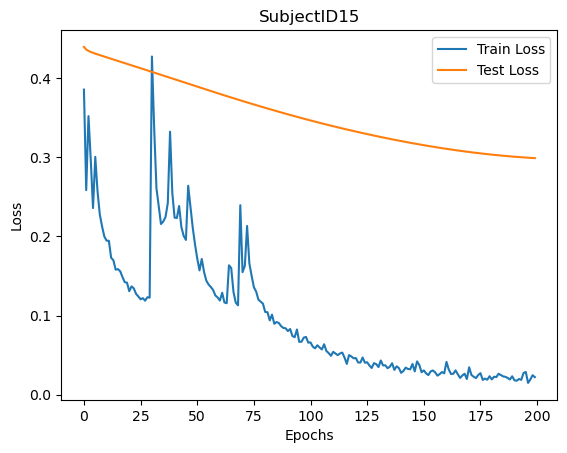

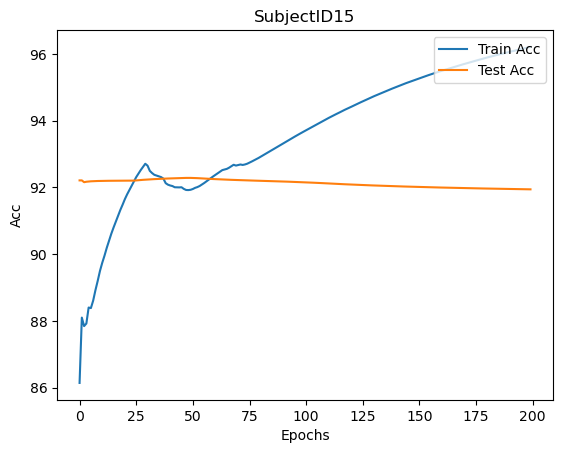

| epoch   0 | 0.6921 s/epoch | train loss 0.4341
| epoch   1 | 0.6948 s/epoch | train loss 0.4220
| epoch   2 | 0.6903 s/epoch | train loss 0.2949
| epoch   3 | 0.6904 s/epoch | train loss 0.2375
| epoch   4 | 0.6923 s/epoch | train loss 0.2163
| epoch   5 | 0.6923 s/epoch | train loss 0.2272
| epoch   6 | 0.6890 s/epoch | train loss 0.2158
| epoch   7 | 0.6909 s/epoch | train loss 0.1835
| epoch   8 | 0.6849 s/epoch | train loss 0.2076
| epoch   9 | 0.6911 s/epoch | train loss 0.1987
| epoch  10 | 0.6899 s/epoch | train loss 0.1839
| epoch  11 | 0.6886 s/epoch | train loss 0.1706
| epoch  12 | 0.6912 s/epoch | train loss 0.1714
| epoch  13 | 0.6966 s/epoch | train loss 0.1668
| epoch  14 | 0.6922 s/epoch | train loss 0.3937
| epoch  15 | 0.6897 s/epoch | train loss 0.2159
| epoch  16 | 0.6882 s/epoch | train loss 0.1984
| epoch  17 | 0.6944 s/epoch | train loss 0.1934
| epoch  18 | 0.6823 s/epoch | train loss 0.1774
| epoch  19 | 0.6921 s/epoch | train loss 0.1736
| epoch  20 | 0.6830

| epoch 168 | 0.6965 s/epoch | train loss 0.0198
| epoch 169 | 0.7021 s/epoch | train loss 0.0240
| epoch 170 | 0.6920 s/epoch | train loss 0.0177
| epoch 171 | 0.6943 s/epoch | train loss 0.0266
| epoch 172 | 0.6861 s/epoch | train loss 0.0239
| epoch 173 | 0.6939 s/epoch | train loss 0.0231
| epoch 174 | 0.6942 s/epoch | train loss 0.0213
| epoch 175 | 0.6871 s/epoch | train loss 0.0233
| epoch 176 | 0.6897 s/epoch | train loss 0.0234
| epoch 177 | 0.6940 s/epoch | train loss 0.0193
| epoch 178 | 0.6968 s/epoch | train loss 0.0200
| epoch 179 | 0.6975 s/epoch | train loss 0.0192
| epoch 180 | 0.6927 s/epoch | train loss 0.0149
| epoch 181 | 0.6980 s/epoch | train loss 0.0226
| epoch 182 | 0.6969 s/epoch | train loss 0.0183
| epoch 183 | 0.6904 s/epoch | train loss 0.0193
| epoch 184 | 0.7009 s/epoch | train loss 0.0226
| epoch 185 | 0.6847 s/epoch | train loss 0.0409
| epoch 186 | 0.6915 s/epoch | train loss 0.0245
| epoch 187 | 0.6914 s/epoch | train loss 0.0146
| epoch 188 | 0.6956

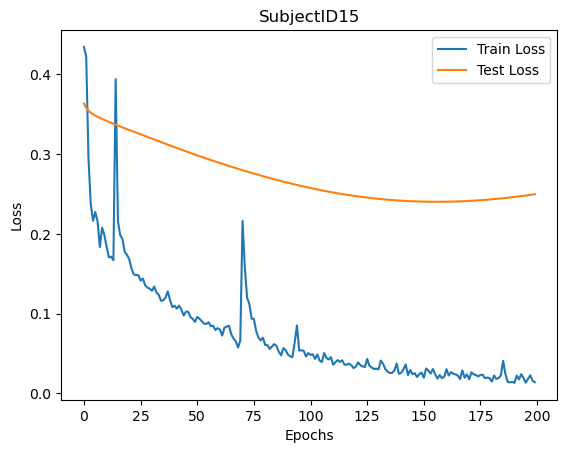

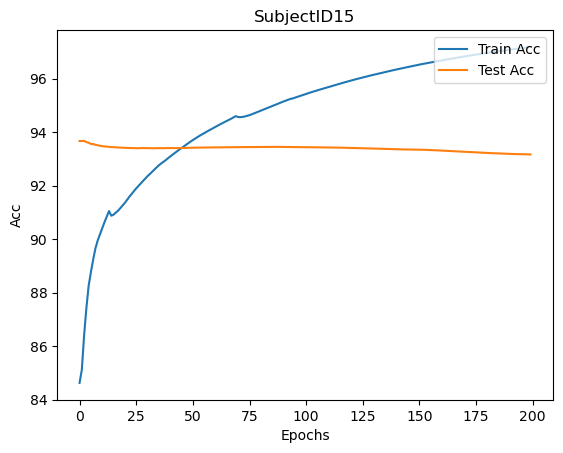


Subject 16
device: cuda
| epoch   0 | 0.6954 s/epoch | train loss 0.3334
| epoch   1 | 0.6944 s/epoch | train loss 0.2513
| epoch   2 | 0.6848 s/epoch | train loss 0.2242
| epoch   3 | 0.6871 s/epoch | train loss 0.2135
| epoch   4 | 0.6937 s/epoch | train loss 0.2012
| epoch   5 | 0.6903 s/epoch | train loss 0.1906
| epoch   6 | 0.6907 s/epoch | train loss 0.1784
| epoch   7 | 0.6917 s/epoch | train loss 0.1781
| epoch   8 | 0.6917 s/epoch | train loss 0.1711
| epoch   9 | 0.6900 s/epoch | train loss 0.1652
| epoch  10 | 0.6982 s/epoch | train loss 0.1598
| epoch  11 | 0.6953 s/epoch | train loss 0.1640
| epoch  12 | 0.6918 s/epoch | train loss 0.1530
| epoch  13 | 0.6935 s/epoch | train loss 0.1457
| epoch  14 | 0.6933 s/epoch | train loss 0.1423
| epoch  15 | 0.6950 s/epoch | train loss 0.1490
| epoch  16 | 0.6953 s/epoch | train loss 0.1330
| epoch  17 | 0.6933 s/epoch | train loss 0.1392
| epoch  18 | 0.6911 s/epoch | train loss 0.1326
| epoch  19 | 0.6958 s/epoch | train loss 0.

| epoch 167 | 0.6951 s/epoch | train loss 0.0154
| epoch 168 | 0.6913 s/epoch | train loss 0.0265
| epoch 169 | 0.6953 s/epoch | train loss 0.0287
| epoch 170 | 0.6997 s/epoch | train loss 0.0257
| epoch 171 | 0.6887 s/epoch | train loss 0.0240
| epoch 172 | 0.6913 s/epoch | train loss 0.0244
| epoch 173 | 0.6923 s/epoch | train loss 0.0269
| epoch 174 | 0.6946 s/epoch | train loss 0.0224
| epoch 175 | 0.6967 s/epoch | train loss 0.0201
| epoch 176 | 0.6797 s/epoch | train loss 0.0193
| epoch 177 | 0.6772 s/epoch | train loss 0.0286
| epoch 178 | 0.6922 s/epoch | train loss 0.0257
| epoch 179 | 0.6993 s/epoch | train loss 0.0232
| epoch 180 | 0.7085 s/epoch | train loss 0.0207
| epoch 181 | 0.6995 s/epoch | train loss 0.0204
| epoch 182 | 0.6957 s/epoch | train loss 0.0221
| epoch 183 | 0.7007 s/epoch | train loss 0.0213
| epoch 184 | 0.6895 s/epoch | train loss 0.0238
| epoch 185 | 0.6966 s/epoch | train loss 0.0190
| epoch 186 | 0.6895 s/epoch | train loss 0.0250
| epoch 187 | 0.7014

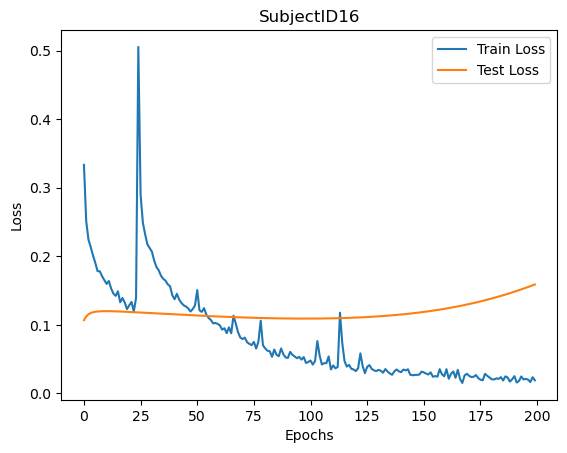

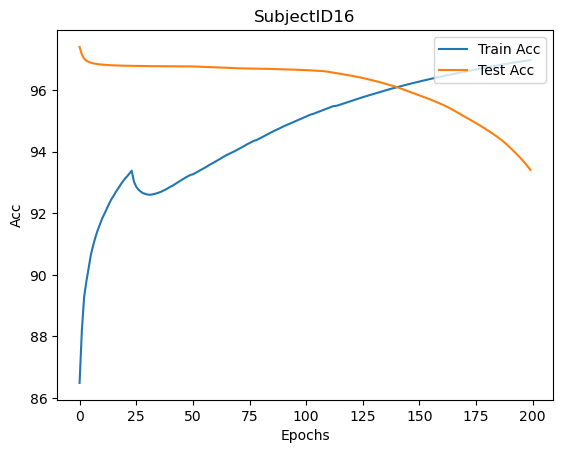

| epoch   0 | 0.6884 s/epoch | train loss 0.3409
| epoch   1 | 0.6923 s/epoch | train loss 0.2525
| epoch   2 | 0.6902 s/epoch | train loss 0.2269
| epoch   3 | 0.6912 s/epoch | train loss 0.2055
| epoch   4 | 0.6935 s/epoch | train loss 0.2019
| epoch   5 | 0.6911 s/epoch | train loss 0.2175
| epoch   6 | 0.6878 s/epoch | train loss 0.1924
| epoch   7 | 0.6908 s/epoch | train loss 0.1770
| epoch   8 | 0.6792 s/epoch | train loss 0.1832
| epoch   9 | 0.6847 s/epoch | train loss 0.1685
| epoch  10 | 0.6963 s/epoch | train loss 0.1614
| epoch  11 | 0.6933 s/epoch | train loss 0.1630
| epoch  12 | 0.6886 s/epoch | train loss 0.1582
| epoch  13 | 0.6817 s/epoch | train loss 0.1501
| epoch  14 | 0.6852 s/epoch | train loss 0.1472
| epoch  15 | 0.6997 s/epoch | train loss 0.1477
| epoch  16 | 0.6941 s/epoch | train loss 0.1417
| epoch  17 | 0.6936 s/epoch | train loss 0.1399
| epoch  18 | 0.6926 s/epoch | train loss 0.1378
| epoch  19 | 0.6874 s/epoch | train loss 0.1302
| epoch  20 | 0.6929

| epoch 168 | 0.6955 s/epoch | train loss 0.0203
| epoch 169 | 0.6894 s/epoch | train loss 0.0197
| epoch 170 | 0.6948 s/epoch | train loss 0.0161
| epoch 171 | 0.6972 s/epoch | train loss 0.0195
| epoch 172 | 0.6926 s/epoch | train loss 0.0259
| epoch 173 | 0.6930 s/epoch | train loss 0.0248
| epoch 174 | 0.6889 s/epoch | train loss 0.0237
| epoch 175 | 0.6934 s/epoch | train loss 0.0231
| epoch 176 | 0.6976 s/epoch | train loss 0.0182
| epoch 177 | 0.6875 s/epoch | train loss 0.0175
| epoch 178 | 0.6805 s/epoch | train loss 0.0207
| epoch 179 | 0.6872 s/epoch | train loss 0.0214
| epoch 180 | 0.6829 s/epoch | train loss 0.0156
| epoch 181 | 0.6898 s/epoch | train loss 0.0321
| epoch 182 | 0.6860 s/epoch | train loss 0.0218
| epoch 183 | 0.6934 s/epoch | train loss 0.0178
| epoch 184 | 0.6931 s/epoch | train loss 0.0229
| epoch 185 | 0.6915 s/epoch | train loss 0.0166
| epoch 186 | 0.6927 s/epoch | train loss 0.0265
| epoch 187 | 0.6828 s/epoch | train loss 0.0181
| epoch 188 | 0.6906

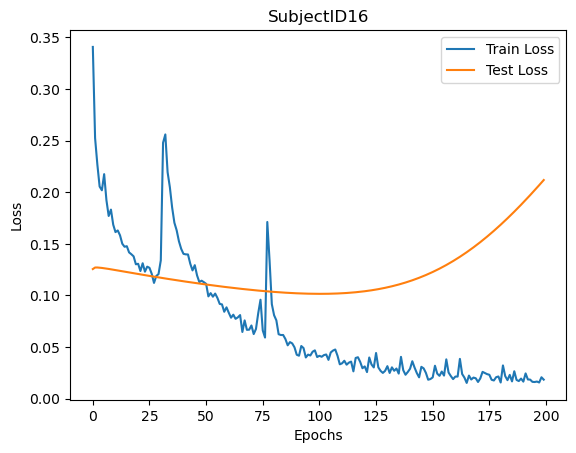

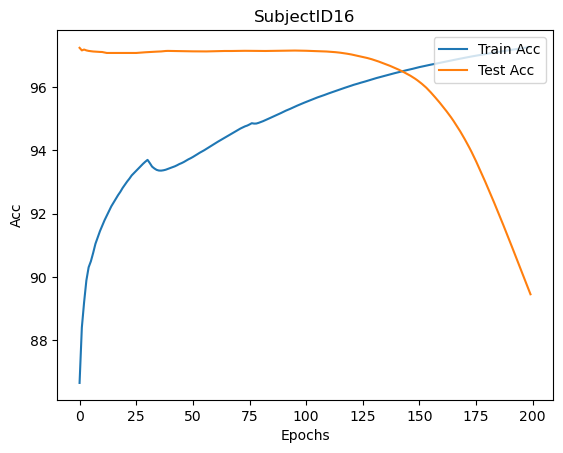


Subject 18
device: cuda
| epoch   0 | 0.6923 s/epoch | train loss 0.3516
| epoch   1 | 0.6888 s/epoch | train loss 0.2567
| epoch   2 | 0.6949 s/epoch | train loss 0.2280
| epoch   3 | 0.6923 s/epoch | train loss 0.2138
| epoch   4 | 0.6882 s/epoch | train loss 0.2290
| epoch   5 | 0.6900 s/epoch | train loss 0.2242
| epoch   6 | 0.6912 s/epoch | train loss 0.1958
| epoch   7 | 0.6905 s/epoch | train loss 0.1923
| epoch   8 | 0.6930 s/epoch | train loss 0.1792
| epoch   9 | 0.6880 s/epoch | train loss 0.1738
| epoch  10 | 0.6843 s/epoch | train loss 0.1641
| epoch  11 | 0.6966 s/epoch | train loss 0.1637
| epoch  12 | 0.6891 s/epoch | train loss 0.1542
| epoch  13 | 0.6938 s/epoch | train loss 0.1493
| epoch  14 | 0.6923 s/epoch | train loss 0.1488
| epoch  15 | 0.6912 s/epoch | train loss 0.1447
| epoch  16 | 0.6958 s/epoch | train loss 0.1373
| epoch  17 | 0.6920 s/epoch | train loss 0.1370
| epoch  18 | 0.6930 s/epoch | train loss 0.1354
| epoch  19 | 0.6895 s/epoch | train loss 0.

| epoch 167 | 0.3984 s/epoch | train loss 0.0287
| epoch 168 | 0.3945 s/epoch | train loss 0.0238
| epoch 169 | 0.3933 s/epoch | train loss 0.0316
| epoch 170 | 0.3965 s/epoch | train loss 0.0209
| epoch 171 | 0.3926 s/epoch | train loss 0.0218
| epoch 172 | 0.3944 s/epoch | train loss 0.0195
| epoch 173 | 0.3952 s/epoch | train loss 0.0258
| epoch 174 | 0.3959 s/epoch | train loss 0.0236
| epoch 175 | 0.3958 s/epoch | train loss 0.0283
| epoch 176 | 0.3989 s/epoch | train loss 0.0260
| epoch 177 | 0.3999 s/epoch | train loss 0.0186
| epoch 178 | 0.3958 s/epoch | train loss 0.0211
| epoch 179 | 0.3970 s/epoch | train loss 0.0248
| epoch 180 | 0.3948 s/epoch | train loss 0.0214
| epoch 181 | 0.3946 s/epoch | train loss 0.0242
| epoch 182 | 0.3934 s/epoch | train loss 0.0264
| epoch 183 | 0.3934 s/epoch | train loss 0.0227
| epoch 184 | 0.3955 s/epoch | train loss 0.0284
| epoch 185 | 0.3940 s/epoch | train loss 0.0222
| epoch 186 | 0.3968 s/epoch | train loss 0.0192
| epoch 187 | 0.3947

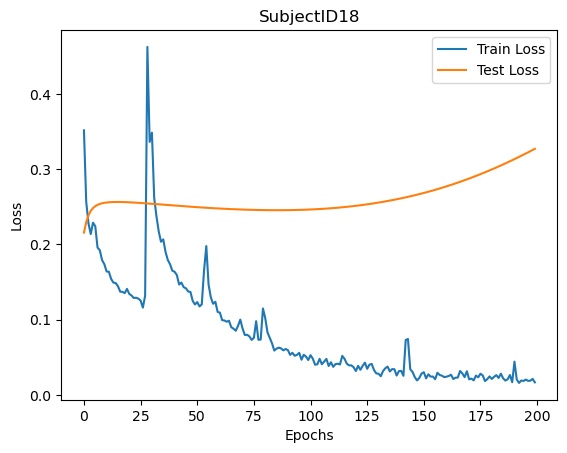

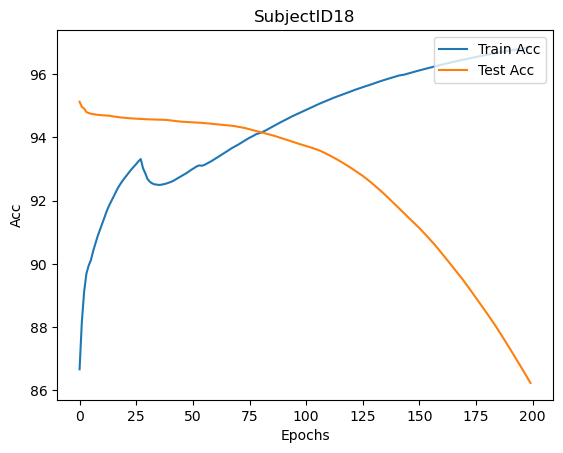

| epoch   0 | 0.3833 s/epoch | train loss 0.4308
| epoch   1 | 0.3821 s/epoch | train loss 0.2957
| epoch   2 | 0.3836 s/epoch | train loss 0.2685
| epoch   3 | 0.3845 s/epoch | train loss 0.2324
| epoch   4 | 0.3814 s/epoch | train loss 0.2021
| epoch   5 | 0.3822 s/epoch | train loss 0.2098
| epoch   6 | 0.3847 s/epoch | train loss 0.1906
| epoch   7 | 0.3816 s/epoch | train loss 0.1775
| epoch   8 | 0.3811 s/epoch | train loss 0.1863
| epoch   9 | 0.3821 s/epoch | train loss 0.1736
| epoch  10 | 0.3860 s/epoch | train loss 0.2817
| epoch  11 | 0.3826 s/epoch | train loss 0.2249
| epoch  12 | 0.3840 s/epoch | train loss 0.3754
| epoch  13 | 0.3797 s/epoch | train loss 0.2401
| epoch  14 | 0.3823 s/epoch | train loss 0.2211
| epoch  15 | 0.3821 s/epoch | train loss 0.2117
| epoch  16 | 0.3829 s/epoch | train loss 0.1932
| epoch  17 | 0.3837 s/epoch | train loss 0.1824
| epoch  18 | 0.3839 s/epoch | train loss 0.1764
| epoch  19 | 0.3844 s/epoch | train loss 0.1748
| epoch  20 | 0.3860

| epoch 168 | 0.4074 s/epoch | train loss 0.0234
| epoch 169 | 0.4118 s/epoch | train loss 0.0241
| epoch 170 | 0.4094 s/epoch | train loss 0.0232
| epoch 171 | 0.4067 s/epoch | train loss 0.0282
| epoch 172 | 0.4085 s/epoch | train loss 0.0187
| epoch 173 | 0.4102 s/epoch | train loss 0.0227
| epoch 174 | 0.4169 s/epoch | train loss 0.0218
| epoch 175 | 0.4063 s/epoch | train loss 0.0214
| epoch 176 | 0.4062 s/epoch | train loss 0.0208
| epoch 177 | 0.4058 s/epoch | train loss 0.0308
| epoch 178 | 0.4055 s/epoch | train loss 0.0204
| epoch 179 | 0.4065 s/epoch | train loss 0.0208
| epoch 180 | 0.4064 s/epoch | train loss 0.0207
| epoch 181 | 0.4088 s/epoch | train loss 0.0237
| epoch 182 | 0.4054 s/epoch | train loss 0.0207
| epoch 183 | 0.4073 s/epoch | train loss 0.0229
| epoch 184 | 0.4095 s/epoch | train loss 0.0233
| epoch 185 | 0.4076 s/epoch | train loss 0.0151
| epoch 186 | 0.4075 s/epoch | train loss 0.0223
| epoch 187 | 0.4102 s/epoch | train loss 0.0274
| epoch 188 | 0.4070

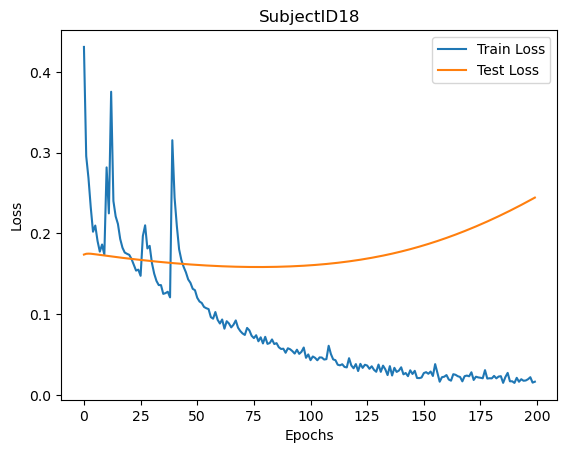

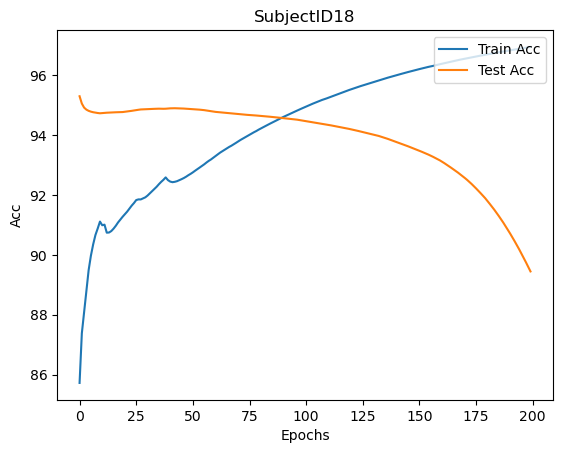


Subject 19
device: cuda
| epoch   0 | 0.4032 s/epoch | train loss 0.3684
| epoch   1 | 0.4032 s/epoch | train loss 0.3871
| epoch   2 | 0.4018 s/epoch | train loss 0.5066
| epoch   3 | 0.4052 s/epoch | train loss 0.2966
| epoch   4 | 0.4044 s/epoch | train loss 0.2668
| epoch   5 | 0.4057 s/epoch | train loss 0.2448
| epoch   6 | 0.4039 s/epoch | train loss 0.2339
| epoch   7 | 0.4057 s/epoch | train loss 0.2173
| epoch   8 | 0.4050 s/epoch | train loss 0.2065
| epoch   9 | 0.4053 s/epoch | train loss 0.1950
| epoch  10 | 0.4091 s/epoch | train loss 0.1938
| epoch  11 | 0.4085 s/epoch | train loss 0.3030
| epoch  12 | 0.4139 s/epoch | train loss 0.2373
| epoch  13 | 0.4026 s/epoch | train loss 0.3401
| epoch  14 | 0.4042 s/epoch | train loss 0.2586
| epoch  15 | 0.4095 s/epoch | train loss 0.3096
| epoch  16 | 0.4056 s/epoch | train loss 0.4038
| epoch  17 | 0.4005 s/epoch | train loss 0.2922
| epoch  18 | 0.4023 s/epoch | train loss 0.2563
| epoch  19 | 0.4130 s/epoch | train loss 0.

| epoch 167 | 0.5945 s/epoch | train loss 0.0340
| epoch 168 | 0.5959 s/epoch | train loss 0.0244
| epoch 169 | 0.5942 s/epoch | train loss 0.0232
| epoch 170 | 0.5959 s/epoch | train loss 0.0218
| epoch 171 | 0.5943 s/epoch | train loss 0.0189
| epoch 172 | 0.6341 s/epoch | train loss 0.0190
| epoch 173 | 0.5933 s/epoch | train loss 0.0223
| epoch 174 | 0.5897 s/epoch | train loss 0.0236
| epoch 175 | 0.5920 s/epoch | train loss 0.0210
| epoch 176 | 0.5929 s/epoch | train loss 0.0301
| epoch 177 | 0.7831 s/epoch | train loss 0.0245
| epoch 178 | 0.6825 s/epoch | train loss 0.0208
| epoch 179 | 0.6190 s/epoch | train loss 0.0201
| epoch 180 | 0.5915 s/epoch | train loss 0.0229
| epoch 181 | 0.6906 s/epoch | train loss 0.0201
| epoch 182 | 0.6368 s/epoch | train loss 0.0259
| epoch 183 | 0.5893 s/epoch | train loss 0.0178
| epoch 184 | 0.5928 s/epoch | train loss 0.0253
| epoch 185 | 0.5843 s/epoch | train loss 0.0188
| epoch 186 | 0.5858 s/epoch | train loss 0.0202
| epoch 187 | 0.5852

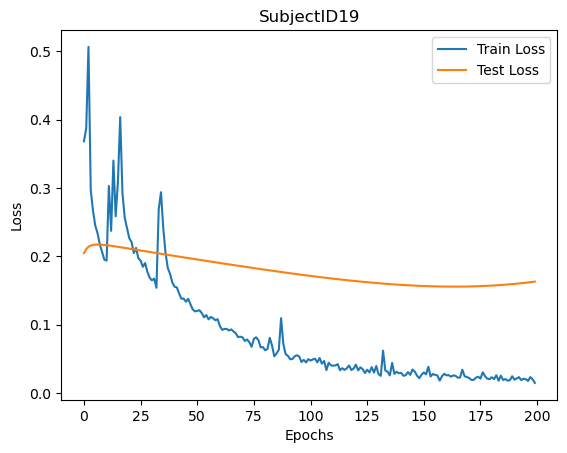

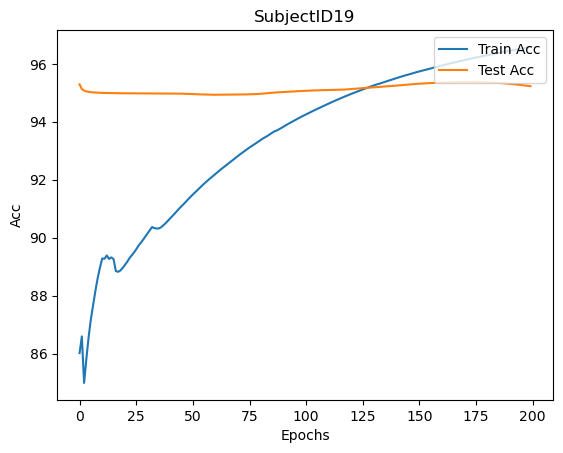

| epoch   0 | 0.5988 s/epoch | train loss 0.3356
| epoch   1 | 0.5978 s/epoch | train loss 0.2520
| epoch   2 | 0.6154 s/epoch | train loss 0.2256
| epoch   3 | 0.6119 s/epoch | train loss 0.2134
| epoch   4 | 0.6220 s/epoch | train loss 0.2023
| epoch   5 | 0.6055 s/epoch | train loss 0.1854
| epoch   6 | 0.6069 s/epoch | train loss 0.1888
| epoch   7 | 0.6098 s/epoch | train loss 0.1787
| epoch   8 | 0.5866 s/epoch | train loss 0.1716
| epoch   9 | 0.5869 s/epoch | train loss 0.1682
| epoch  10 | 0.6004 s/epoch | train loss 0.1612
| epoch  11 | 0.5895 s/epoch | train loss 0.1581
| epoch  12 | 0.5901 s/epoch | train loss 0.1797
| epoch  13 | 0.5804 s/epoch | train loss 0.1478
| epoch  14 | 0.5877 s/epoch | train loss 0.1545
| epoch  15 | 0.5843 s/epoch | train loss 0.1428
| epoch  16 | 0.7121 s/epoch | train loss 0.1441
| epoch  17 | 0.5778 s/epoch | train loss 0.1766
| epoch  18 | 0.5850 s/epoch | train loss 0.1616
| epoch  19 | 0.5869 s/epoch | train loss 0.1468
| epoch  20 | 0.9277

| epoch 168 | 0.5738 s/epoch | train loss 0.0420
| epoch 169 | 0.5829 s/epoch | train loss 0.0302
| epoch 170 | 0.5769 s/epoch | train loss 0.0311
| epoch 171 | 0.5817 s/epoch | train loss 0.0388
| epoch 172 | 0.5705 s/epoch | train loss 0.0307
| epoch 173 | 0.5839 s/epoch | train loss 0.0340
| epoch 174 | 0.5710 s/epoch | train loss 0.0373
| epoch 175 | 0.5856 s/epoch | train loss 0.0315
| epoch 176 | 0.5887 s/epoch | train loss 0.0307
| epoch 177 | 0.5729 s/epoch | train loss 0.0306
| epoch 178 | 0.5855 s/epoch | train loss 0.0407
| epoch 179 | 0.5759 s/epoch | train loss 0.0311
| epoch 180 | 0.5870 s/epoch | train loss 0.0327
| epoch 181 | 0.5741 s/epoch | train loss 0.0293
| epoch 182 | 0.5847 s/epoch | train loss 0.0331
| epoch 183 | 0.5763 s/epoch | train loss 0.0374
| epoch 184 | 0.5831 s/epoch | train loss 0.0292
| epoch 185 | 0.5875 s/epoch | train loss 0.0324
| epoch 186 | 0.5830 s/epoch | train loss 0.0277
| epoch 187 | 0.5864 s/epoch | train loss 0.0340
| epoch 188 | 0.5908

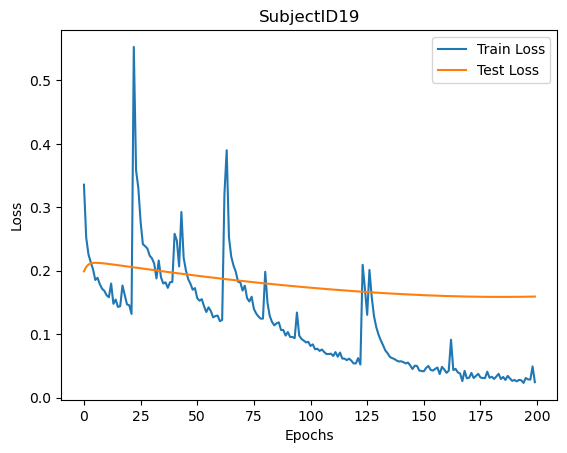

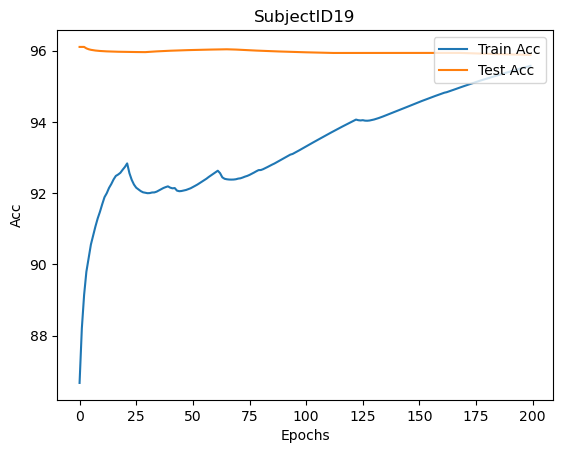


Subject 21
device: cuda
| epoch   0 | 0.5909 s/epoch | train loss 0.3360
| epoch   1 | 0.5922 s/epoch | train loss 0.2460
| epoch   2 | 0.5775 s/epoch | train loss 0.2454
| epoch   3 | 0.5861 s/epoch | train loss 0.2177
| epoch   4 | 0.5806 s/epoch | train loss 0.2058
| epoch   5 | 0.5918 s/epoch | train loss 0.1927
| epoch   6 | 0.5798 s/epoch | train loss 0.1824
| epoch   7 | 0.5957 s/epoch | train loss 0.1859
| epoch   8 | 0.5829 s/epoch | train loss 0.1733
| epoch   9 | 0.5883 s/epoch | train loss 0.1799
| epoch  10 | 0.5940 s/epoch | train loss 0.1712
| epoch  11 | 0.5889 s/epoch | train loss 0.1682
| epoch  12 | 0.5772 s/epoch | train loss 0.1622
| epoch  13 | 0.5943 s/epoch | train loss 0.1526
| epoch  14 | 0.5882 s/epoch | train loss 0.2442
| epoch  15 | 0.5803 s/epoch | train loss 0.2492
| epoch  16 | 0.5894 s/epoch | train loss 0.2203
| epoch  17 | 0.5812 s/epoch | train loss 0.2042
| epoch  18 | 0.5901 s/epoch | train loss 0.1927
| epoch  19 | 0.5865 s/epoch | train loss 0.

| epoch 167 | 0.5771 s/epoch | train loss 0.0239
| epoch 168 | 0.5811 s/epoch | train loss 0.0185
| epoch 169 | 0.5806 s/epoch | train loss 0.0185
| epoch 170 | 0.5800 s/epoch | train loss 0.0178
| epoch 171 | 0.5793 s/epoch | train loss 0.0227
| epoch 172 | 0.5782 s/epoch | train loss 0.0157
| epoch 173 | 0.5830 s/epoch | train loss 0.0174
| epoch 174 | 0.5803 s/epoch | train loss 0.0181
| epoch 175 | 0.5768 s/epoch | train loss 0.0216
| epoch 176 | 0.5777 s/epoch | train loss 0.0134
| epoch 177 | 0.5815 s/epoch | train loss 0.0183
| epoch 178 | 0.5721 s/epoch | train loss 0.0168
| epoch 179 | 0.5765 s/epoch | train loss 0.0719
| epoch 180 | 0.5738 s/epoch | train loss 0.0303
| epoch 181 | 0.5735 s/epoch | train loss 0.0146
| epoch 182 | 0.5714 s/epoch | train loss 0.0171
| epoch 183 | 0.5719 s/epoch | train loss 0.0143
| epoch 184 | 0.5761 s/epoch | train loss 0.0228
| epoch 185 | 0.5716 s/epoch | train loss 0.0167
| epoch 186 | 0.5741 s/epoch | train loss 0.0198
| epoch 187 | 0.5751

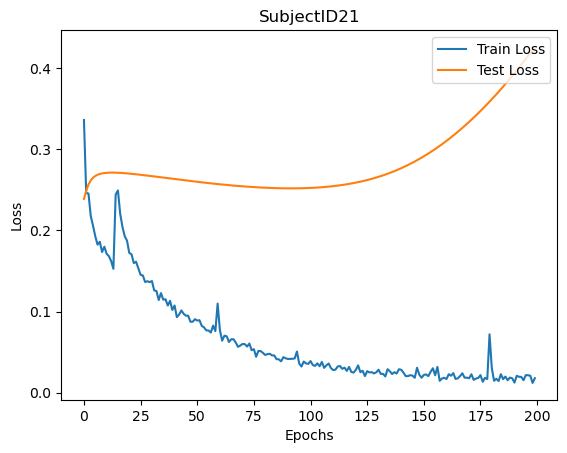

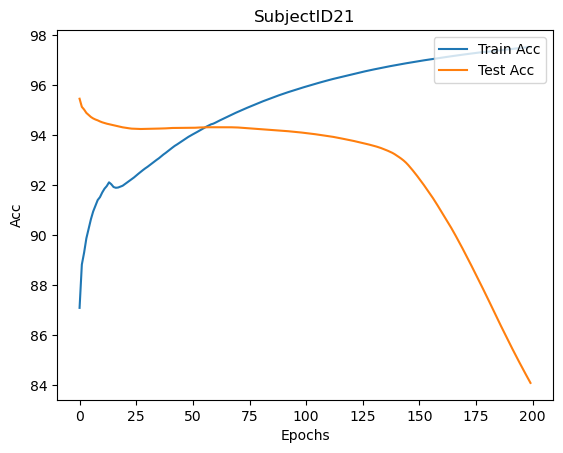

| epoch   0 | 0.5627 s/epoch | train loss 0.3703
| epoch   1 | 0.5648 s/epoch | train loss 0.3824
| epoch   2 | 0.5639 s/epoch | train loss 0.4048
| epoch   3 | 0.5650 s/epoch | train loss 0.2730
| epoch   4 | 0.5663 s/epoch | train loss 0.2570
| epoch   5 | 0.5628 s/epoch | train loss 0.2391
| epoch   6 | 0.5676 s/epoch | train loss 0.2261
| epoch   7 | 0.5675 s/epoch | train loss 0.2199
| epoch   8 | 0.5704 s/epoch | train loss 0.2137
| epoch   9 | 0.5675 s/epoch | train loss 0.2086
| epoch  10 | 0.5726 s/epoch | train loss 0.2017
| epoch  11 | 0.7412 s/epoch | train loss 0.1931
| epoch  12 | 0.6443 s/epoch | train loss 0.1923
| epoch  13 | 0.7164 s/epoch | train loss 0.1903
| epoch  14 | 0.7287 s/epoch | train loss 0.1882
| epoch  15 | 0.6608 s/epoch | train loss 0.1861
| epoch  16 | 0.6644 s/epoch | train loss 0.1786
| epoch  17 | 0.6964 s/epoch | train loss 0.2156
| epoch  18 | 0.7430 s/epoch | train loss 0.1697
| epoch  19 | 0.7552 s/epoch | train loss 0.1605
| epoch  20 | 0.7246

| epoch 168 | 0.6404 s/epoch | train loss 0.0234
| epoch 169 | 0.6309 s/epoch | train loss 0.0274
| epoch 170 | 0.6380 s/epoch | train loss 0.0249
| epoch 171 | 0.6386 s/epoch | train loss 0.0249
| epoch 172 | 0.6376 s/epoch | train loss 0.0300
| epoch 173 | 0.6435 s/epoch | train loss 0.0324
| epoch 174 | 0.6265 s/epoch | train loss 0.0239
| epoch 175 | 0.6277 s/epoch | train loss 0.0274
| epoch 176 | 0.6280 s/epoch | train loss 0.0275
| epoch 177 | 0.6378 s/epoch | train loss 0.0283
| epoch 178 | 0.5764 s/epoch | train loss 0.0264
| epoch 179 | 0.6068 s/epoch | train loss 0.0219
| epoch 180 | 0.5784 s/epoch | train loss 0.0230
| epoch 181 | 0.5922 s/epoch | train loss 0.0323
| epoch 182 | 0.5869 s/epoch | train loss 0.0224
| epoch 183 | 0.5900 s/epoch | train loss 0.0285
| epoch 184 | 0.5772 s/epoch | train loss 0.0306
| epoch 185 | 0.5785 s/epoch | train loss 0.0234
| epoch 186 | 0.5894 s/epoch | train loss 0.0238
| epoch 187 | 0.6030 s/epoch | train loss 0.0293
| epoch 188 | 0.5698

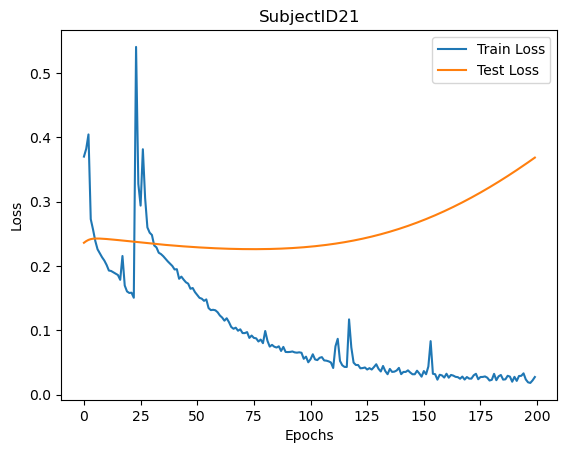

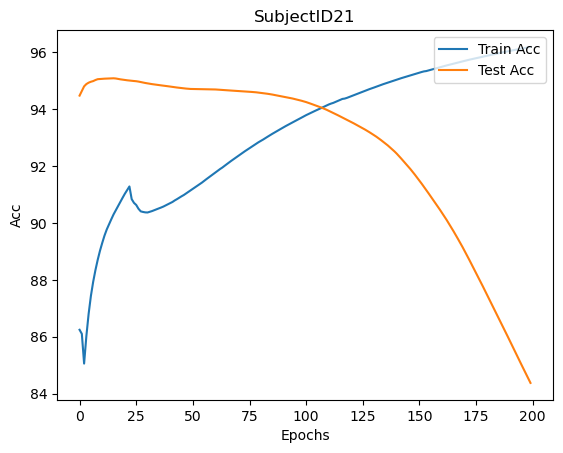


Subject 22
device: cuda
| epoch   0 | 0.5954 s/epoch | train loss 0.3555
| epoch   1 | 0.5816 s/epoch | train loss 0.2543
| epoch   2 | 0.5748 s/epoch | train loss 0.2212
| epoch   3 | 0.6040 s/epoch | train loss 0.2146
| epoch   4 | 0.5794 s/epoch | train loss 0.1907
| epoch   5 | 0.5707 s/epoch | train loss 0.1963
| epoch   6 | 0.5786 s/epoch | train loss 0.1958
| epoch   7 | 0.6694 s/epoch | train loss 0.1926
| epoch   8 | 0.6372 s/epoch | train loss 0.1729
| epoch   9 | 0.6719 s/epoch | train loss 0.1632
| epoch  10 | 0.5942 s/epoch | train loss 0.1530
| epoch  11 | 0.5975 s/epoch | train loss 0.1518
| epoch  12 | 0.5940 s/epoch | train loss 0.1413
| epoch  13 | 0.6086 s/epoch | train loss 0.1553
| epoch  14 | 0.6024 s/epoch | train loss 0.1491
| epoch  15 | 0.5865 s/epoch | train loss 0.1431
| epoch  16 | 0.5817 s/epoch | train loss 0.1447
| epoch  17 | 0.5847 s/epoch | train loss 0.1487
| epoch  18 | 0.5885 s/epoch | train loss 0.1750
| epoch  19 | 0.6108 s/epoch | train loss 0.

| epoch 167 | 0.6455 s/epoch | train loss 0.0192
| epoch 168 | 0.6844 s/epoch | train loss 0.0196
| epoch 169 | 0.7378 s/epoch | train loss 0.0209
| epoch 170 | 0.7507 s/epoch | train loss 0.0190
| epoch 171 | 0.7140 s/epoch | train loss 0.0219
| epoch 172 | 0.6088 s/epoch | train loss 0.0204
| epoch 173 | 0.6488 s/epoch | train loss 0.0195
| epoch 174 | 0.6516 s/epoch | train loss 0.0191
| epoch 175 | 0.6473 s/epoch | train loss 0.0197
| epoch 176 | 0.6558 s/epoch | train loss 0.0175
| epoch 177 | 0.6620 s/epoch | train loss 0.0178
| epoch 178 | 0.6436 s/epoch | train loss 0.0164
| epoch 179 | 0.6589 s/epoch | train loss 0.0183
| epoch 180 | 0.6686 s/epoch | train loss 0.0202
| epoch 181 | 0.6607 s/epoch | train loss 0.0189
| epoch 182 | 0.6753 s/epoch | train loss 0.0147
| epoch 183 | 0.6330 s/epoch | train loss 0.0135
| epoch 184 | 0.6495 s/epoch | train loss 0.0233
| epoch 185 | 0.6430 s/epoch | train loss 0.0187
| epoch 186 | 0.6385 s/epoch | train loss 0.0233
| epoch 187 | 0.6496

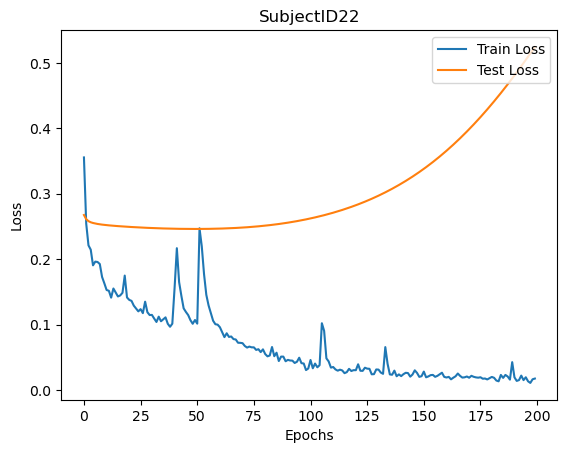

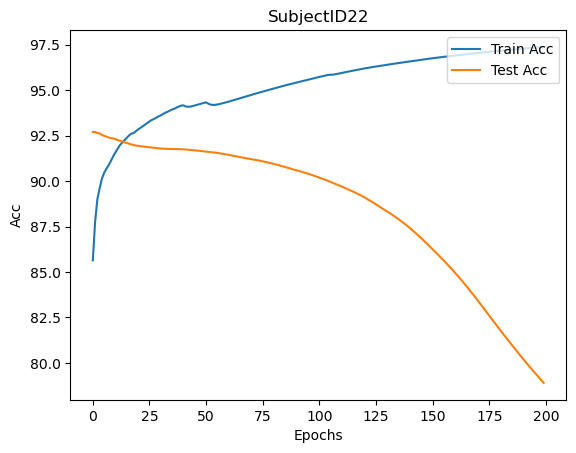

| epoch   0 | 0.5916 s/epoch | train loss 0.3707
| epoch   1 | 0.5417 s/epoch | train loss 0.2423
| epoch   2 | 0.5590 s/epoch | train loss 0.2182
| epoch   3 | 0.5618 s/epoch | train loss 0.1963
| epoch   4 | 0.6058 s/epoch | train loss 0.1991
| epoch   5 | 0.6410 s/epoch | train loss 0.1778
| epoch   6 | 0.6461 s/epoch | train loss 0.1767
| epoch   7 | 0.5997 s/epoch | train loss 0.1849
| epoch   8 | 0.5947 s/epoch | train loss 0.4435
| epoch   9 | 0.5550 s/epoch | train loss 0.3239
| epoch  10 | 0.6030 s/epoch | train loss 0.2661
| epoch  11 | 0.5489 s/epoch | train loss 0.2656
| epoch  12 | 0.5478 s/epoch | train loss 0.2343
| epoch  13 | 0.5489 s/epoch | train loss 0.2361
| epoch  14 | 0.5999 s/epoch | train loss 0.2386
| epoch  15 | 0.5998 s/epoch | train loss 0.2804
| epoch  16 | 0.6066 s/epoch | train loss 0.2356
| epoch  17 | 0.5938 s/epoch | train loss 0.2099
| epoch  18 | 0.6050 s/epoch | train loss 0.1966
| epoch  19 | 0.5988 s/epoch | train loss 0.1852
| epoch  20 | 0.5925

| epoch 168 | 0.4983 s/epoch | train loss 0.0247
| epoch 169 | 0.4996 s/epoch | train loss 0.0243
| epoch 170 | 0.4996 s/epoch | train loss 0.0236
| epoch 171 | 0.5005 s/epoch | train loss 0.0275
| epoch 172 | 0.5096 s/epoch | train loss 0.0264
| epoch 173 | 0.5067 s/epoch | train loss 0.0369
| epoch 174 | 0.4999 s/epoch | train loss 0.0241
| epoch 175 | 0.5072 s/epoch | train loss 0.0255
| epoch 176 | 0.4866 s/epoch | train loss 0.0269
| epoch 177 | 0.4871 s/epoch | train loss 0.0236
| epoch 178 | 0.4890 s/epoch | train loss 0.0240
| epoch 179 | 0.4989 s/epoch | train loss 0.0239
| epoch 180 | 0.4972 s/epoch | train loss 0.0189
| epoch 181 | 0.5215 s/epoch | train loss 0.0196
| epoch 182 | 0.5106 s/epoch | train loss 0.0231
| epoch 183 | 0.5057 s/epoch | train loss 0.0252
| epoch 184 | 0.5212 s/epoch | train loss 0.0242
| epoch 185 | 0.5133 s/epoch | train loss 0.0248
| epoch 186 | 0.5095 s/epoch | train loss 0.0225
| epoch 187 | 0.5175 s/epoch | train loss 0.0249
| epoch 188 | 0.5108

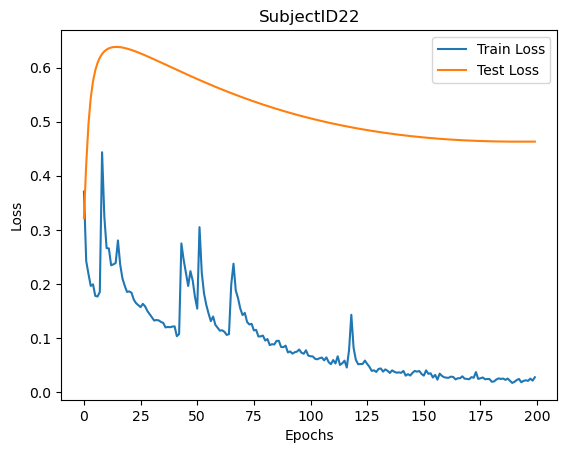

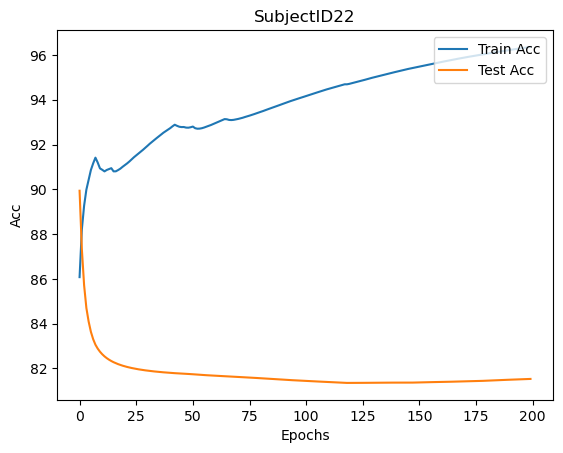


Subject 23
device: cuda
| epoch   0 | 0.4682 s/epoch | train loss 0.3182
| epoch   1 | 0.4642 s/epoch | train loss 0.2458
| epoch   2 | 0.4503 s/epoch | train loss 0.2191
| epoch   3 | 0.4689 s/epoch | train loss 0.2048
| epoch   4 | 0.4677 s/epoch | train loss 0.1953
| epoch   5 | 0.4587 s/epoch | train loss 0.1846
| epoch   6 | 0.4715 s/epoch | train loss 0.1754
| epoch   7 | 0.4729 s/epoch | train loss 0.1749
| epoch   8 | 0.4711 s/epoch | train loss 0.1709
| epoch   9 | 0.4723 s/epoch | train loss 0.1597
| epoch  10 | 0.4719 s/epoch | train loss 0.1554
| epoch  11 | 0.4711 s/epoch | train loss 0.1527
| epoch  12 | 0.4444 s/epoch | train loss 0.1558
| epoch  13 | 0.4409 s/epoch | train loss 0.1440
| epoch  14 | 0.4452 s/epoch | train loss 0.1458
| epoch  15 | 0.4562 s/epoch | train loss 0.1393
| epoch  16 | 0.4398 s/epoch | train loss 0.1416
| epoch  17 | 0.4002 s/epoch | train loss 0.1346
| epoch  18 | 0.3992 s/epoch | train loss 0.1251
| epoch  19 | 0.3991 s/epoch | train loss 0.

| epoch 167 | 0.3907 s/epoch | train loss 0.0173
| epoch 168 | 0.3938 s/epoch | train loss 0.0192
| epoch 169 | 0.3878 s/epoch | train loss 0.0220
| epoch 170 | 0.3898 s/epoch | train loss 0.0140
| epoch 171 | 0.3915 s/epoch | train loss 0.0142
| epoch 172 | 0.3931 s/epoch | train loss 0.0172
| epoch 173 | 0.3875 s/epoch | train loss 0.0215
| epoch 174 | 0.3887 s/epoch | train loss 0.0190
| epoch 175 | 0.3910 s/epoch | train loss 0.0188
| epoch 176 | 0.3942 s/epoch | train loss 0.0188
| epoch 177 | 0.3906 s/epoch | train loss 0.0216
| epoch 178 | 0.3898 s/epoch | train loss 0.0187
| epoch 179 | 0.3909 s/epoch | train loss 0.0146
| epoch 180 | 0.3893 s/epoch | train loss 0.0143
| epoch 181 | 0.3887 s/epoch | train loss 0.0173
| epoch 182 | 0.3890 s/epoch | train loss 0.0192
| epoch 183 | 0.3879 s/epoch | train loss 0.0146
| epoch 184 | 0.3923 s/epoch | train loss 0.0188
| epoch 185 | 0.3905 s/epoch | train loss 0.0210
| epoch 186 | 0.3881 s/epoch | train loss 0.0209
| epoch 187 | 0.3915

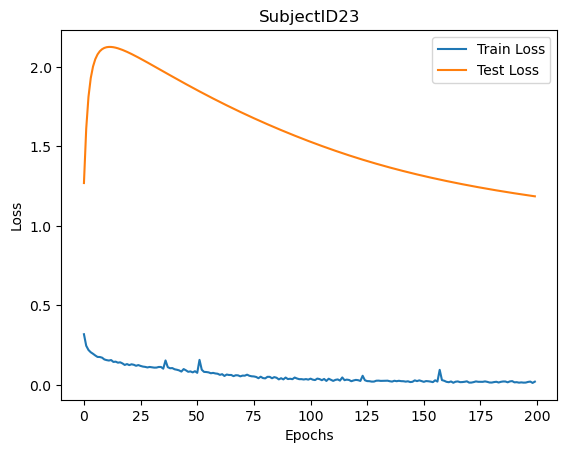

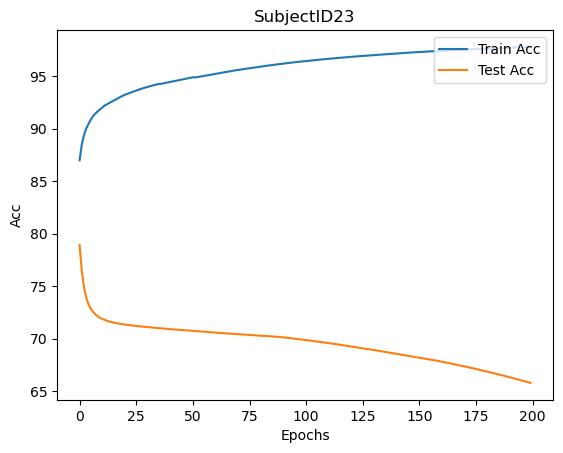

| epoch   0 | 0.3983 s/epoch | train loss 0.3398
| epoch   1 | 0.3970 s/epoch | train loss 0.2488
| epoch   2 | 0.3975 s/epoch | train loss 0.2281
| epoch   3 | 0.3962 s/epoch | train loss 0.2045
| epoch   4 | 0.3977 s/epoch | train loss 0.1905
| epoch   5 | 0.3987 s/epoch | train loss 0.1849
| epoch   6 | 0.4007 s/epoch | train loss 0.1790
| epoch   7 | 0.3982 s/epoch | train loss 0.1758
| epoch   8 | 0.4002 s/epoch | train loss 0.1711
| epoch   9 | 0.3996 s/epoch | train loss 0.1614
| epoch  10 | 0.3988 s/epoch | train loss 0.1575
| epoch  11 | 0.3989 s/epoch | train loss 0.1579
| epoch  12 | 0.3988 s/epoch | train loss 0.1411
| epoch  13 | 0.3999 s/epoch | train loss 0.1478
| epoch  14 | 0.3971 s/epoch | train loss 0.1391
| epoch  15 | 0.4027 s/epoch | train loss 0.1319
| epoch  16 | 0.4005 s/epoch | train loss 0.1359
| epoch  17 | 0.3992 s/epoch | train loss 0.1320
| epoch  18 | 0.3970 s/epoch | train loss 0.1299
| epoch  19 | 0.3983 s/epoch | train loss 0.1252
| epoch  20 | 0.3975

| epoch 168 | 0.3922 s/epoch | train loss 0.0196
| epoch 169 | 0.3897 s/epoch | train loss 0.0164
| epoch 170 | 0.3897 s/epoch | train loss 0.0216
| epoch 171 | 0.3919 s/epoch | train loss 0.0195
| epoch 172 | 0.3889 s/epoch | train loss 0.0261
| epoch 173 | 0.3877 s/epoch | train loss 0.0151
| epoch 174 | 0.3872 s/epoch | train loss 0.0149
| epoch 175 | 0.3910 s/epoch | train loss 0.0180
| epoch 176 | 0.3917 s/epoch | train loss 0.0179
| epoch 177 | 0.3896 s/epoch | train loss 0.0200
| epoch 178 | 0.3883 s/epoch | train loss 0.0198
| epoch 179 | 0.3900 s/epoch | train loss 0.0194
| epoch 180 | 0.3919 s/epoch | train loss 0.0160
| epoch 181 | 0.3887 s/epoch | train loss 0.0206
| epoch 182 | 0.3911 s/epoch | train loss 0.0218
| epoch 183 | 0.3875 s/epoch | train loss 0.0206
| epoch 184 | 0.3910 s/epoch | train loss 0.0171
| epoch 185 | 0.3928 s/epoch | train loss 0.0159
| epoch 186 | 0.3893 s/epoch | train loss 0.0158
| epoch 187 | 0.3896 s/epoch | train loss 0.0121
| epoch 188 | 0.3908

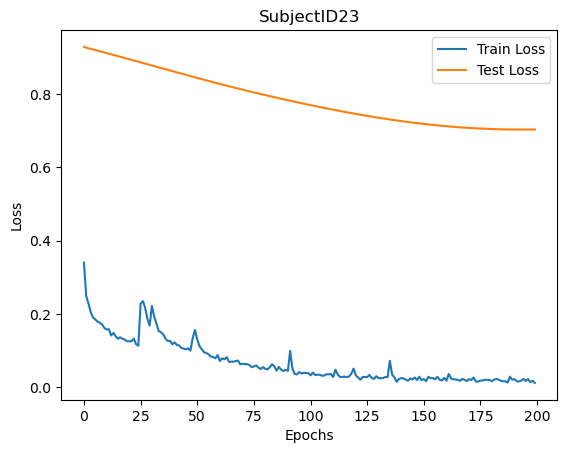

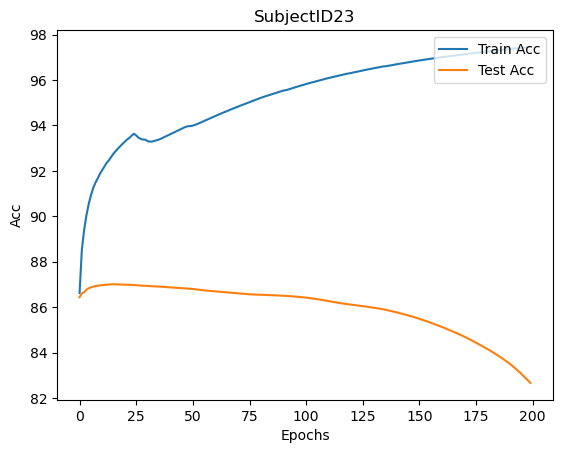

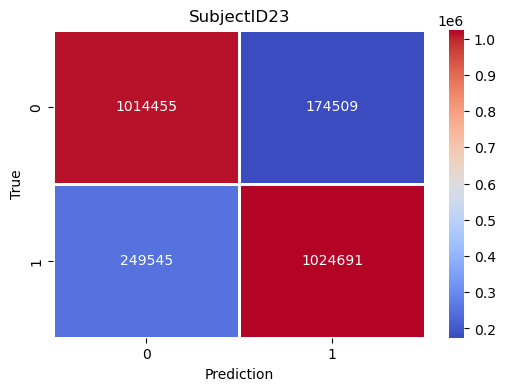

<Figure size 640x480 with 0 Axes>

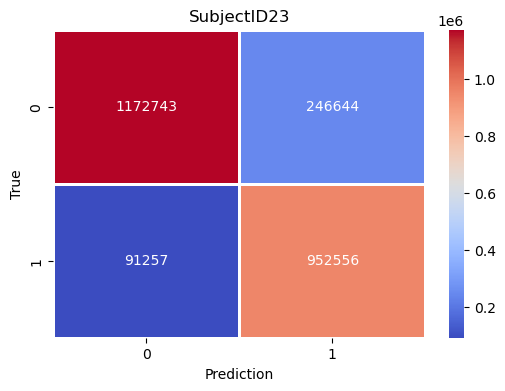

Teacher1(RestNet50)_Acc: 0.8278442676193569
Teacher1(RestNet50)_Rec: 0.8041610816206731
Teacher1(RestNet50)_Pre: 0.8544788192128085
Teacher1(RestNet50)_F1: 0.8285567122011648
Original_Student1(CNN_Small)_Acc: 0.8628203150373498
Original_Student1(CNN_Small)_Rec: 0.9125734207180788
Original_Student1(CNN_Small)_Pre: 0.7943262174783189
Original_Student1(CNN_Small)_F1: 0.8493539716443909


<Figure size 640x480 with 0 Axes>

In [17]:
#%% Evaluation
def evaluation(pred,target):
    acu = accuracy_score(pred, target)
    rec = recall_score(pred, target)
    pre = precision_score(pred, target)
    f1 = f1_score(pred, target)  
    return np.array([acu, rec, pre, f1])

#%% Train
Accuracy_teacher = []
Recall_teacher = []
Precision_teacher = []
F1score_teacher = []

Accuracy_student = []
Recall_student = []
Precision_student = []
F1score_student = []


Accuracy_teacher_student = []
Recall_teacher_student = []
Precision_teacher_student = []
F1score_teacher_student = []


teacher_train_preds = []
teacher_train_gt = []


student_train_preds = []
student_train_gt = []



#for i in range(Average_times):
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,18,19,21,22,23]
for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i].astype('float32'), axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i].astype('float32'), axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            if len(norm_sliding_waist_data[i]) > 0:
                e1 = np.max(norm_sliding_waist_data[i])
                max_norm_value.append(e1)
                e2 = np.argmax(norm_sliding_waist_data[i])
                max_norm_index.append(e2)

                e3 = np.max(hori_sliding_waist_data[i])
                max_hori_value.append(e3)
                e4 = np.argmax(hori_sliding_waist_data[i])
                max_hori_index.append(e4)
            else:
                e1 = 0
                max_norm_value.append(e1)
                e2 = 0
                max_norm_index.append(e2)

                e3 = np.max(hori_sliding_waist_data[i])
                max_hori_value.append(e3)
                e4 = np.argmax(hori_sliding_waist_data[i])
                max_hori_index.append(e4)
                

            

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train.astype('float32')).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data.astype('float32')).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    ResNet = Net_Teacher(block, [3, 4, 23, 3], 1, 2)
    model_teacher = ResNet.to(device) 
    model_teacher.train()
    
    ResNet_S = Net_Student(block, [3, 4, 23, 3], 1, 2)
    model_student = ResNet_S.to(device)
    model_student.train()
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Start training and testing Teacher and Student Model
    training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)
    #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)
  
    training_student(trainloader,optimizer_student,criterion,model_student,testloader)    
    #testing_student(testloader,optimizer_student,criterion,model_student)

#print(teacher_train_preds)
#print(teacher_train_gt)
Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)

Student_eval_table = evaluation(student_train_preds, student_train_gt)

show_CM_teacher(teacher_train_preds, teacher_train_gt)
show_CM_student(student_train_preds, student_train_gt)

print("Teacher1(RestNet50)_Acc:",Teacher_eval_table[0])
print("Teacher1(RestNet50)_Rec:",Teacher_eval_table[1])
print("Teacher1(RestNet50)_Pre:",Teacher_eval_table[2])
print("Teacher1(RestNet50)_F1:",Teacher_eval_table[3])

print("Original_Student1(CNN_Small)_Acc:",Student_eval_table[0])
print("Original_Student1(CNN_Small)_Rec:",Student_eval_table[1])
print("Original_Student1(CNN_Small)_Pre:",Student_eval_table[2])
print("Original_Student1(CNN_Small)_F1:",Student_eval_table[3]) 


Subject 1
| epoch   0 | 0.3843 s/epoch | train loss 0.3351
| epoch   1 | 0.3865 s/epoch | train loss 0.2851
| epoch   2 | 0.3862 s/epoch | train loss 0.2777
| epoch   3 | 0.3859 s/epoch | train loss 0.2708
| epoch   4 | 0.3864 s/epoch | train loss 0.2674
| epoch   5 | 0.3876 s/epoch | train loss 0.2640
| epoch   6 | 0.3906 s/epoch | train loss 0.2617
| epoch   7 | 0.3806 s/epoch | train loss 0.2611
| epoch   8 | 0.3918 s/epoch | train loss 0.2579
| epoch   9 | 0.3951 s/epoch | train loss 0.2588
| epoch  10 | 0.3904 s/epoch | train loss 0.2568
| epoch  11 | 0.3935 s/epoch | train loss 0.2546
| epoch  12 | 0.3944 s/epoch | train loss 0.2556
| epoch  13 | 0.3933 s/epoch | train loss 0.2533
| epoch  14 | 0.3938 s/epoch | train loss 0.2516
| epoch  15 | 0.3975 s/epoch | train loss 0.2513
| epoch  16 | 0.3973 s/epoch | train loss 0.2525
| epoch  17 | 0.3925 s/epoch | train loss 0.2505
| epoch  18 | 0.3949 s/epoch | train loss 0.2534
| epoch  19 | 0.3918 s/epoch | train loss 0.2515
| epoch  

| epoch 167 | 0.3974 s/epoch | train loss 0.2639
| epoch 168 | 0.3915 s/epoch | train loss 0.2590
| epoch 169 | 0.3941 s/epoch | train loss 0.2560
| epoch 170 | 0.3971 s/epoch | train loss 0.2566
| epoch 171 | 0.3936 s/epoch | train loss 0.2661
| epoch 172 | 0.3912 s/epoch | train loss 0.2823
| epoch 173 | 0.3955 s/epoch | train loss 0.2691
| epoch 174 | 0.3989 s/epoch | train loss 0.2660
| epoch 175 | 0.3954 s/epoch | train loss 0.2682
| epoch 176 | 0.3909 s/epoch | train loss 0.2632
| epoch 177 | 0.3831 s/epoch | train loss 0.2593
| epoch 178 | 0.3894 s/epoch | train loss 0.2616
| epoch 179 | 0.3876 s/epoch | train loss 0.2605
| epoch 180 | 0.3867 s/epoch | train loss 0.2547
| epoch 181 | 0.3878 s/epoch | train loss 0.2544
| epoch 182 | 0.3869 s/epoch | train loss 0.2674
| epoch 183 | 0.3887 s/epoch | train loss 0.2750
| epoch 184 | 0.3865 s/epoch | train loss 0.2642
| epoch 185 | 0.3881 s/epoch | train loss 0.2627
| epoch 186 | 0.3910 s/epoch | train loss 0.2611
| epoch 187 | 0.3878

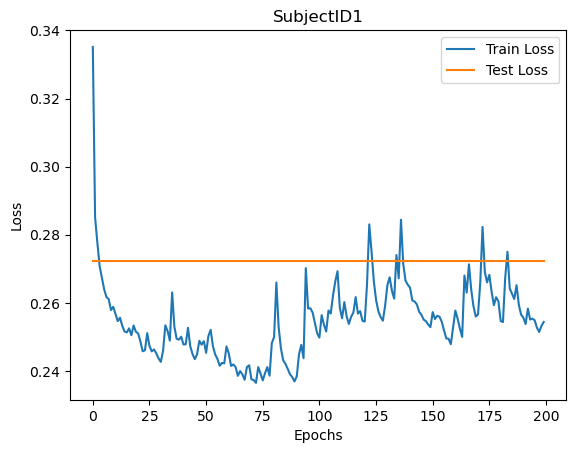

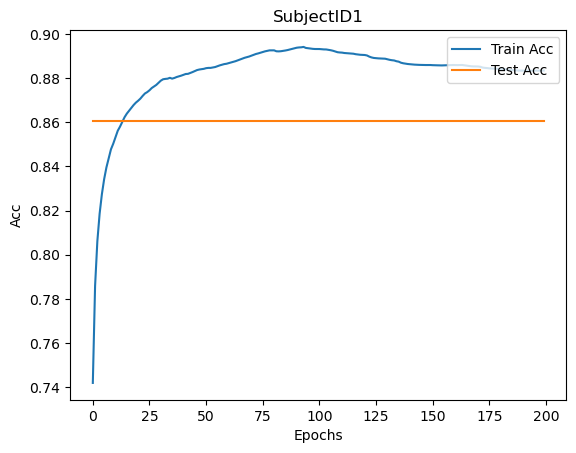

~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~SAVE~~~~~~~~~~~~~~~~

Subject 2
| epoch   0 | 0.3862 s/epoch | train loss 0.3249
| epoch   1 | 0.3889 s/epoch | train loss 0.2833
| epoch   2 | 0.3846 s/epoch | train loss 0.2727
| epoch   3 | 0.3897 s/epoch | train loss 0.2692
| epoch   4 | 0.3894 s/epoch | train loss 0.2664
| epoch   5 | 0.3835 s/epoch | train loss 0.2647
| epoch   6 | 0.3868 s/epoch | train loss 0.2618
| epoch   7 | 0.3891 s/epoch | train loss 0.2595
| epoch   8 | 0.3873 s/epoch | train loss 0.2586
| epoch   9 | 0.3841 s/epoch | train loss 0.2566
| epoch  10 | 0.3902 s/epoch | train loss 0.2566
| epoch  11 | 0.3838 s/epoch | train loss 0.2579
| epoch  12 | 0.3898 s/epoch | train loss 0.2533
| epoch  13 | 0.3871 s/epoch | train loss 0.2519
| epoch  14 | 0.3882 s/epoch | train loss 0.2547
| 

| epoch 162 | 0.4136 s/epoch | train loss 0.2594
| epoch 163 | 0.3934 s/epoch | train loss 0.2606
| epoch 164 | 0.3955 s/epoch | train loss 0.2580
| epoch 165 | 0.3965 s/epoch | train loss 0.2634
| epoch 166 | 0.3966 s/epoch | train loss 0.2576
| epoch 167 | 0.3930 s/epoch | train loss 0.2551
| epoch 168 | 0.3907 s/epoch | train loss 0.2550
| epoch 169 | 0.3972 s/epoch | train loss 0.2525
| epoch 170 | 0.3957 s/epoch | train loss 0.2530
| epoch 171 | 0.3952 s/epoch | train loss 0.2507
| epoch 172 | 0.3947 s/epoch | train loss 0.2504
| epoch 173 | 0.3952 s/epoch | train loss 0.2554
| epoch 174 | 0.3933 s/epoch | train loss 0.2504
| epoch 175 | 0.3942 s/epoch | train loss 0.2568
| epoch 176 | 0.3956 s/epoch | train loss 0.2534
| epoch 177 | 0.3844 s/epoch | train loss 0.2523
| epoch 178 | 0.3807 s/epoch | train loss 0.2511
| epoch 179 | 0.3924 s/epoch | train loss 0.2495
| epoch 180 | 0.3955 s/epoch | train loss 0.2476
| epoch 181 | 0.3937 s/epoch | train loss 0.2453
| epoch 182 | 0.3951

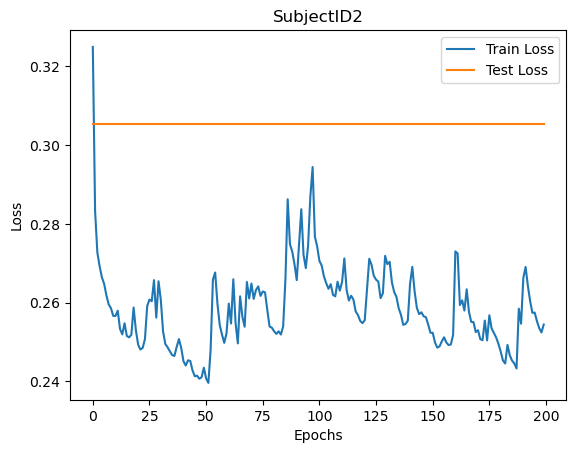

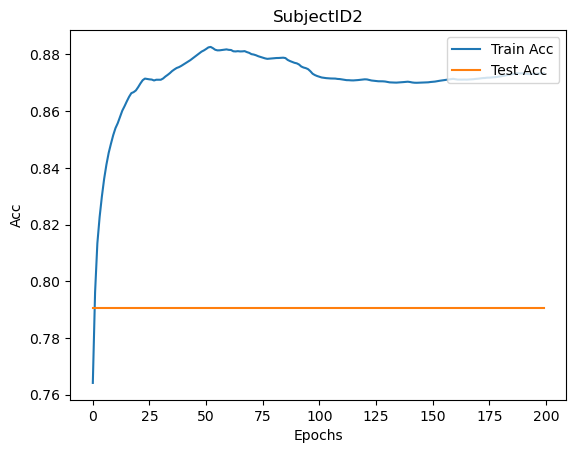


Subject 3
| epoch   0 | 0.3884 s/epoch | train loss 0.3315
| epoch   1 | 0.3841 s/epoch | train loss 0.2867
| epoch   2 | 0.3860 s/epoch | train loss 0.2758
| epoch   3 | 0.3883 s/epoch | train loss 0.2661
| epoch   4 | 0.3907 s/epoch | train loss 0.2652
| epoch   5 | 0.3882 s/epoch | train loss 0.2631
| epoch   6 | 0.3864 s/epoch | train loss 0.2595
| epoch   7 | 0.3886 s/epoch | train loss 0.2581
| epoch   8 | 0.3879 s/epoch | train loss 0.2571
| epoch   9 | 0.3856 s/epoch | train loss 0.2555
| epoch  10 | 0.3898 s/epoch | train loss 0.2541
| epoch  11 | 0.3750 s/epoch | train loss 0.2550
| epoch  12 | 0.3734 s/epoch | train loss 0.2532
| epoch  13 | 0.3857 s/epoch | train loss 0.2519
| epoch  14 | 0.3876 s/epoch | train loss 0.2626
| epoch  15 | 0.3871 s/epoch | train loss 0.2578
| epoch  16 | 0.3873 s/epoch | train loss 0.2548
| epoch  17 | 0.3892 s/epoch | train loss 0.2677
| epoch  18 | 0.3873 s/epoch | train loss 0.2646
| epoch  19 | 0.3902 s/epoch | train loss 0.2613
| epoch  

| epoch 167 | 0.3952 s/epoch | train loss 0.2547
| epoch 168 | 0.3917 s/epoch | train loss 0.2528
| epoch 169 | 0.3942 s/epoch | train loss 0.2522
| epoch 170 | 0.3949 s/epoch | train loss 0.2509
| epoch 171 | 0.3953 s/epoch | train loss 0.2508
| epoch 172 | 0.3946 s/epoch | train loss 0.2477
| epoch 173 | 0.3909 s/epoch | train loss 0.2487
| epoch 174 | 0.3944 s/epoch | train loss 0.2470
| epoch 175 | 0.3950 s/epoch | train loss 0.2469
| epoch 176 | 0.3929 s/epoch | train loss 0.2461
| epoch 177 | 0.3955 s/epoch | train loss 0.2487
| epoch 178 | 0.3951 s/epoch | train loss 0.2518
| epoch 179 | 0.3966 s/epoch | train loss 0.2624
| epoch 180 | 0.3967 s/epoch | train loss 0.2600
| epoch 181 | 0.3943 s/epoch | train loss 0.2988
| epoch 182 | 0.3917 s/epoch | train loss 0.2899
| epoch 183 | 0.3959 s/epoch | train loss 0.2804
| epoch 184 | 0.3919 s/epoch | train loss 0.2763
| epoch 185 | 0.3981 s/epoch | train loss 0.2711
| epoch 186 | 0.3895 s/epoch | train loss 0.2700
| epoch 187 | 0.3977

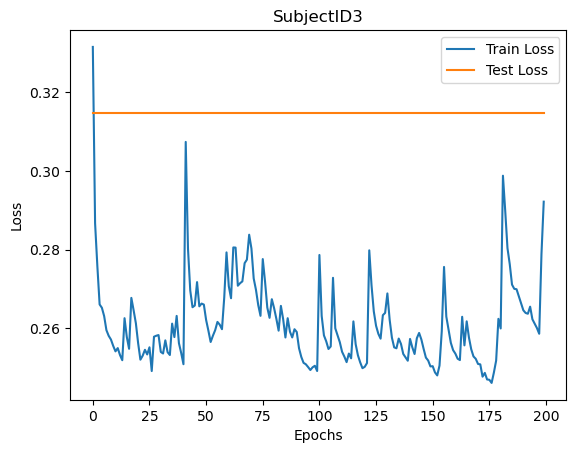

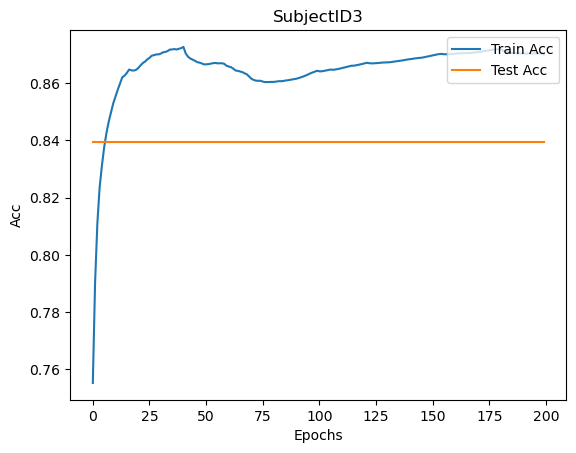


Subject 4
| epoch   0 | 0.3967 s/epoch | train loss 0.3260
| epoch   1 | 0.3956 s/epoch | train loss 0.2836
| epoch   2 | 0.3927 s/epoch | train loss 0.2736
| epoch   3 | 0.3943 s/epoch | train loss 0.2702
| epoch   4 | 0.3974 s/epoch | train loss 0.2694
| epoch   5 | 0.3931 s/epoch | train loss 0.2639
| epoch   6 | 0.3941 s/epoch | train loss 0.2622
| epoch   7 | 0.3929 s/epoch | train loss 0.2635
| epoch   8 | 0.4001 s/epoch | train loss 0.2599
| epoch   9 | 0.3937 s/epoch | train loss 0.2678
| epoch  10 | 0.3891 s/epoch | train loss 0.2667
| epoch  11 | 0.3950 s/epoch | train loss 0.2623
| epoch  12 | 0.3979 s/epoch | train loss 0.2578
| epoch  13 | 0.3944 s/epoch | train loss 0.2559
| epoch  14 | 0.3946 s/epoch | train loss 0.2551
| epoch  15 | 0.3944 s/epoch | train loss 0.2544
| epoch  16 | 0.3955 s/epoch | train loss 0.2538
| epoch  17 | 0.3937 s/epoch | train loss 0.2599
| epoch  18 | 0.3882 s/epoch | train loss 0.2544
| epoch  19 | 0.3895 s/epoch | train loss 0.2521
| epoch  

| epoch 167 | 0.3927 s/epoch | train loss 0.2614
| epoch 168 | 0.3969 s/epoch | train loss 0.2577
| epoch 169 | 0.3931 s/epoch | train loss 0.2615
| epoch 170 | 0.3960 s/epoch | train loss 0.2671
| epoch 171 | 0.3965 s/epoch | train loss 0.2641
| epoch 172 | 0.3952 s/epoch | train loss 0.2672
| epoch 173 | 0.3989 s/epoch | train loss 0.2626
| epoch 174 | 0.3938 s/epoch | train loss 0.2610
| epoch 175 | 0.3779 s/epoch | train loss 0.2620
| epoch 176 | 0.3838 s/epoch | train loss 0.2630
| epoch 177 | 0.3960 s/epoch | train loss 0.2618
| epoch 178 | 0.3970 s/epoch | train loss 0.2587
| epoch 179 | 0.3916 s/epoch | train loss 0.2608
| epoch 180 | 0.3987 s/epoch | train loss 0.2560
| epoch 181 | 0.3813 s/epoch | train loss 0.2554
| epoch 182 | 0.3825 s/epoch | train loss 0.2589
| epoch 183 | 0.3934 s/epoch | train loss 0.2718
| epoch 184 | 0.3945 s/epoch | train loss 0.2642
| epoch 185 | 0.3942 s/epoch | train loss 0.2600
| epoch 186 | 0.3932 s/epoch | train loss 0.2592
| epoch 187 | 0.3961

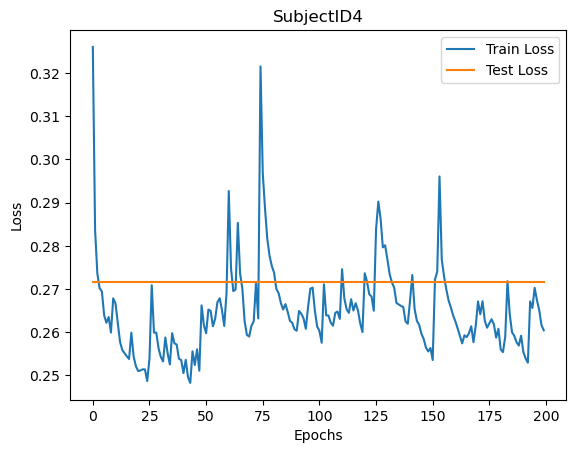

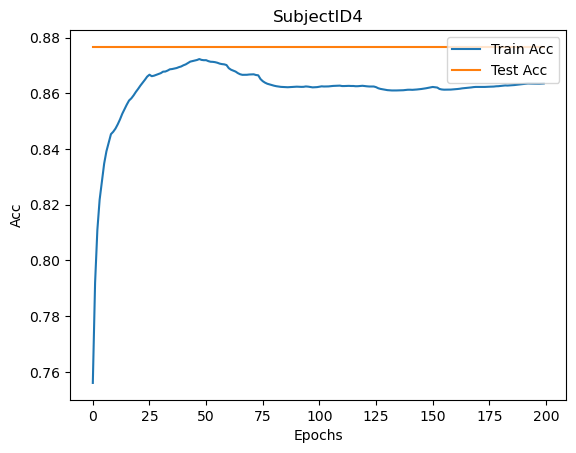


Subject 5
| epoch   0 | 0.3989 s/epoch | train loss 0.3307
| epoch   1 | 0.3916 s/epoch | train loss 0.2874
| epoch   2 | 0.3934 s/epoch | train loss 0.2756
| epoch   3 | 0.3939 s/epoch | train loss 0.2682
| epoch   4 | 0.3964 s/epoch | train loss 0.2673
| epoch   5 | 0.3948 s/epoch | train loss 0.2647
| epoch   6 | 0.3731 s/epoch | train loss 0.2633
| epoch   7 | 0.3977 s/epoch | train loss 0.2603
| epoch   8 | 0.3968 s/epoch | train loss 0.2609
| epoch   9 | 0.3921 s/epoch | train loss 0.2588
| epoch  10 | 0.3934 s/epoch | train loss 0.2553
| epoch  11 | 0.3975 s/epoch | train loss 0.2569
| epoch  12 | 0.3947 s/epoch | train loss 0.2558
| epoch  13 | 0.3928 s/epoch | train loss 0.2568
| epoch  14 | 0.3972 s/epoch | train loss 0.2517
| epoch  15 | 0.3833 s/epoch | train loss 0.2523
| epoch  16 | 0.3803 s/epoch | train loss 0.2523
| epoch  17 | 0.3961 s/epoch | train loss 0.2538
| epoch  18 | 0.3966 s/epoch | train loss 0.2515
| epoch  19 | 0.3938 s/epoch | train loss 0.2487
| epoch  

| epoch 167 | 0.3980 s/epoch | train loss 0.2692
| epoch 168 | 0.3961 s/epoch | train loss 0.2670
| epoch 169 | 0.3997 s/epoch | train loss 0.2710
| epoch 170 | 0.3989 s/epoch | train loss 0.2670
| epoch 171 | 0.3954 s/epoch | train loss 0.2693
| epoch 172 | 0.3968 s/epoch | train loss 0.2644
| epoch 173 | 0.3999 s/epoch | train loss 0.2666
| epoch 174 | 0.3985 s/epoch | train loss 0.2725
| epoch 175 | 0.4009 s/epoch | train loss 0.2665
| epoch 176 | 0.3707 s/epoch | train loss 0.2644
| epoch 177 | 0.3978 s/epoch | train loss 0.2623
| epoch 178 | 0.3986 s/epoch | train loss 0.2702
| epoch 179 | 0.3941 s/epoch | train loss 0.2635
| epoch 180 | 0.3960 s/epoch | train loss 0.2649
| epoch 181 | 0.3991 s/epoch | train loss 0.2651
| epoch 182 | 0.3999 s/epoch | train loss 0.2665
| epoch 183 | 0.3979 s/epoch | train loss 0.2632
| epoch 184 | 0.4003 s/epoch | train loss 0.2637
| epoch 185 | 0.3954 s/epoch | train loss 0.2611
| epoch 186 | 0.3979 s/epoch | train loss 0.2771
| epoch 187 | 0.3980

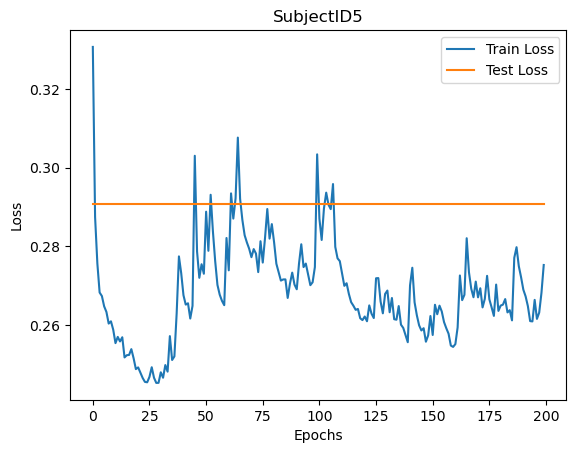

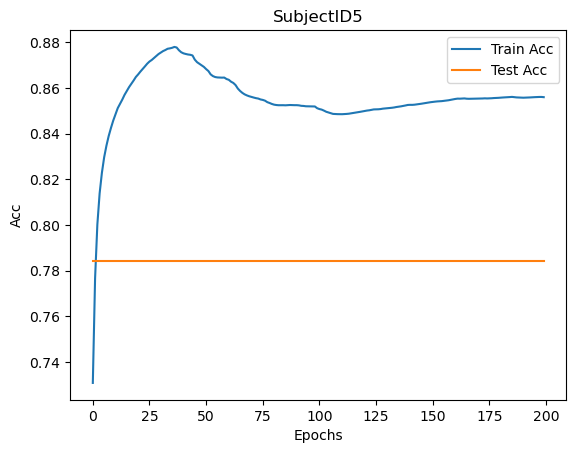


Subject 7
| epoch   0 | 0.4127 s/epoch | train loss 0.3297
| epoch   1 | 0.4104 s/epoch | train loss 0.2816
| epoch   2 | 0.4188 s/epoch | train loss 0.2743
| epoch   3 | 0.4085 s/epoch | train loss 0.2680
| epoch   4 | 0.4054 s/epoch | train loss 0.2640
| epoch   5 | 0.4047 s/epoch | train loss 0.2618
| epoch   6 | 0.3989 s/epoch | train loss 0.2598
| epoch   7 | 0.4378 s/epoch | train loss 0.2587
| epoch   8 | 0.5237 s/epoch | train loss 0.2584
| epoch   9 | 0.4091 s/epoch | train loss 0.2563
| epoch  10 | 0.4051 s/epoch | train loss 0.2549
| epoch  11 | 0.5757 s/epoch | train loss 0.2545
| epoch  12 | 0.4393 s/epoch | train loss 0.2550
| epoch  13 | 0.4409 s/epoch | train loss 0.2522
| epoch  14 | 0.4946 s/epoch | train loss 0.2521
| epoch  15 | 0.5053 s/epoch | train loss 0.2510
| epoch  16 | 0.4810 s/epoch | train loss 0.2511
| epoch  17 | 0.4841 s/epoch | train loss 0.2492
| epoch  18 | 0.4851 s/epoch | train loss 0.2492
| epoch  19 | 0.4926 s/epoch | train loss 0.2492
| epoch  

In [ ]:
#Layer 1 Training teacher
teacher_student_train_preds = []
teacher_student_train_gt = []


for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i].astype('float32'), axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i].astype('float32'), axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train.astype('float32')).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data.astype('float32')).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode

    model_teacher_student = MobileNetV3_Small_KD().to(device) 
    model_teacher_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = False
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader,Layer,sub)

#save(config['epochs'], teacher_student_model, teacher_student_optimizer, teacher_student_loss)
show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_teacher(Mobilnet)_Acc:",teacher_Student_eval_table[0])
print("Distillation_teacher(Mobilnet)_Rec:",teacher_Student_eval_table[1])
print("Distillation_teacher(Mobilnet)_Pre:",teacher_Student_eval_table[2])
print("Distillation_teacher(Mobilnet)_F1:",teacher_Student_eval_table[3])

In [ ]:
#Layer 2 Training Student
# Distillation_teacher_model = None
Distillation_teacher_model = load_checkpoint(model_teacher_student, PATH)

Distillation_student_train_preds = []
Distillation_student_train_gt = []

for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i].astype('float32'), axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i].astype('float32'), axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i].astype('float32'), axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train.astype('float32')).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data.astype('float32')).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    ResNet_DS = Net_Teacher_Student(block, [3, 4, 23, 3], 1, 2)
    model_Distillation_student = ResNet_DS.to(device)
    #model_Distillation_student = Net_Teacher_Student(config).to(device) 
    model_Distillation_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_distillation_student = torch.optim.Adam(model_Distillation_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    Layer = True
    training_distillation_student(trainloader,optimizer_distillation_student,criterion,Distillation_teacher_model,model_Distillation_student,alpha,testloader,Layer,sub)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)

show_CM_teacher_student(Distillation_student_train_preds, Distillation_student_train_gt)
teacher_Student_eval_table = evaluation(Distillation_student_train_preds, Distillation_student_train_gt)     

print("Distillation_student(CNNSmall)_Acc:",teacher_Student_eval_table[0])
print("Distillation_student(CNNSmall)_Rec:",teacher_Student_eval_table[1])
print("Distillation_student(CNNSmall)_Pre:",teacher_Student_eval_table[2])
print("Distillation_student(CNNSmall)_F1:",teacher_Student_eval_table[3])


In [ ]:
# print("Teacher(RestNet50)_Acc:",sum(Accuracy_teacher)/14)
# print("Teacher(RestNet50)_Rec:",sum(Recall_teacher)/11)
# print("Teacher(RestNet50)_Pre:",sum(Precision_teacher)/11)
# print("Teacher(RestNet50)_F1:",sum(F1score_teacher)/11)

# print("Original_Student(CNN)_Acc:",sum(Accuracy_student)/14)
# print("Original_Student(CNN)_Rec:",sum(Recall_student)/11)
# print("Original_Student(CNN)_Pre:",sum(Precision_student)/11)
# print("Original_Student(CNN)_F1:",sum(F1score_student)/11)

# print("Distillation_Student(CNN)_Acc:",sum(Accuracy_teacher_student)/14)
# print("Distillation_Student(CNN)_Rec:",sum(Recall_teacher_student)/11)
# print("Distillation_Student(CNN)_Pre:",sum(Precision_teacher_student)/11)
# print("Distillation_Student(CNN)_F1:",sum(F1score_teacher_student)/11)



dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher, params_teachar = profile(model_teacher,(dummy_input,))
print('\n\nflops_teacher: %.3f M, params_teachar: %.3f M' % (flops_teacher / 1000000.0, params_teachar / 1000000.0))
dummy_input = torch.randn(64,1,14,3,device=device)
flops_student, params_student = profile(model_student,(dummy_input,))
print('flops:',flops_student, 'params', params_student)
print('\nflops_student: %.3f K, params_student: %.3f K' % (flops_student / 1000.0, params_student / 1000.0))
dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher_student, params_teacher_student = profile(model_teacher_student,(dummy_input,))
print('flops:',flops_teacher_student, 'params', params_teacher_student)
print('\nflops_teacher_student: %.3f K, params_teacher_student: %.3f K' % (flops_teacher_student / 1000.0, params_teacher_student / 1000.0))